In [1]:

import pandas as pd 
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import StratifiedKFold,  GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklift.models import SoloModel, TwoModels, ClassTransformation, ClassTransformationReg
import matplotlib.pyplot as plt
import numpy as np
import swifter
from tqdm import tqdm
from statsmodels.stats.weightstats  import CompareMeans
import gc
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)
from sklift.viz import  plot_qini_curve, plot_uplift_curve
pd.options.display.max_columns = None



# Object For Preprocessing

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
class PrepocessingDataSetLetu():
    def __init__(self,  cat_vars = ['lftm_type','SEGMENT_N'
                                ,	'SUB_EMAIL'
                                , 'Тип карты'	
                                , 'Канал регистрации'
                                , 'NewComer'] 
                ,  for_norm = ['last_order_days',	'AMOUNT'
                                ,	'ORDERS'
                                ,	'AOV'	
                                ,'LTV_1M'
                                , 'AO_per_month'
                                , 'GET_Bonus'
                                ,	'USE_Bonus'
                                ,	'NON_SPEND_BONUS'
                                ,	'BASE_GET_Bonus'
                                ,	'BASE_USE_Bonus'
                                ,	'Express_GET_Bonus'
                                ,	'Express_USE_Bonus'
                                ,	'Camp_GET_Bonus'
                                ,	'REG_GET_Bonus'	
                                , 'Camp_BASE_GET_Bonus'
                                ,	'REG_BASE_GET_Bonus'
                                , 'AVG_USE_BONUS'
                                ,	'DISC_AMOUNT'
                                ,	'DISC_ORDERS'
                                , 'BASE_AVG_USE_BONUS'
                                ,	'BASE_DISC_AMOUNT'
                                ,	'BASE_DISC_ORDERS'
                                , 'Express_AVG_USE_BONUS',	'Express_DISC_AMOUNT',	'Express_DISC_ORDERS'
                                ,'min_days_between', 'max_days_between', 'avg_days_between']
                , age = 'AGE'
               
            ):
            self.cat_vars = cat_vars
            self.for_norm = for_norm
            self.age = age
            self.scaler = None#StandardScaler()
            self.ohe = None#OneHotEncoder()
            self.ohe_solomodel = None#OneHotEncoder()
            self.med = None


    def remove_colls(self, colls):
        for c in colls:
            if c in self.for_norm:
                self.for_norm.remove(c)
            if c in self.cat_vars:
                self.cat_vars.remove(c)



    def fit(self, df):
        Y_var = df[['target','treat']]
        X_var = df.drop(['target','treat'], axis = 1)
        self.ohe = OneHotEncoder()
        self.scaler = StandardScaler()
        self.ohe_solomodel = OneHotEncoder()
        self.ohe.fit(X_var[self.cat_vars].values)
        self.med = X_var[self.age].median()
        self.scaler.fit(X_var[self.for_norm].values)
        self.ohe_solomodel.fit(Y_var.treat.values.reshape(-1, 1))
        del X_var, Y_var


    def preprocessing_data(self, df):
                        Y_var = df[['target','treat']]
                        X_var = df.drop(['target','treat'], axis = 1)
                        dataset = pd.DataFrame()
                        
                        ## Categorical to Vec
                        if(self.ohe is None):
                            self.ohe = OneHotEncoder()
                            res = self.ohe.fit_transform(X_var[self.cat_vars].values).toarray()
                        else:
                            res = self.ohe.transform(X_var[self.cat_vars].values).toarray()
                        
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)
                        X_var = X_var.drop(self.cat_vars, axis =1)                    
                       #dataset.head()

                        ## Numeric preprocessing
                        if(self.med is None):
                            self.med = X_var[self.age].median()

                        res =  X_var[self.age].apply(lambda x: x if((x >= 16) and (x <= 90)) else self.med).fillna(self.med)
                        res = (res / 100).values                                            
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)                                            
                        X_var = X_var.drop([self.age], axis =1).fillna(0)                  

                        if(self.scaler is None):
                            self.scaler = StandardScaler()
                            res = self.scaler.fit_transform(X_var[self.for_norm].values)
                        else:
                            res = self.scaler.transform(X_var[self.for_norm].values)

                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)
                        X_var = X_var.drop(self.for_norm, axis =1)      
                        dataset = pd.concat([dataset
                                        , pd.DataFrame(X_var.values)] , axis = 1)
                        del X_var   
                        gc.collect()
                        cols = ['var_'+str(i) for i in range(dataset.shape[1])]
                        dataset.columns = cols
                        dataset.index = df.index
                        return dataset, Y_var  


    
    def preprocessing_data_solomodel(self, df):
                        Y_var = df[['target','treat']]
                        X_var = df.drop(['target','treat'], axis = 1)
                        dataset = pd.DataFrame()
                        
                        ## Categorical to Vec
                        if(self.ohe is None):
                            self.ohe = OneHotEncoder()
                            res = self.ohe.fit_transform(X_var[self.cat_vars].values).toarray()
                        else:
                            res = self.ohe.transform(X_var[self.cat_vars].values).toarray()
                        
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)
                        X_var = X_var.drop(self.cat_vars, axis =1)                    
                       #dataset.head()

                        ## Numeric preprocessing
                        if(self.med is None):
                            self.med = X_var[self.age].median()

                        res =  X_var[self.age].apply(lambda x: x if((x >= 16) and (x <= 90)) else self.med).fillna(self.med)
                        res = (res / 100).values    
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)                                            
                        X_var = X_var.drop([self.age], axis =1).fillna(0)                  

                        if(self.scaler is None):
                            self.scaler = StandardScaler()
                            res = self.scaler.fit_transform(X_var[self.for_norm].values)
                        else:
                            res = self.scaler.transform(X_var[self.for_norm].values)

                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)
                        X_var = X_var.drop(self.for_norm, axis =1)      
                        dataset = pd.concat([dataset
                                        , pd.DataFrame(X_var.values)] , axis = 1)
                        del X_var   
                        gc.collect()


                        if(self.ohe_solomodel is None):
                            self.ohe_solomodel = OneHotEncoder()
                            res = self.ohe_solomodel.fit_transform(Y_var.treat.values.reshape(-1, 1)).toarray()
                        else:
                            res = self.ohe_solomodel.transform(Y_var.treat.values.reshape(-1, 1)).toarray()
                        
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)

                        cols = ['var_'+str(i) for i in range(dataset.shape[1])]
                        dataset.columns = cols
                        dataset.index = df.index
                        return dataset, Y_var

In [3]:
def get_metrics(target, treat, uplift, k):
    return uplift_at_k(target, uplift, treat, strategy='overall', k=k) , uplift_at_k(target, uplift, treat, strategy='by_group', k=k) , qini_auc_score(target, uplift, treat), uplift_auc_score(target, uplift, treat)


def get_report(target, treat, uplift, plot_path = '', k =0.3):
    """
    Return:
        * uplift_at_k_overall
        * plift_at_k_group
        * qini_score
        * uplift_score

        Print qini, uplift plots
    """
    uplift_overall, uplift_group, qini_score, uplift_score = get_metrics(target, treat, uplift, k)                   
    print(f'UpLift at 30%: overall - {round(uplift_overall, 6)}, grouped - {round(uplift_group, 6)}.\nQini AUC Score: {round(qini_score, 6)}; UpLift AUC Score: {round(uplift_score, 6)}')

    fig, ax = plt.subplots(1, 2, figsize = (30, 10))
    ax[0].set_title('Qini Curve')
    ax[1].set_title('UpLift Curve')
    plot_qini_curve(target , uplift, treatment=treat, ax = ax[0], perfect=False)
    gc.collect()
    plot_uplift_curve(target , uplift, treatment=treat, ax = ax[1], perfect=False)
    gc.collect()
    gc.collect()
    gc.collect()
    plt.savefig(f"Plots/Base model Split.png")
    return uplift_overall, uplift_group, qini_score, uplift_score

# Compare means, vars

In [4]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                #     , dtype = {'NPL':str
                #             , 'SEGMENT_N':str}
                , index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df_subm = pd.read_csv(r'uplift_subm_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                #     , dtype = {'NPL':str
                #             , 'SEGMENT_N':str}
                , index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')



df.index.name = None
df_subm.index.name = None

C:\Users\Kirill\AppData\Local\Temp\ipykernel_5664\364234166.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv(r'uplift_dataset.zip'
C:\Users\Kirill\AppData\Local\Temp\ipykernel_5664\364234166.py:7: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_subm = pd.read_csv(r'uplift_subm_dataset.zip'


In [5]:
df['Тип карты'].value_counts()

Как карточное платежное средство    3141649
Без возможности оплаты              1794950
Name: Тип карты, dtype: int64

In [6]:
df['SUB_EMAIL'] = df['SUB_EMAIL'].swifter.apply(lambda x: 1 if x == 'Да' else 0)
df['lftm_type'] = df['lftm_type'].swifter.apply(lambda x: 1 if x =='NewComer' else 0)
df['Тип карты'] = df['Тип карты'].swifter.apply(lambda x: 1 if x == 'Как карточное платежное средство' else 0)
df['Канал регистрации'] = df['Канал регистрации'].swifter.apply(lambda x: 1 if x =='Розница' else 0)

df_subm['SUB_EMAIL'] = df_subm['SUB_EMAIL'].swifter.apply(lambda x: 1 if x == 'Да' else 0)
df_subm['lftm_type'] = df_subm['lftm_type'].swifter.apply(lambda x: 1 if x =='NewComer' else 0)
df_subm['Тип карты'] = df_subm['Тип карты'].swifter.apply(lambda x: 1 if x == 'Как карточное платежное средство' else 0)
df_subm['Канал регистрации'] = df_subm['Канал регистрации'].swifter.apply(lambda x: 1 if x =='Розница' else 0)

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4936599 [00:00<?, ?it/s]

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4936599 [00:00<?, ?it/s]

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4936599 [00:00<?, ?it/s]

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4936599 [00:00<?, ?it/s]

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/672331 [00:00<?, ?it/s]

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/672331 [00:00<?, ?it/s]

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/672331 [00:00<?, ?it/s]

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/672331 [00:00<?, ?it/s]

In [7]:
display(df.describe())
display(df_subm.describe())

SEGMENT_N     SUB_EMAIL        target         treat     lftm_type  \
count  4.936599e+06  4.936599e+06  4.936599e+06  4.936599e+06  4.936599e+06   
mean   2.102686e+00  5.416395e-01  7.076350e-02  9.045957e-01  9.942412e-01   
std    1.802472e+00  4.982632e-01  2.564294e-01  2.937727e-01  7.566809e-02   
min   -1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00   
50%    1.000000e+00  1.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00   
75%    4.000000e+00  1.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00   
max    8.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

           NewComer     Тип карты  Канал регистрации           AGE  \
count  4.936599e+06  4.936599e+06       4.936599e+06  2.361936e+06   
mean   3.618461e-01  6.363995e-01       5.491961e-01  3.668345e+01   
std    4.805346e-01  4.810356e-01       4.975739e-01  1.384153e+01   
min    0.000000e+00  0.000000e+00       0.000000e+00 -1.320000e+02   
25%    0.000000e+00  0.000000e+00       0.000000e+00  2.800000e+01   
50%    0.000000e+00  1.000000e+00       1.000000e+00  3.600000e+01   
75%    1.000000e+00  1.000000e+00       1.000000e+00  4.400000e+01   
max    1.000000e+00  1.000000e+00       1.000000e+00  1.220000e+02   

             AMOUNT        ORDERS           AOV  last_order_days  \
count  3.965534e+06  4.924956e+06  3.965534e+06     4.010567e+06   
mean   3.870770e+03  1.338891e+00  2.568206e+03     4.640763e+01   
std    5.685045e+03  1.408313e+00  3.125496e+03     3.061397e+01   
min    0.000000e+00  0.000000e+00  0.000000e+00     1.000000e+00   
25%    7.970000e+02  1.000000e+00  6.040000e+02     2.000000e+01   
50%    2.118700e+03  1.000000e+00  1.439400e+03     4.200000e+01   
75%    5.071000e+03  2.000000e+00  3.496000e+03     7.000000e+01   
max    1.164658e+06  3.440000e+02  1.817081e+05     1.230000e+02   

             LTV_1M  AO_per_month     GET_Bonus     USE_Bonus  \
count  3.965534e+06  4.924956e+06  4.924931e+06  1.752073e+06   
mean   9.676926e+02  3.347227e-01  6.673301e+02  4.581450e+02   
std    1.421261e+03  3.520784e-01  3.555825e+02  3.079639e+02   
min    0.000000e+00  0.000000e+00 -5.000000e+02  1.000000e+00   
25%    1.992500e+02  2.500000e-01  3.890000e+02  3.000000e+02   
50%    5.296750e+02  2.500000e-01  5.430000e+02  5.000000e+02   
75%    1.267750e+03  5.000000e-01  8.460000e+02  5.000000e+02   
max    2.911646e+05  8.600000e+01  7.295800e+04  9.214900e+04   

       NON_SPEND_BONUS  BASE_GET_Bonus  BASE_USE_Bonus  Express_GET_Bonus  \
count     1.752048e+06    3.972821e+06   490812.000000       4.909328e+06   
mean      3.300309e+02    5.077126e+01       93.949150       6.283649e+02   
std       2.990090e+02    1.252251e+02      266.839348       3.321920e+02   
min      -1.919100e+04   -4.520000e+02        0.160000      -5.000000e+02   
25%       5.400000e+01    9.000000e+00       11.000000       3.000000e+02   
50%       3.090000e+02    2.300000e+01       32.000000       5.000000e+02   
75%       5.120000e+02    5.400000e+01       78.000000       8.000000e+02   
max       1.375900e+04    7.165800e+04    91649.000000       3.811000e+04   

       Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  Camp_BASE_GET_Bonus  \
count       1.683254e+06    67532.000000   3.965533e+06         67532.000000   
mean        4.494819e+02      338.617826   3.993899e+01           338.617826   
std         2.483220e+02      439.071044   5.743451e+01           439.071044   
min         1.000000e+00        0.000000   0.000000e+00             0.000000   
25%         3.000000e+02      144.000000   9.000000e+00           144.000000   
50%         5.000000e+02      218.000000   2.300000e+01           218.000000   
75%         5.000000e+02      470.000000   5.200000e+01           470.000000   
max         3.711000e+04    51312.000000   1.173200e+04         51312.000000   

       REG_BASE_GET_Bonus       AVG_DIS  AVG_USE_BONU

SEGMENT_N      SUB_EMAIL         target          treat  \
count  672331.000000  672331.000000  672331.000000  672331.000000   
mean        2.106132       0.588002       0.075958       0.906503   
std         1.800421       0.492195       0.264931       0.291128   
min        -1.000000       0.000000       0.000000       0.000000   
25%         1.000000       0.000000       0.000000       1.000000   
50%         1.000000       1.000000       0.000000       1.000000   
75%         4.000000       1.000000       0.000000       1.000000   
max         8.000000       1.000000       1.000000       1.000000   

           lftm_type       NewComer      Тип карты  Канал регистрации  \
count  672331.000000  672331.000000  672331.000000      672331.000000   
mean        0.805007       0.398873       0.686702           0.483118   
std         0.396196       0.489667       0.463835           0.499715   
min         0.000000       0.000000       0.000000           0.000000   
25%         1.000000       0.000000       0.000000           0.000000   
50%         1.000000       0.000000       1.000000           0.000000   
75%         1.000000       1.000000       1.000000           1.000000   
max         1.000000       1.000000       1.000000           1.000000   

                 AGE         AMOUNT         ORDERS            AOV  \
count  331092.000000  483658.000000  600169.000000  483658.000000   
mean       36.470356    4152.327901       1.506834    2481.633738   
std        13.660333    5677.174007       1.533454    2949.195685   
min      -132.000000       0.000000       0.000000       0.000000   
25%        28.000000     884.800000       1.000000     619.567500   
50%        36.000000    2380.750000       1.000000    1461.850000   
75%        44.000000    5423.500000       2.000000    3359.400000   
max       122.000000  353298.000000      75.000000  152911.550000   

       last_order_days         LTV_1M   AO_per_month      GET_Bonus  \
count    488789.000000  483658.000000  600169.000000  599761.000000   
mean         59.143682    1038.081975       0.376708     603.659295   
std          28.047024    1419.293502       0.383364     423.810788   
min           1.000000       0.000000       0.000000   -3486.000000   
25%          36.000000     221.200000       0.250000     305.000000   
50%          59.000000     595.187500       0.250000     540.000000   
75%          79.000000    1355.875000       0.500000     879.000000   
max         122.000000   88324.500000      18.750000   18023.000000   

           USE_Bonus  NON_SPEND_BONUS  BASE_GET_Bonus  BASE_USE_Bonus  \
count  257146.000000    256738.000000   485352.000000   111350.000000   
mean      419.713824       256.108941       55.470268       82.047984   
std       335.313893       401.664944      117.255265      172.090627   
min         0.040000     -6986.000000     -480.000000        0.040000   
25%       300.000000        15.000000       10.000000       13.000000   
50%       300.000000       306.000000       26.000000       34.000000   
75%       500.000000       507.000000       57.000000       76.000000   
max     16523.000000      5292.000000     9050.000000     8537.000000   

       Express_GET_Bonus  Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  \
count      514547.000000      225433.000000    13077.000000  483658.000000   
mean          651.308232         438.230818      312.368892      42.883207   
std           375.943722         295.111924      305.908251      57.372828   
min         -3500.000000           1.000000        0.000000       0.000000   
25%           300.000000         300.000000      149.000000      10.000000   
50%           600.000000         300.000000      226.000000      25.000000   
75%           900.000000         500.000000      396.000000      56.000000   
max         18023.000000       16523.000000     6380.000000    3537.000000   

       Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus        AVG_DIS  AVG_USE_BONUS  \
count         13077.000000  

In [8]:
def ttest_means(x_mean = .0, y_mean = .0, x_std = 1.0, y_std = 1.0, n1 = 2, n2 = 1):
    from scipy.stats import t
    S = np.sqrt(((n1 - 1) * x_std**2 +  (n2 - 1) * y_std**2) - 2)
    T = (x_mean - y_mean) / (S * np.sqrt(1 / n1 + 1 / n2))
    rv = t(df = n1 + n2 - 2)
    return rv.sf(np.abs(T)) * 2, T


def chi_vars(x_var = 1.0, y_var = 1.0, n1 = 2, n2 = 1):
    from scipy.stats import f
    F = x_var/y_var #calculate F test statistic 
    dfn = n1-1 #define degrees of freedom numerator 
    dfd = n2-1 #define degrees of freedom denominator 
    p = 1- f.cdf(F, dfn, dfd) #find p-value of F test statistic 
    return p , F   


In [9]:
colls = df.columns.tolist()
res = {}
stats = {}
for coll in colls:
    p_m, T = ttest_means(df[coll].mean()
                        , df_subm[coll].mean()
                        , df[coll].std()
                        , df_subm[coll].std()
                        , df[coll].dropna().shape[0]
                        , df_subm[coll].dropna().shape[0])
    p_v, F = chi_vars(df[coll].std(ddof = 1)
                        , df_subm[coll].std(ddof = 1)
                        , df[coll].dropna().shape[0]
                        , df_subm[coll].dropna().shape[0])
    res[coll] = {'p_means': round(p_m, 4)
                    , 'p_vars': round(p_v, 4)}
    stats[coll] = (T, F, round(df[coll].mean(), 4)
                        , round(df_subm[coll].mean(), 4)
                        , round(df[coll].std(), 4)
                        , round(df_subm[coll].std(), 4)
                        , round(df[coll].dropna().shape[0] + df_subm[coll].dropna().shape[0] - 2 , 4)
                        , round(df[coll].std(ddof = 1), 4)
                        , round(df_subm[coll].std(ddof = 1), 4))

In [10]:
# res

In [11]:
# stats

In [12]:
# res_sort = sorted(res.items(), key = lambda x: x[1])
# res_sort

In [13]:
colls_to_drop = [k for k,v in res.items() if (v['p_means'] <= 0.05) or (v['p_vars'] <= 0.05)
            ]


if 'treat' in  colls_to_drop:
    colls_to_drop.remove('treat')

if 'target' in  colls_to_drop:
    colls_to_drop.remove('target')
colls_to_drop

['SUB_EMAIL',
 'Тип карты',
 'AGE',
 'AOV',
 'last_order_days',
 'BASE_GET_Bonus',
 'BASE_USE_Bonus',
 'Camp_GET_Bonus',
 'Camp_BASE_GET_Bonus',
 'AVG_DIS',
 'BASE_AVG_USE_BONUS',
 'BASE_DISC_AMOUNT',
 'Express_AVG_DIS',
 'Express_DISC_AMOUNT']

In [4]:
colls_to_drop = []

In [15]:
del df
del df_subm
gc.collect()

131

# Базовая модель

In [16]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'] + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
display(df.head())
proc_data = PrepocessingDataSetLetu()
proc_data.remove_colls(colls_to_drop)
X_data, Y_data = proc_data.preprocessing_data(df)
display(X_data.head()) 
display(Y_data.head()) 


C:\Users\Kirill\AppData\Local\Temp\ipykernel_5664\4293277823.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv(r'uplift_dataset.zip'


SEGMENT_N SUB_EMAIL  target  treat lftm_type  NewComer  \
7725915336        -1       Нет       0      1  NewComer         1   
7725915337        -1       Нет       0      0  NewComer         1   
7725915364         1        Да       0      1  NewComer         0   
7725915373         1        Да       0      1  NewComer         0   
7725915376         1        Да       0      1  NewComer         0   

                                   Тип карты Канал регистрации   AGE  AMOUNT  \
7725915336            Без возможности оплаты             Ecomm   NaN     NaN   
7725915337            Без возможности оплаты             Ecomm   NaN     NaN   
7725915364  Как карточное платежное средство             Ecomm   NaN  5700.0   
7725915373  Как карточное платежное средство             Ecomm   NaN  6468.7   
7725915376  Как карточное платежное средство             Ecomm  34.0  3814.0   

            ORDERS       AOV  last_order_days    LTV_1M  AO_per_month  \
7725915336     0.0       NaN              NaN       NaN          0.00   
7725915337     0.0       NaN              NaN       NaN          0.00   
7725915364     1.0  5700.000             31.0  1425.000          0.25   
7725915373     4.0  1617.175              9.0  1617.175          1.00   
7725915376     2.0  1907.000             67.0   953.500          0.50   

            GET_Bonus  USE_Bonus  NON_SPEND_BONUS  BASE_GET_Bonus  \
7725915336     1000.0        NaN              NaN             NaN   
7725915337     1000.0        NaN              NaN             NaN   
7725915364      785.0        NaN              NaN           285.0   
7725915373      871.0      544.0            327.0            71.0   
7725915376     1040.0      500.0            540.0            40.0   

            BASE_USE_Bonus  Express_GET_Bonus  Express_USE_Bonus  \
7725915336             NaN             1000.0                NaN   
7725915337             NaN             1000.0                NaN   
7725915364             NaN              500.0                NaN   
7725915373            44.0              800.0              500.0   
7725915376             NaN             1000.0              500.0   

            Camp_GET_Bonus  REG_GET_Bonus  Camp_BASE_GET_Bonus  \
7725915336             NaN            NaN                  NaN   
7725915337             NaN            NaN                  NaN   
7725915364           228.0           57.0                228.0   
7725915373             NaN           71.0                  NaN   
7725915376             NaN           40.0                  NaN   

            REG_BASE_GET_Bonus   AVG_DIS  AVG_USE_BONUS  DISC_AMOUNT  \
7725915336                 NaN       NaN            NaN          NaN   
7725915337                 NaN       NaN            NaN          NaN   
7725915364                57.0       NaN            NaN          NaN   
7725915373                71.0  0.344958          544.0       1033.0   
7725915376                40.0  0.228310          500.0       1690.0   

            DISC_ORDERS  BASE_AVG_DIS  BASE_AVG_USE_BONUS  BASE_DISC_AMOUNT  \
7725915336          NaN           NaN                 NaN               NaN   
7725915337          NaN           NaN                 NaN               NaN   
7725915364          NaN           NaN                 NaN               NaN   
7725915373          1.0      0.040854                44.0            1033.0   
7725915376          1.0           NaN                 NaN               NaN   

            BASE_DISC_ORDERS  Express_AVG_DIS  Express_AVG_USE_BONUS  \
7725915336               NaN              NaN                    NaN   
7725915337               NaN              NaN                    NaN   
7725915364               NaN              NaN                    NaN   
7725915373               1.0         0.326157                  500.0   
7725915376               NaN         0.228310                  500.0   

            Express_DISC_AMOUNT  Express_DISC_ORDERS  min_days_between  \
7725915336                  NaN         

var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7725915336    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725915337    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725915364    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7725915373    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7725915376    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7725915336    0.0     0.0     1.0     1.0     0.0     1.0     0.0     0.0   
7725915337    0.0     0.0     1.0     1.0     0.0     1.0     0.0     0.0   
7725915364    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   
7725915373    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   
7725915376    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7725915336     1.0    0.36 -1.142168 -0.584185 -0.948573 -0.691940 -0.584185   
7725915337     1.0    0.36 -1.142168 -0.584185 -0.948573 -0.691940 -0.584185   
7725915364     0.0    0.36 -0.203041  0.486727 -0.238421  1.219848  0.486727   
7725915373     0.0    0.36 -0.869518  0.631150  1.892033 -0.149537  0.631150   
7725915376     0.0    0.34  0.887558  0.132387  0.471730 -0.052330  0.132387   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7725915336 -0.948573  0.937219 -0.568816 -0.492042 -0.358016 -0.105294   
7725915337 -0.948573  0.937219 -0.568816 -0.492042 -0.358016 -0.105294   
7725915364 -0.238421  0.334366 -0.568816 -0.492042  2.139214 -0.105294   
7725915373  1.892033  0.575507  1.334204  0.881612  0.264101  0.390701   
7725915376  0.471730  1.049378  1.180284  1.776377 -0.007528 -0.105294   

              var_30    var_31    var_32    var_33    var_34    var_35  \
7725915336  1.121290 -0.594659 -0.071611 -0.595567 -0.071611 -0.595567   
7725915337  1.121290 -0.594659 -0.071611 -0.595567 -0.071611 -0.595567   
7725915364 -0.373339 -0.594659  3.453093  0.462552  3.453093  0.462552   
7725915373  0.523438  1.345352 -0.071611  0.722441 -0.071611  0.722441   
7725915376  1.121290  1.345352 -0.071611  0.146973 -0.071611  0.146973   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7725915336 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915337 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915364 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915373  2.010156  0.004130  0.711746  0.812655  0.459654  2.000484   
7725915376  1.795316  0.245265  0.711746 -0.147910 -0.174913 -0.287372   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7725915336 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915337 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915364 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915373  1.738082  0.071780  0.977076 -2.627860  0.266733 -1.271727   
7725915376  1.738082  0.363994  0.977076  0.273855  0.130364  0.210894   

              var_48    var_49    var_50  
7725915336  0.000000  0.000000  0.000000  
7725915337  0.000000  0.000000  0.000000  
7725915364  0.000000  0.000000  0.000000  
7725915373  0.344958  0.040854  0.326157  
7725915376  0.228310  0.000000  0.228310

target  treat
7725915336       0      1
7725915337       0      0
7725915364       0      1
7725915373       0      1
7725915376       0      1

UpLift at 30%: overall - 0.007663, grouped - 0.007675.
Qini AUC Score: -0.002093; UpLift AUC Score: -0.00133


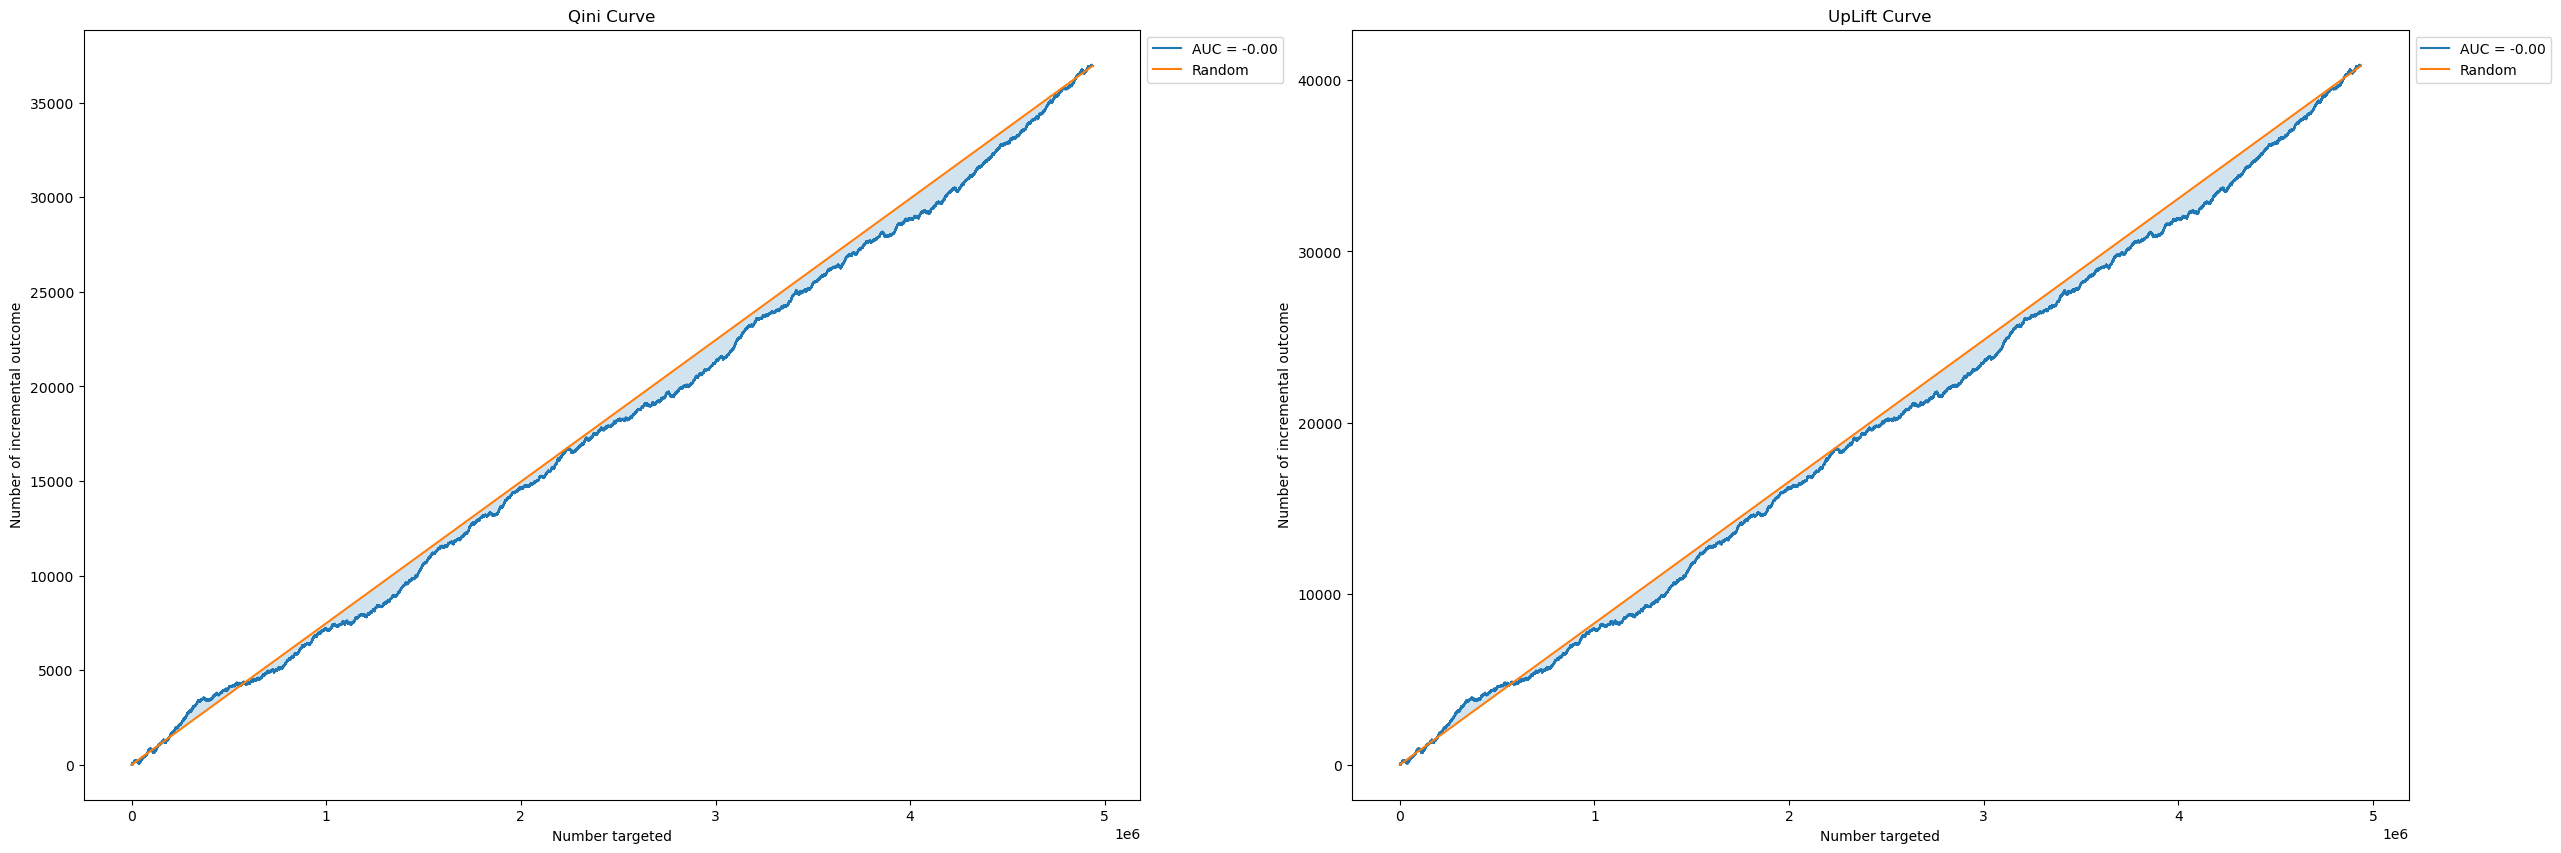

In [17]:
treat = Y_data.treat.values
y = Y_data.target.values

from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


y_pred = np.random.uniform(-1, 1, len(treat)).tolist()
gc.collect()
uplift_overall, uplift_group, qini_score, uplift_score = get_report(y, treat, y_pred, 'Plots/Base model Split.png')










In [18]:
del df
del X_data
del Y_data
del treat
del y
gc.collect()

7530

# Метод одной модели

In [19]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte']  + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
#X_data = pd.concat([X_data, pd.get_dummies(Y_data.treat)], axis= 1)
treat = Y_data.treat.values
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target.values
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()

C:\Users\Kirill\AppData\Local\Temp\ipykernel_5664\2515589215.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv(r'uplift_dataset.zip'


var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7725915336    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725915337    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725915364    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7725915373    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7725915376    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7725915336    0.0     0.0     1.0     1.0     0.0     1.0     0.0     0.0   
7725915337    0.0     0.0     1.0     1.0     0.0     1.0     0.0     0.0   
7725915364    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   
7725915373    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   
7725915376    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7725915336     1.0    0.36 -1.142168 -0.584185 -0.948573 -0.691940 -0.584185   
7725915337     1.0    0.36 -1.142168 -0.584185 -0.948573 -0.691940 -0.584185   
7725915364     0.0    0.36 -0.203041  0.486727 -0.238421  1.219848  0.486727   
7725915373     0.0    0.36 -0.869518  0.631150  1.892033 -0.149537  0.631150   
7725915376     0.0    0.34  0.887558  0.132387  0.471730 -0.052330  0.132387   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7725915336 -0.948573  0.937219 -0.568816 -0.492042 -0.358016 -0.105294   
7725915337 -0.948573  0.937219 -0.568816 -0.492042 -0.358016 -0.105294   
7725915364 -0.238421  0.334366 -0.568816 -0.492042  2.139214 -0.105294   
7725915373  1.892033  0.575507  1.334204  0.881612  0.264101  0.390701   
7725915376  0.471730  1.049378  1.180284  1.776377 -0.007528 -0.105294   

              var_30    var_31    var_32    var_33    var_34    var_35  \
7725915336  1.121290 -0.594659 -0.071611 -0.595567 -0.071611 -0.595567   
7725915337  1.121290 -0.594659 -0.071611 -0.595567 -0.071611 -0.595567   
7725915364 -0.373339 -0.594659  3.453093  0.462552  3.453093  0.462552   
7725915373  0.523438  1.345352 -0.071611  0.722441 -0.071611  0.722441   
7725915376  1.121290  1.345352 -0.071611  0.146973 -0.071611  0.146973   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7725915336 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915337 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915364 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915373  2.010156  0.004130  0.711746  0.812655  0.459654  2.000484   
7725915376  1.795316  0.245265  0.711746 -0.147910 -0.174913 -0.287372   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7725915336 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915337 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915364 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915373  1.738082  0.071780  0.977076 -2.627860  0.266733 -1.271727   
7725915376  1.738082  0.363994  0.977076  0.273855  0.130364  0.210894   

              var_48    var_49    var_50  
7725915336  0.000000  0.000000  0.000000  
7725915337  0.000000  0.000000  0.000000  
7725915364  0.000000  0.000000  0.000000  
7725915373  0.344958  0.040854  0.326157  
7725915376  0.228310  0.000000  0.228310

target  treat
7725915336       0      1
7725915337       0      0
7725915364       0      1
7725915373       0      1
7725915376       0      1

0

UpLift at 30%: overall - 0.017007, grouped - 0.017831.
Qini AUC Score: 0.016921; UpLift AUC Score: 0.010596
UpLift at 30%: overall - 0.015656, grouped - 0.017027.
Qini AUC Score: 0.022344; UpLift AUC Score: 0.014078
UpLift at 30%: overall - 0.016077, grouped - 0.016761.
Qini AUC Score: 0.024865; UpLift AUC Score: 0.015688
UpLift at 30%: overall - 0.011576, grouped - 0.013291.
Qini AUC Score: 0.013365; UpLift AUC Score: 0.008425
UpLift at 30%: overall - 0.014697, grouped - 0.015386.
Qini AUC Score: 0.020425; UpLift AUC Score: 0.012887
UpLift at 30%: overall - 0.015, grouped - 0.0161.
Qini AUC Score: 0.0196; UpLift AUC Score: 0.0123


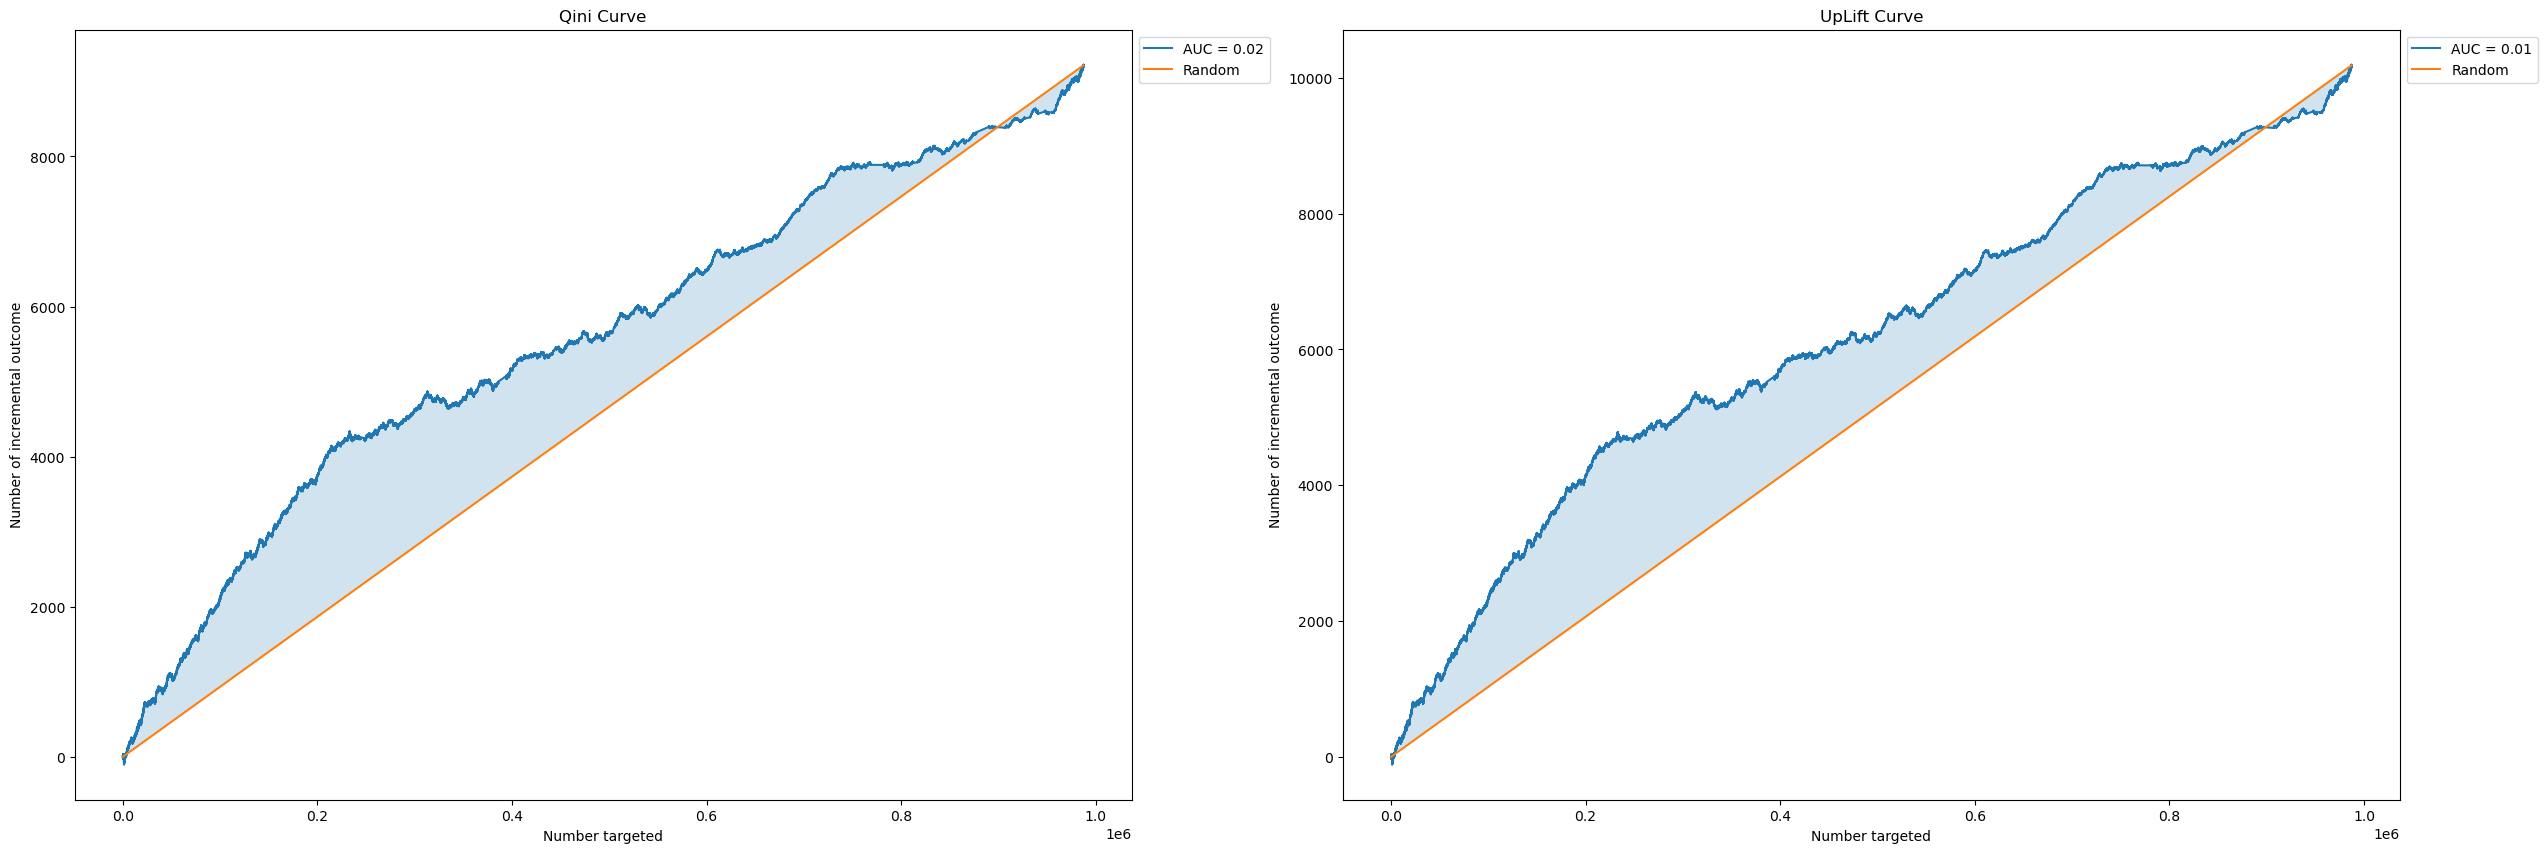

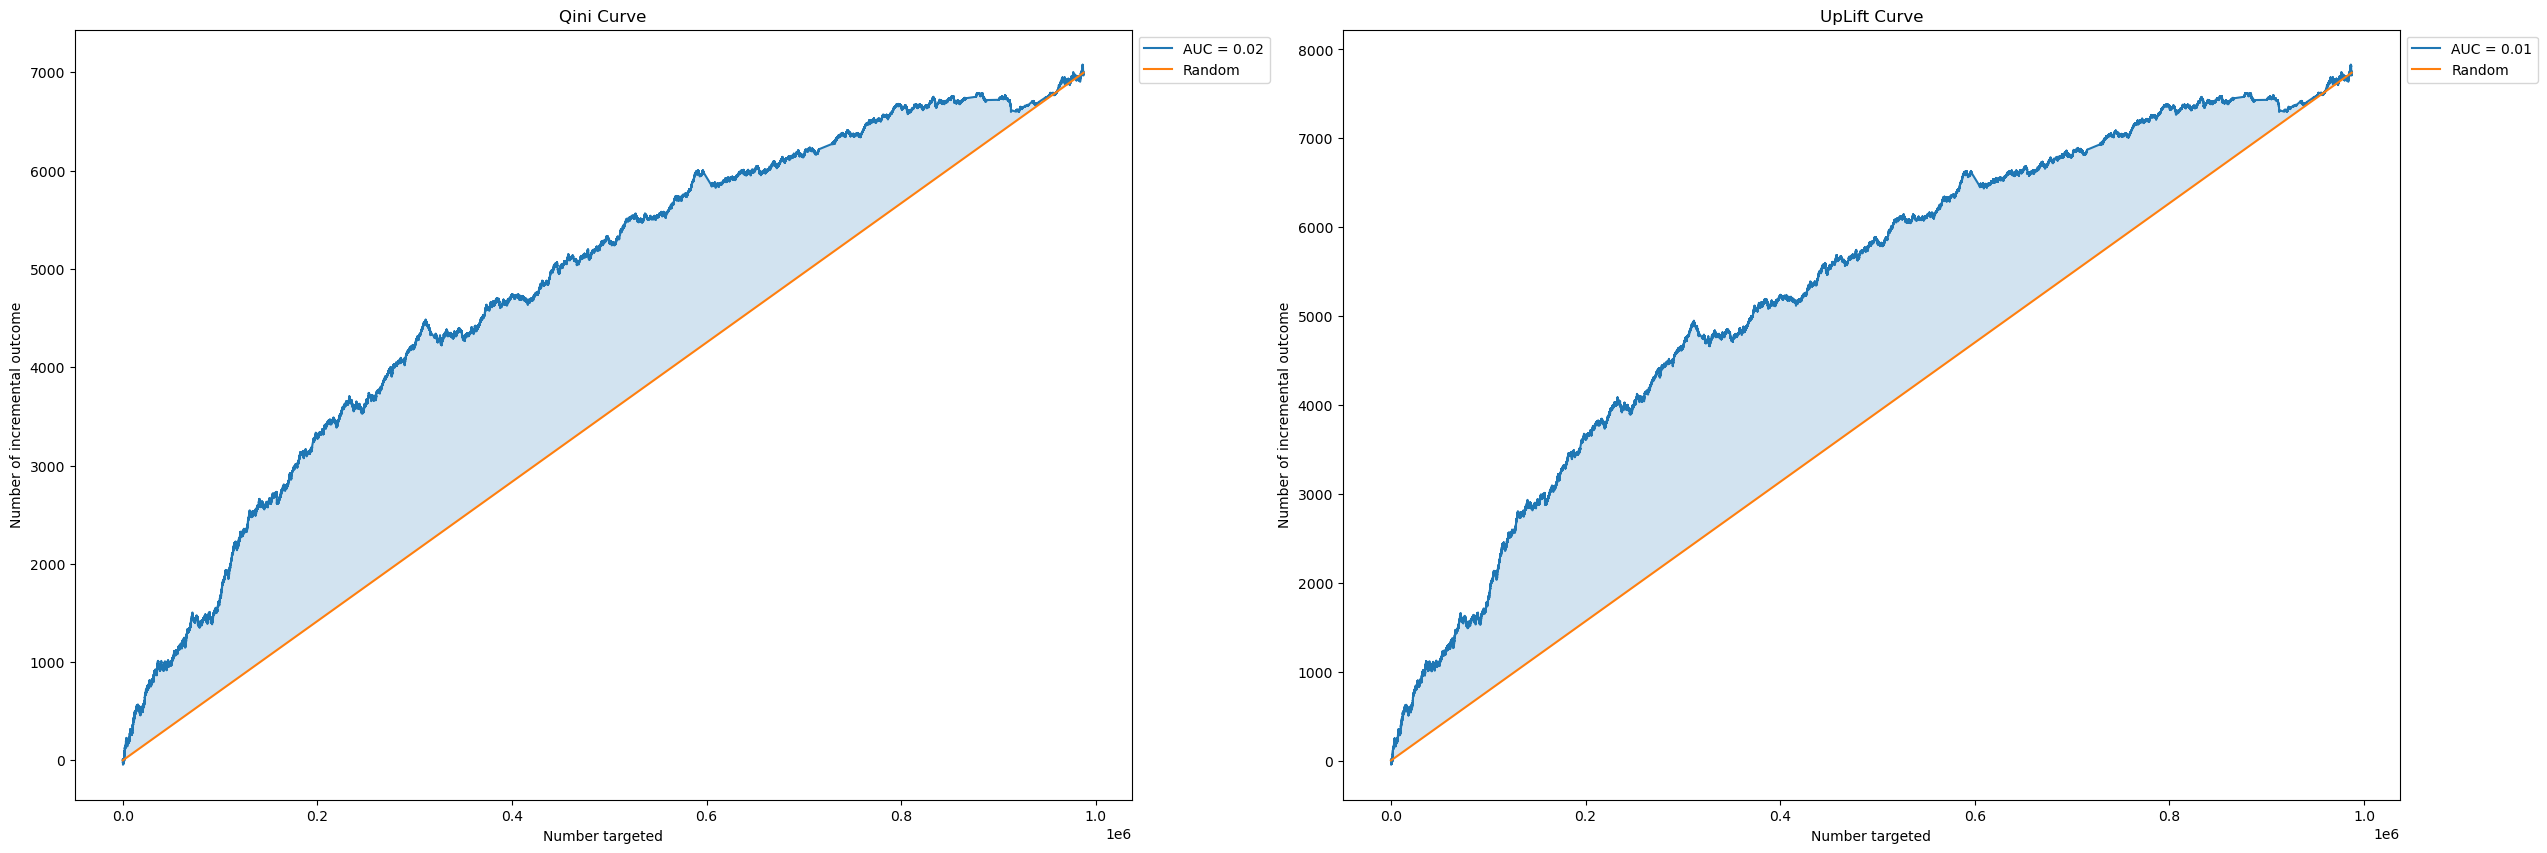

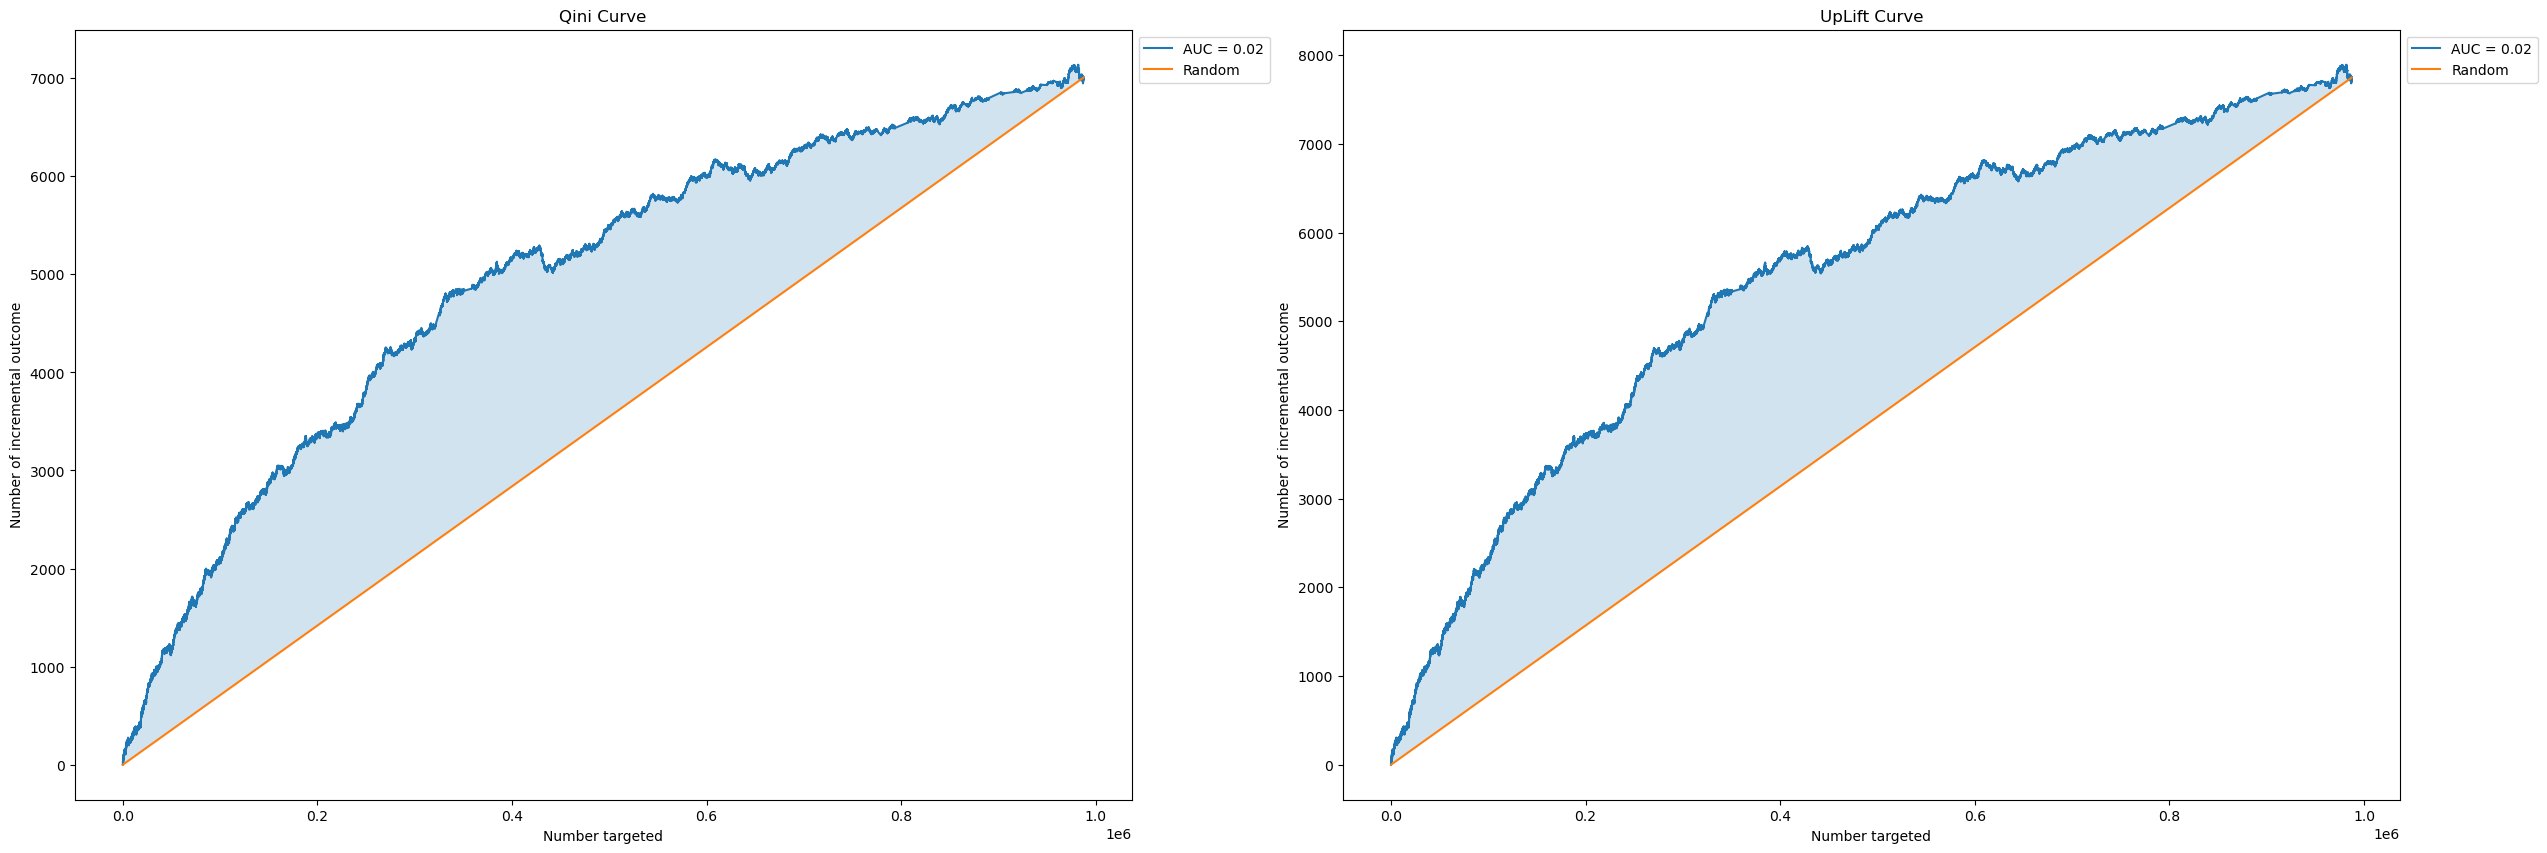

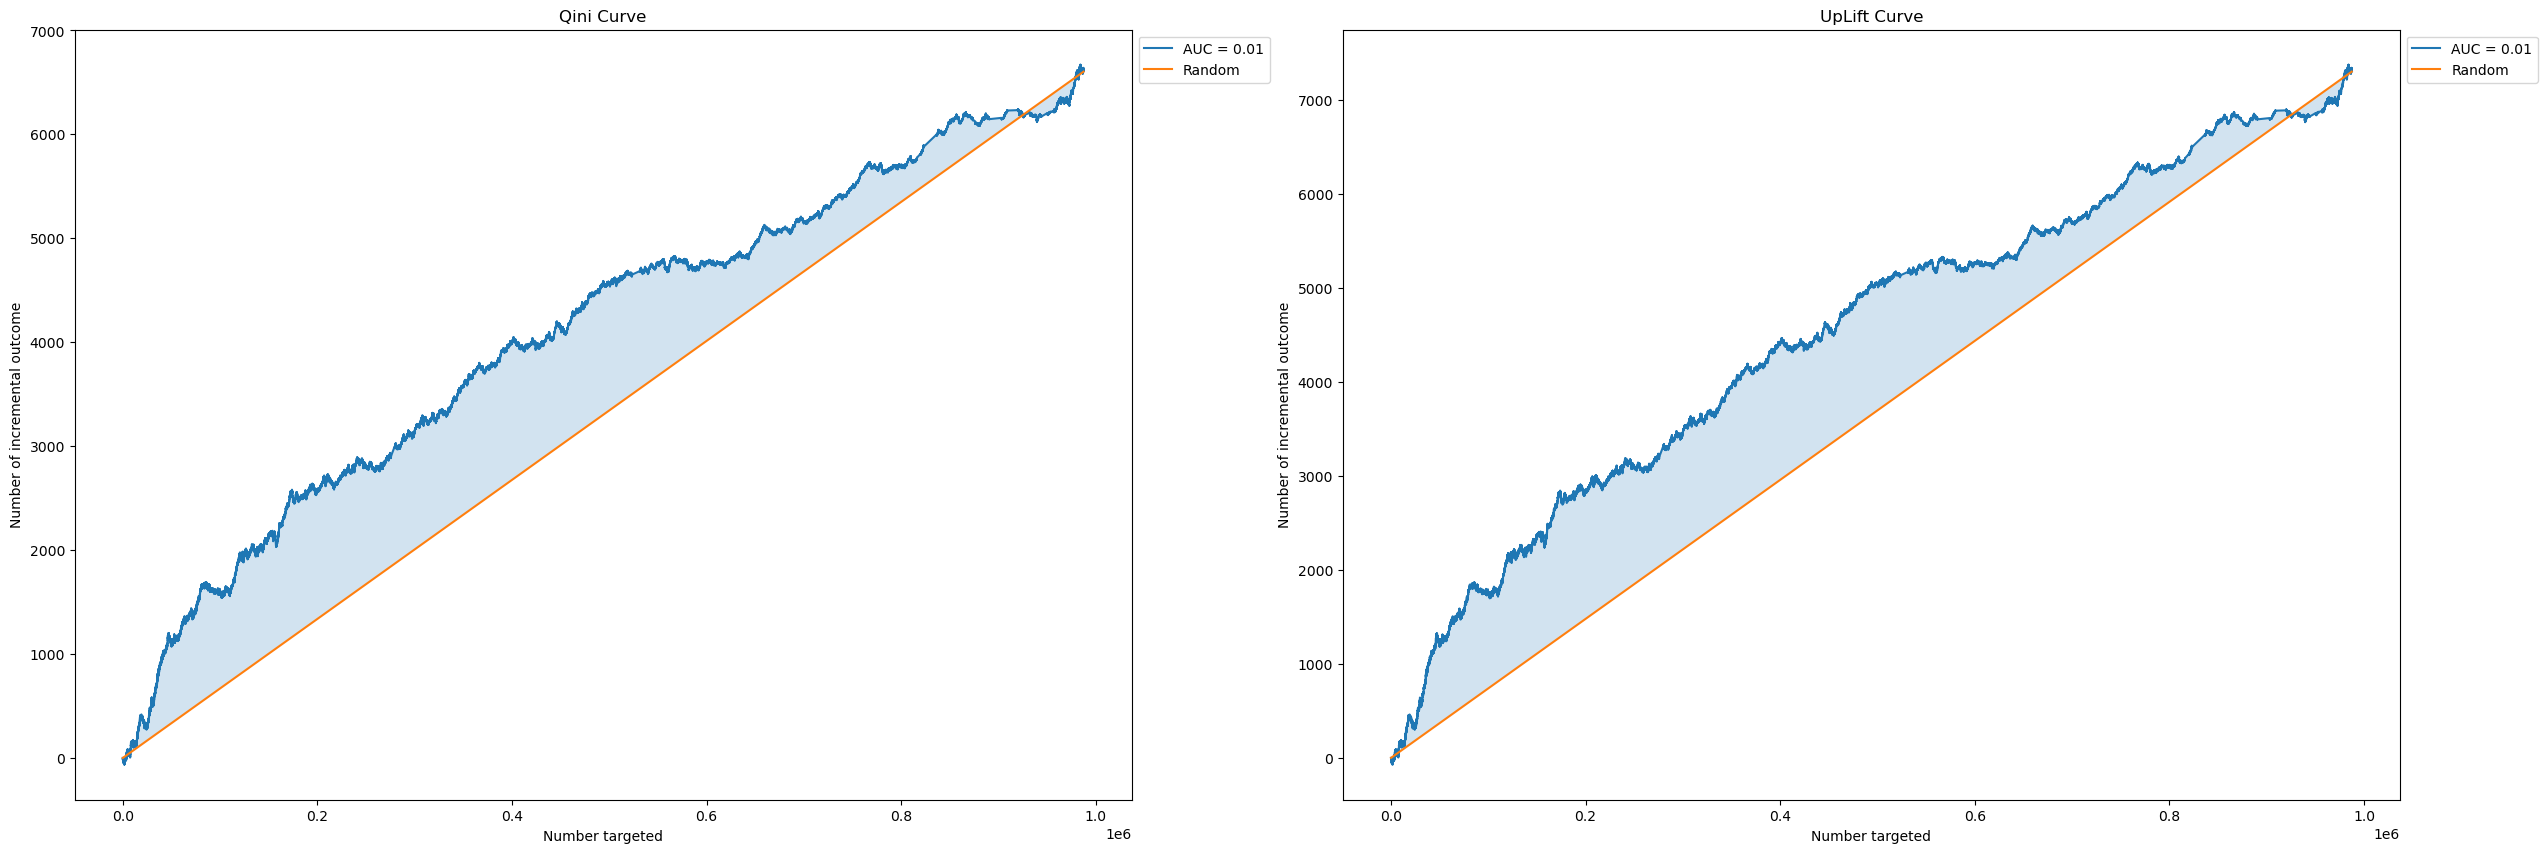

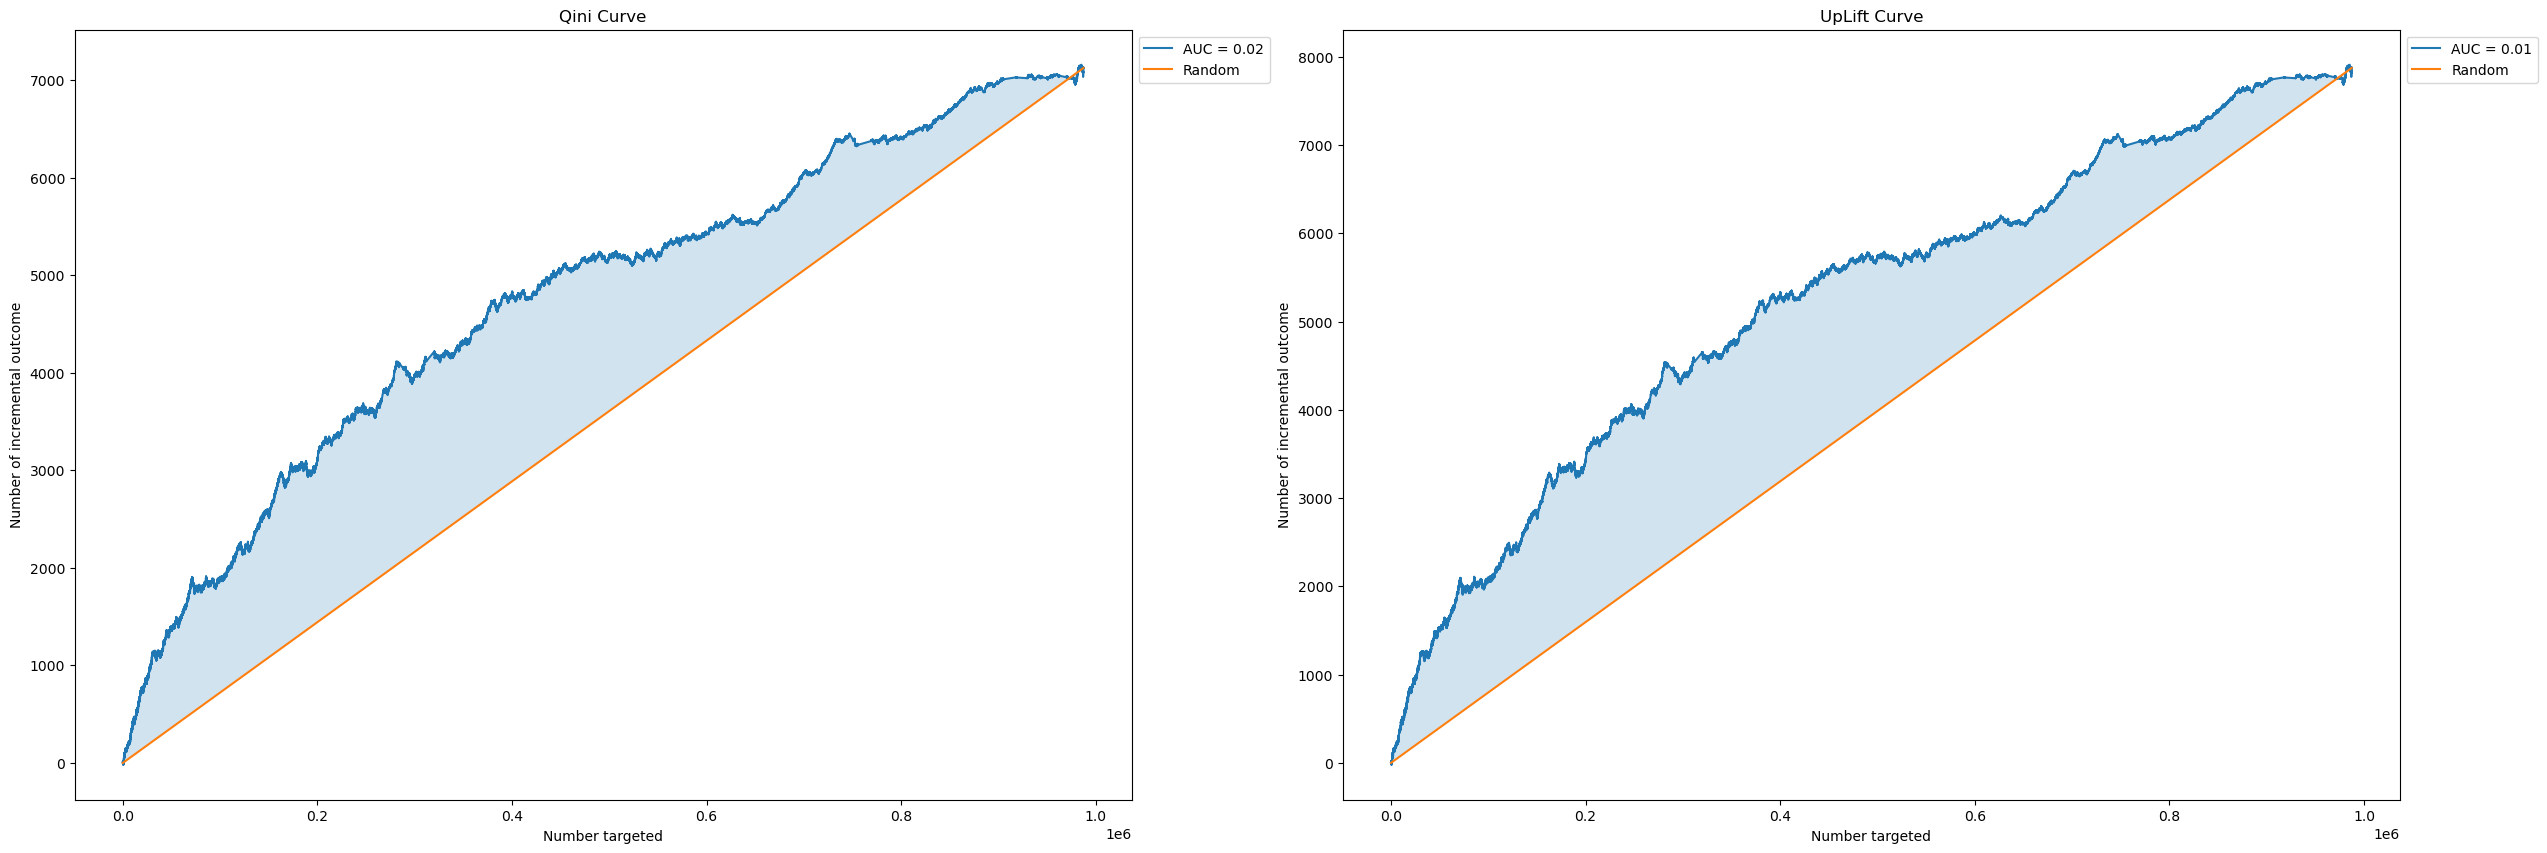

In [20]:
#Default data
skf = StratifiedKFold(n_splits=5, random_state= 42, shuffle=True)
skf.get_n_splits(X, y)
metrics = {'uplift_k_group':[],  'uplift_k_overall':[], 'qini_score':[], 'uplift_score':[]}
i = 0


for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      catboost_clf = CatBoostClassifier(verbose = 0)
      clf = SoloModel(estimator=catboost_clf)
      clf.fit(X_train_, y_train_, treatment = treat[train_index])
      y_pred = clf.predict(X_test_)
      del clf
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      uplift_overall, uplift_group, qini_score, uplift_score = get_report(y_test_, treat[test_index], y_pred, f"Plots/One model Split {i}.png")
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      metrics[ 'qini_score'].append(qini_score)
      metrics['uplift_score'].append(uplift_score)
      i += 1
    
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

In [21]:
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

UpLift at 30%: overall - 0.015, grouped - 0.0161.
Qini AUC Score: 0.0196; UpLift AUC Score: 0.0123


In [22]:
gc.collect()

38835

In [23]:
del X_data
del Y_data
del X
del treat
del df
del y
gc.collect()

0

# Метод двух моделей

In [24]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte']  + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
display(X_data.head()) 
display(Y_data.head()) 
treat = Y_data.treat.values
X = X_data.values
y = Y_data.target.values
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt







C:\Users\Kirill\AppData\Local\Temp\ipykernel_5664\2950636222.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv(r'uplift_dataset.zip'


var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7725915336    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725915337    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725915364    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7725915373    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7725915376    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7725915336    0.0     0.0     1.0     1.0     0.0     1.0     0.0     0.0   
7725915337    0.0     0.0     1.0     1.0     0.0     1.0     0.0     0.0   
7725915364    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   
7725915373    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   
7725915376    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7725915336     1.0    0.36 -1.142168 -0.584185 -0.948573 -0.691940 -0.584185   
7725915337     1.0    0.36 -1.142168 -0.584185 -0.948573 -0.691940 -0.584185   
7725915364     0.0    0.36 -0.203041  0.486727 -0.238421  1.219848  0.486727   
7725915373     0.0    0.36 -0.869518  0.631150  1.892033 -0.149537  0.631150   
7725915376     0.0    0.34  0.887558  0.132387  0.471730 -0.052330  0.132387   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7725915336 -0.948573  0.937219 -0.568816 -0.492042 -0.358016 -0.105294   
7725915337 -0.948573  0.937219 -0.568816 -0.492042 -0.358016 -0.105294   
7725915364 -0.238421  0.334366 -0.568816 -0.492042  2.139214 -0.105294   
7725915373  1.892033  0.575507  1.334204  0.881612  0.264101  0.390701   
7725915376  0.471730  1.049378  1.180284  1.776377 -0.007528 -0.105294   

              var_30    var_31    var_32    var_33    var_34    var_35  \
7725915336  1.121290 -0.594659 -0.071611 -0.595567 -0.071611 -0.595567   
7725915337  1.121290 -0.594659 -0.071611 -0.595567 -0.071611 -0.595567   
7725915364 -0.373339 -0.594659  3.453093  0.462552  3.453093  0.462552   
7725915373  0.523438  1.345352 -0.071611  0.722441 -0.071611  0.722441   
7725915376  1.121290  1.345352 -0.071611  0.146973 -0.071611  0.146973   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7725915336 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915337 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915364 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915373  2.010156  0.004130  0.711746  0.812655  0.459654  2.000484   
7725915376  1.795316  0.245265  0.711746 -0.147910 -0.174913 -0.287372   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7725915336 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915337 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915364 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915373  1.738082  0.071780  0.977076 -2.627860  0.266733 -1.271727   
7725915376  1.738082  0.363994  0.977076  0.273855  0.130364  0.210894   

              var_48    var_49    var_50  
7725915336  0.000000  0.000000  0.000000  
7725915337  0.000000  0.000000  0.000000  
7725915364  0.000000  0.000000  0.000000  
7725915373  0.344958  0.040854  0.326157  
7725915376  0.228310  0.000000  0.228310

target  treat
7725915336       0      1
7725915337       0      0
7725915364       0      1
7725915373       0      1
7725915376       0      1

UpLift at 30%: overall - 0.014423, grouped - 0.014285.
Qini AUC Score: 0.005681; UpLift AUC Score: 0.003585
UpLift at 30%: overall - 0.014139, grouped - 0.014569.
Qini AUC Score: 0.016143; UpLift AUC Score: 0.010196
UpLift at 30%: overall - 0.013856, grouped - 0.01417.
Qini AUC Score: 0.012788; UpLift AUC Score: 0.008089
UpLift at 30%: overall - 0.0115, grouped - 0.012419.
Qini AUC Score: 0.014498; UpLift AUC Score: 0.009185
UpLift at 30%: overall - 0.013007, grouped - 0.013213.
Qini AUC Score: 0.017462; UpLift AUC Score: 0.011064
UpLift at 30%: overall - 0.0134, grouped - 0.0137.
Qini AUC Score: 0.0133; UpLift AUC Score: 0.0084


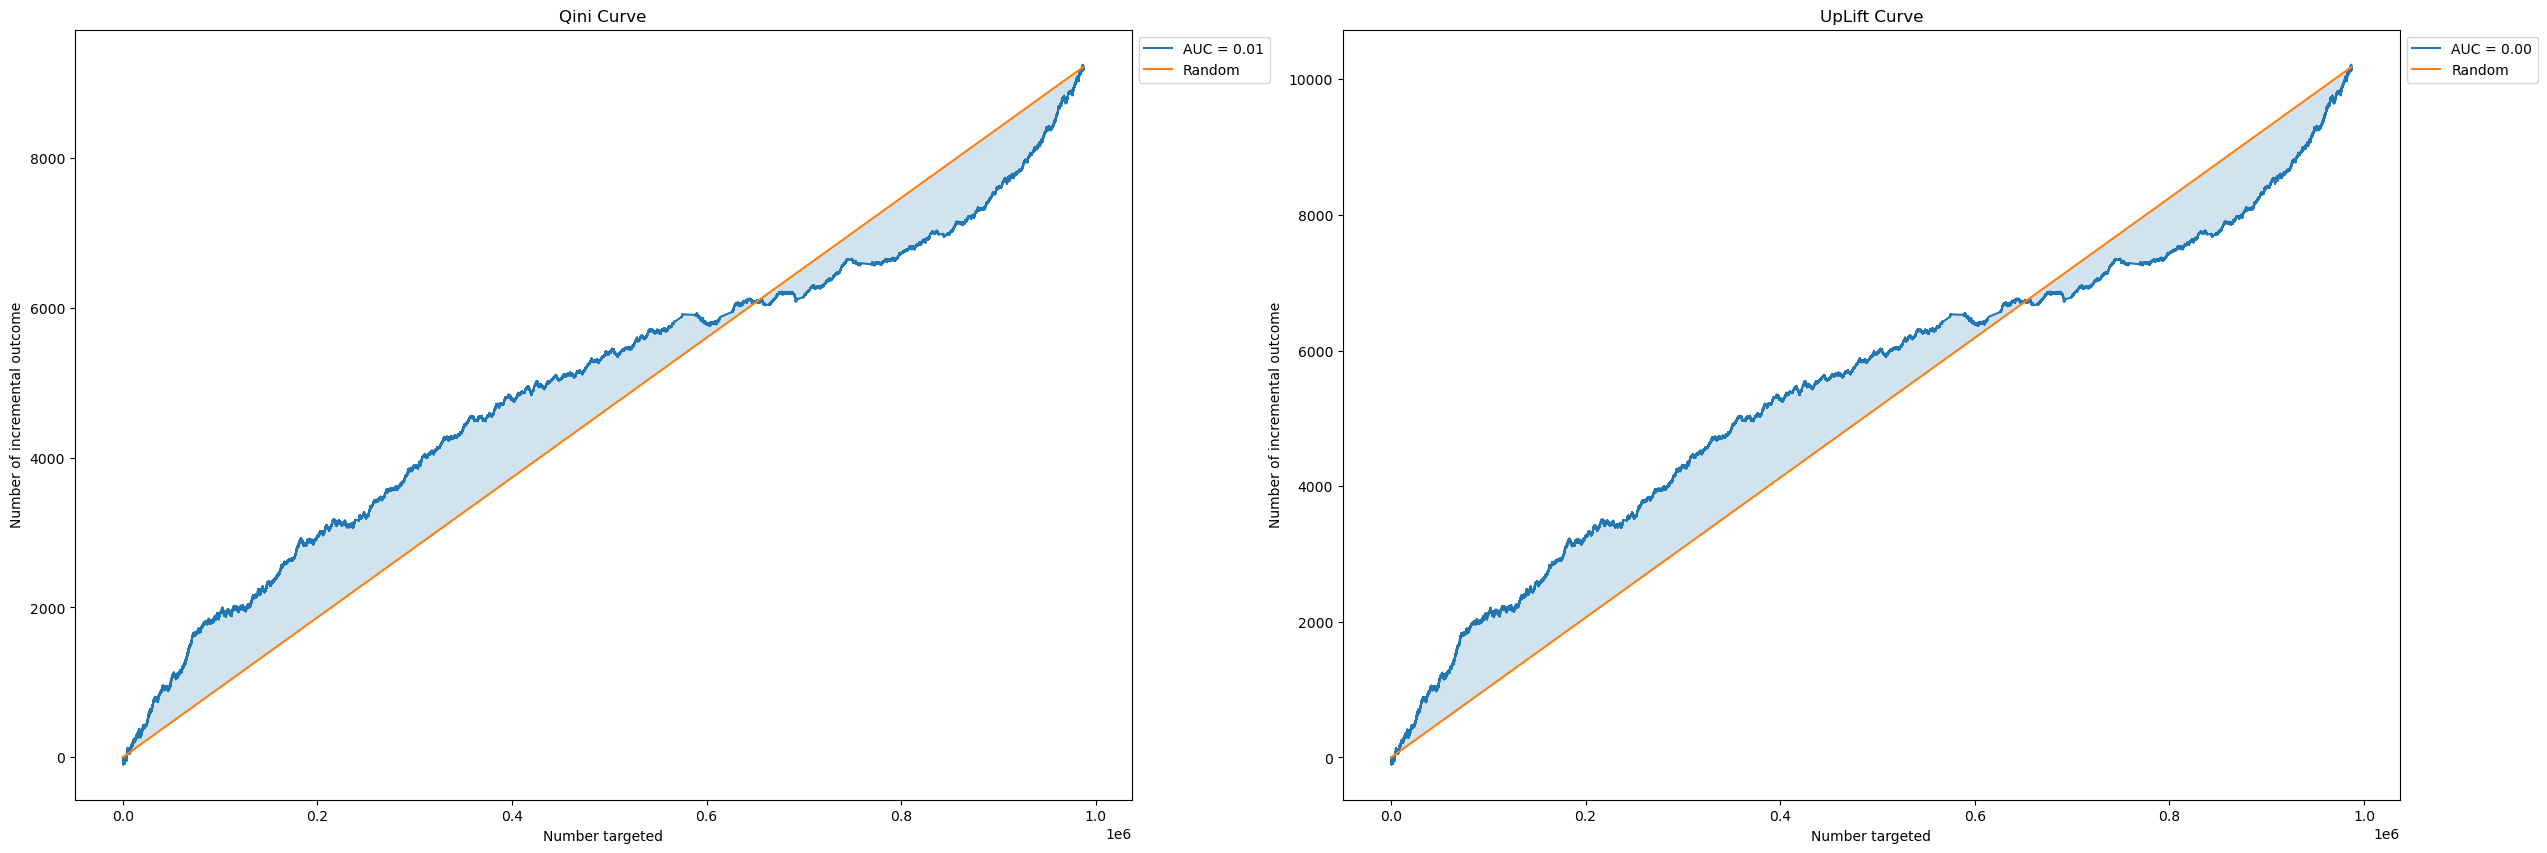

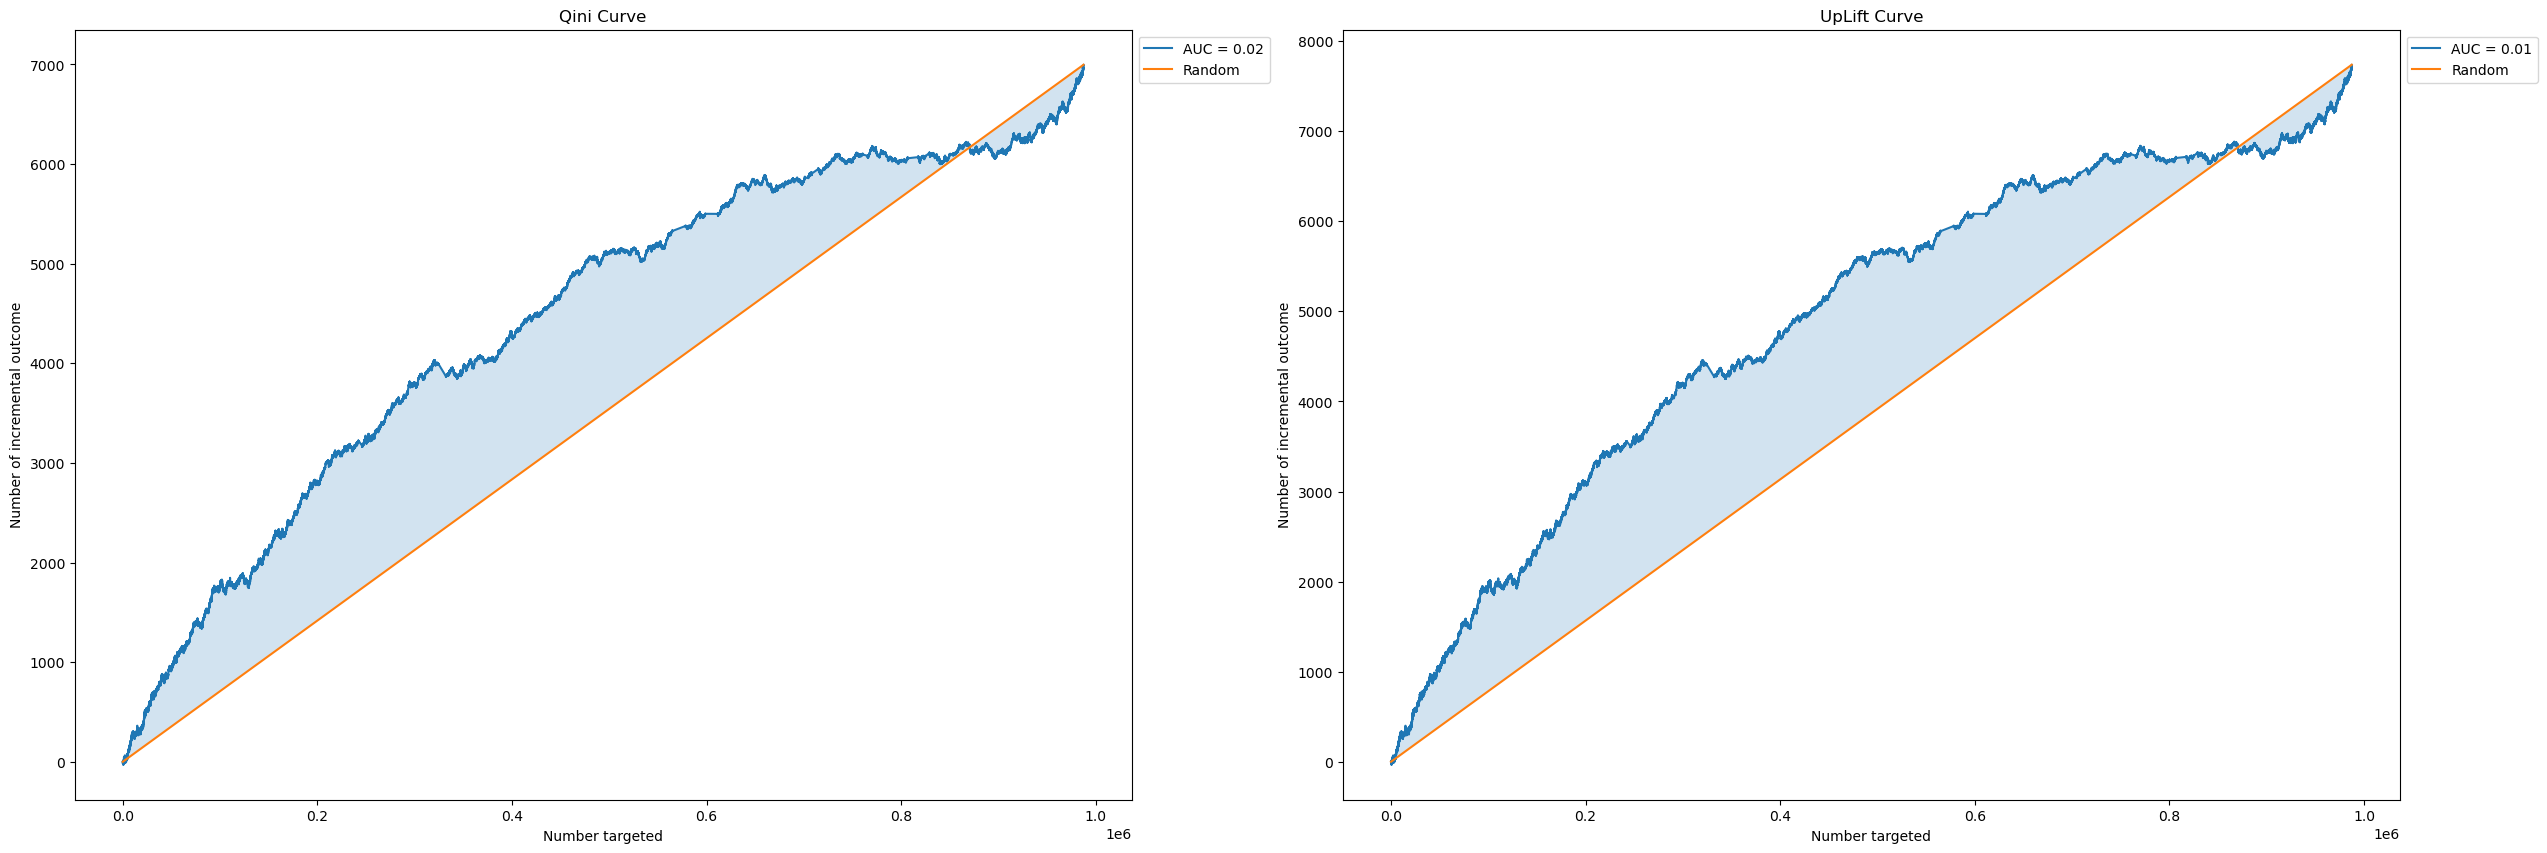

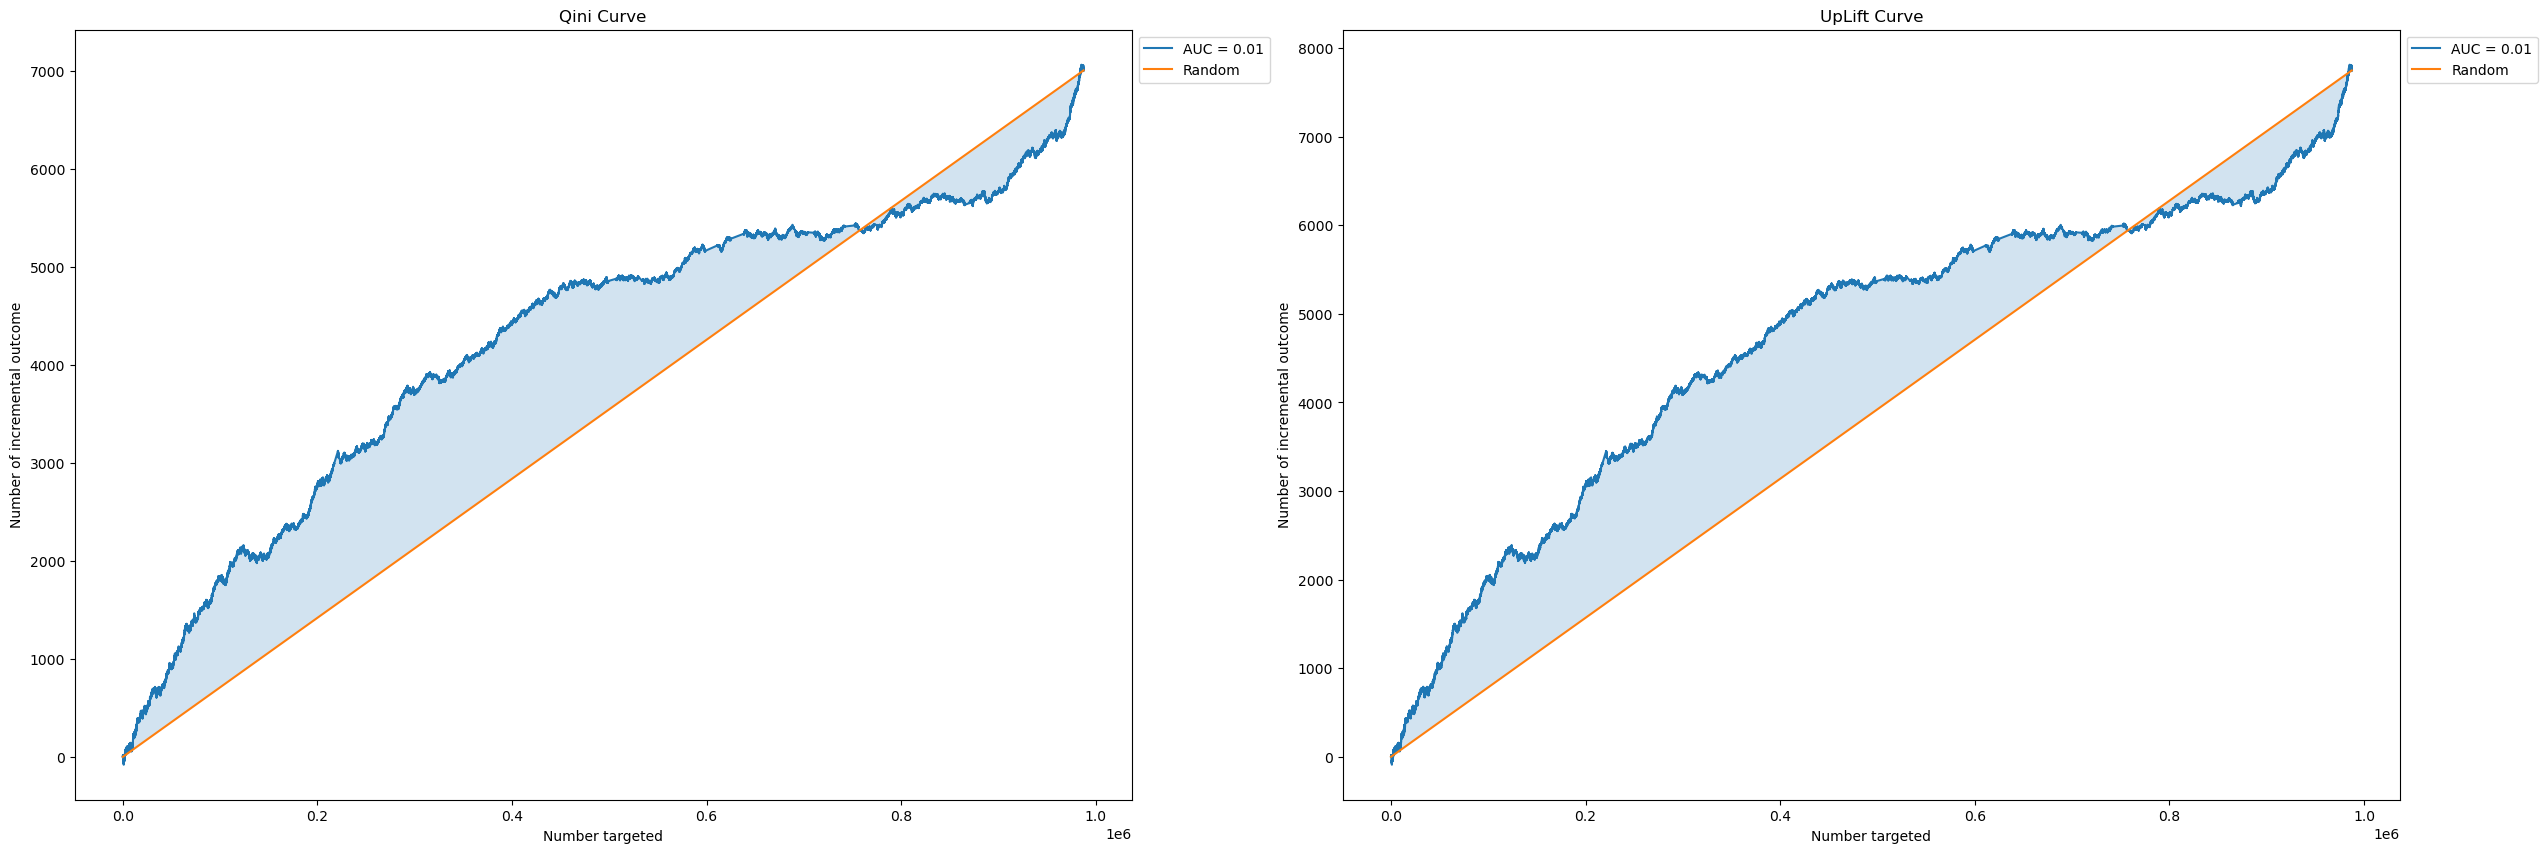

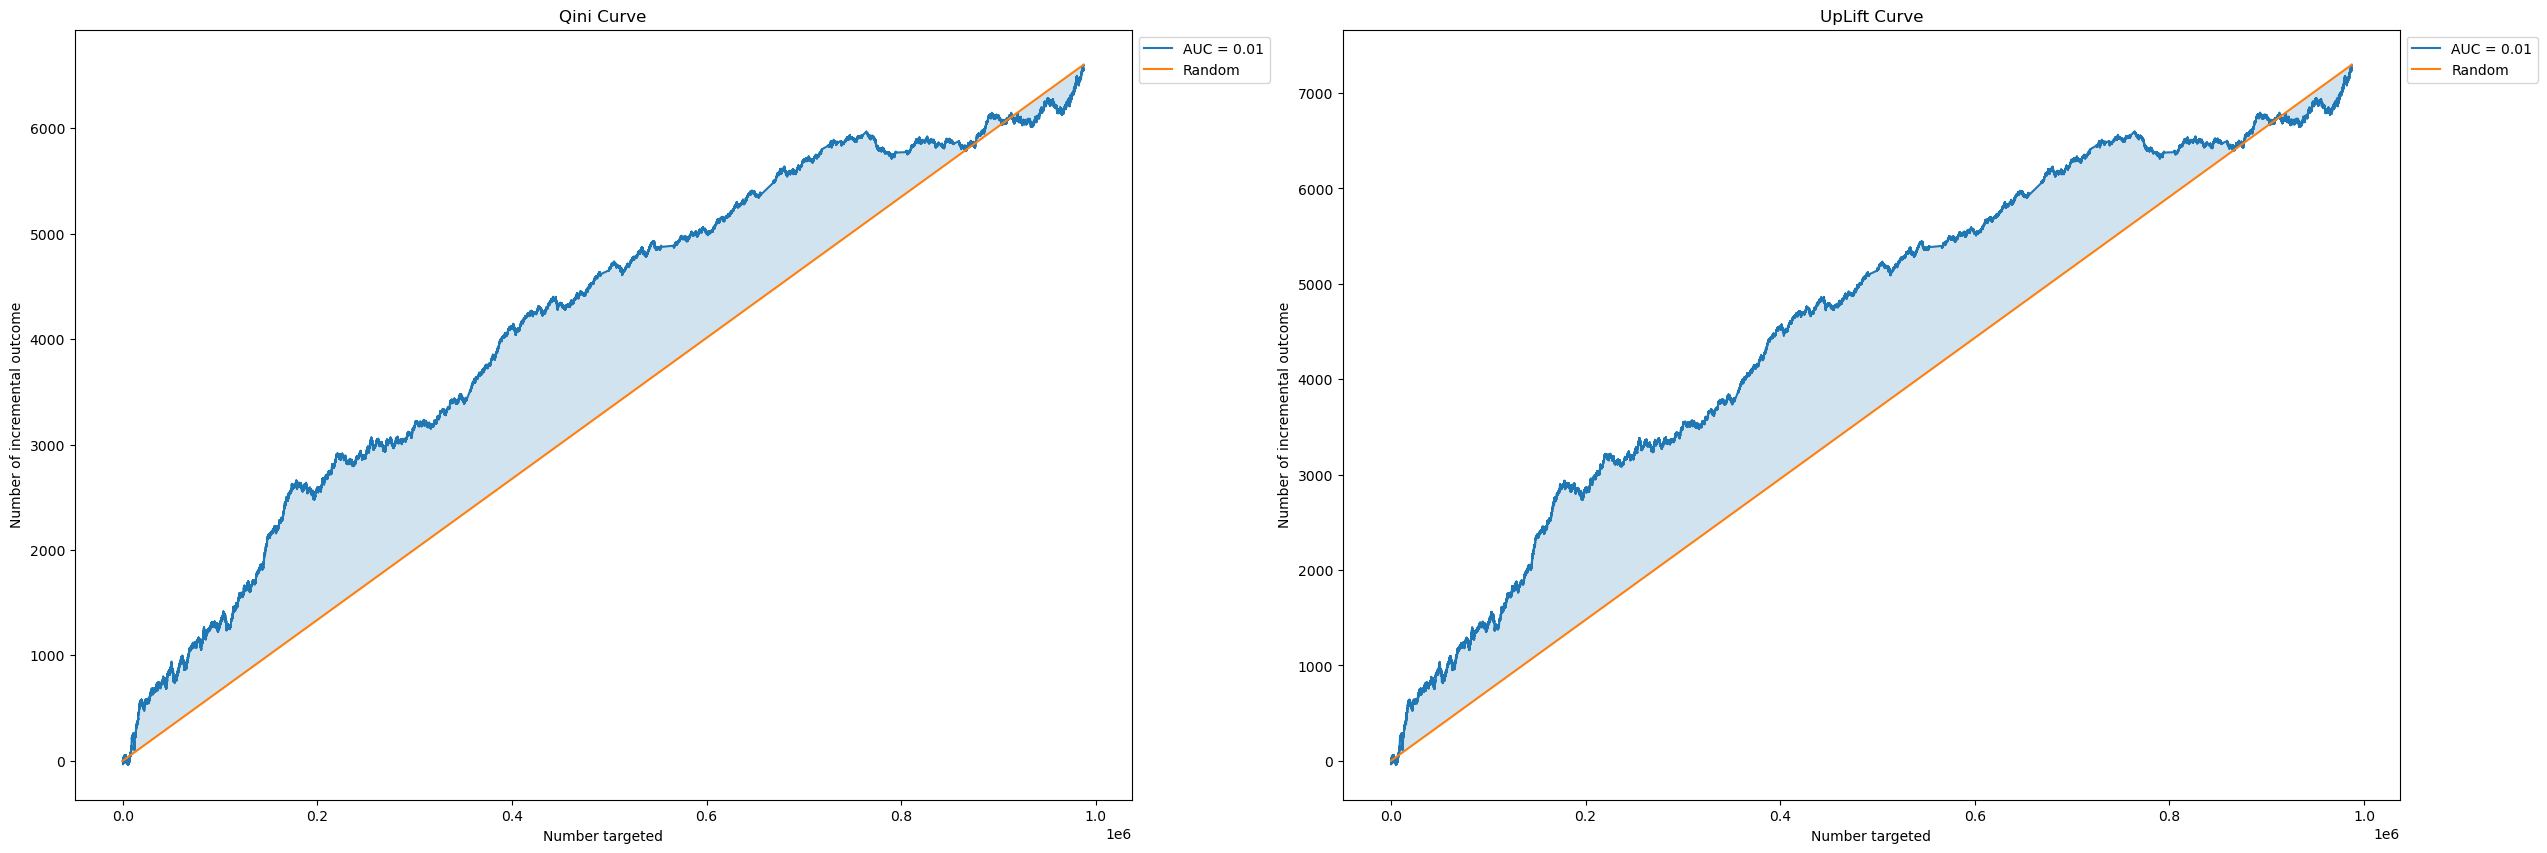

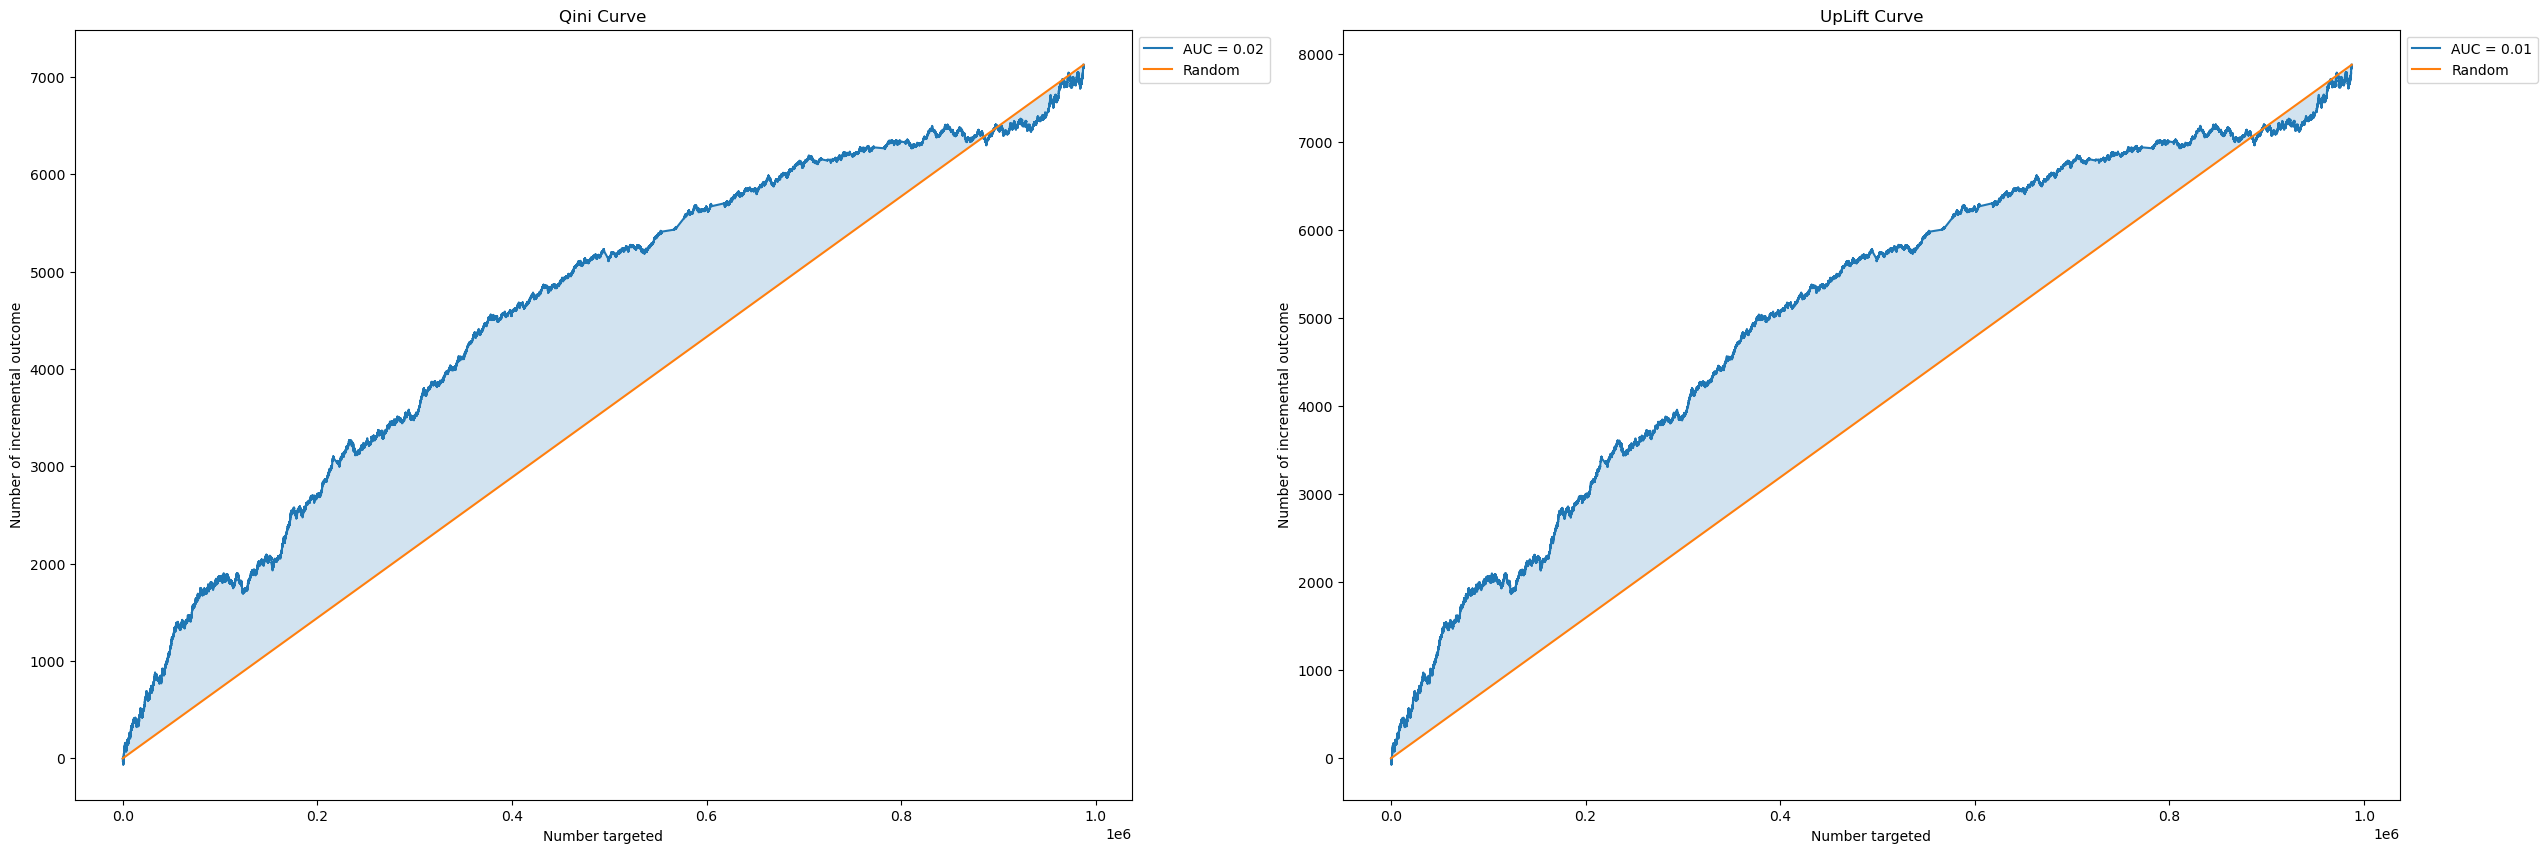

In [25]:
#Default data
skf = StratifiedKFold(n_splits=5, random_state= 42, shuffle=True)
skf.get_n_splits(X, y)
metrics = {'uplift_k_group':[],  'uplift_k_overall':[], 'qini_score':[], 'uplift_score':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      catboost_clf0 = CatBoostClassifier(verbose = 0)
      catboost_clf1 = CatBoostClassifier(verbose = 0)
      clf = TwoModels(estimator_ctrl= catboost_clf0, estimator_trmnt=catboost_clf1)
      clf.fit(X_train_, y_train_, treatment = treat[train_index])
      y_pred = clf.predict(X_test_)
      del catboost_clf0
      del catboost_clf1
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      uplift_overall, uplift_group, qini_score, uplift_score = get_report(y_test_, treat[test_index], y_pred, f"Plots/Two models Split {i}.png")
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      metrics[ 'qini_score'].append(qini_score)
      metrics['uplift_score'].append(uplift_score)
      i += 1



uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

In [26]:
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

UpLift at 30%: overall - 0.0134, grouped - 0.0137.
Qini AUC Score: 0.0133; UpLift AUC Score: 0.0084


In [27]:
del X_data
del Y_data
del X
del treat
del df
del y
gc.collect()

38707

# Метод трансформации класса (Классификация)

In [28]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte']  + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
treat = Y_data.treat.values
X = X_data.values
y = Y_data.target.values
p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt
print(p)






C:\Users\Kirill\AppData\Local\Temp\ipykernel_5664\591216625.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv(r'uplift_dataset.zip'


var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7725915336    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725915337    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725915364    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7725915373    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7725915376    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7725915336    0.0     0.0     1.0     1.0     0.0     1.0     0.0     0.0   
7725915337    0.0     0.0     1.0     1.0     0.0     1.0     0.0     0.0   
7725915364    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   
7725915373    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   
7725915376    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7725915336     1.0    0.36 -1.142168 -0.584185 -0.948573 -0.691940 -0.584185   
7725915337     1.0    0.36 -1.142168 -0.584185 -0.948573 -0.691940 -0.584185   
7725915364     0.0    0.36 -0.203041  0.486727 -0.238421  1.219848  0.486727   
7725915373     0.0    0.36 -0.869518  0.631150  1.892033 -0.149537  0.631150   
7725915376     0.0    0.34  0.887558  0.132387  0.471730 -0.052330  0.132387   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7725915336 -0.948573  0.937219 -0.568816 -0.492042 -0.358016 -0.105294   
7725915337 -0.948573  0.937219 -0.568816 -0.492042 -0.358016 -0.105294   
7725915364 -0.238421  0.334366 -0.568816 -0.492042  2.139214 -0.105294   
7725915373  1.892033  0.575507  1.334204  0.881612  0.264101  0.390701   
7725915376  0.471730  1.049378  1.180284  1.776377 -0.007528 -0.105294   

              var_30    var_31    var_32    var_33    var_34    var_35  \
7725915336  1.121290 -0.594659 -0.071611 -0.595567 -0.071611 -0.595567   
7725915337  1.121290 -0.594659 -0.071611 -0.595567 -0.071611 -0.595567   
7725915364 -0.373339 -0.594659  3.453093  0.462552  3.453093  0.462552   
7725915373  0.523438  1.345352 -0.071611  0.722441 -0.071611  0.722441   
7725915376  1.121290  1.345352 -0.071611  0.146973 -0.071611  0.146973   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7725915336 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915337 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915364 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915373  2.010156  0.004130  0.711746  0.812655  0.459654  2.000484   
7725915376  1.795316  0.245265  0.711746 -0.147910 -0.174913 -0.287372   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7725915336 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915337 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915364 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915373  1.738082  0.071780  0.977076 -2.627860  0.266733 -1.271727   
7725915376  1.738082  0.363994  0.977076  0.273855  0.130364  0.210894   

              var_48    var_49    var_50  
7725915336  0.000000  0.000000  0.000000  
7725915337  0.000000  0.000000  0.000000  
7725915364  0.000000  0.000000  0.000000  
7725915373  0.344958  0.040854  0.326157  
7725915376  0.228310  0.000000  0.228310

target  treat
7725915336       0      1
7725915337       0      0
7725915364       0      1
7725915373       0      1
7725915376       0      1

0.9045956538094344


UpLift at 30%: overall - 0.019609, grouped - 0.019456.
Qini AUC Score: 0.030839; UpLift AUC Score: 0.019451
UpLift at 30%: overall - 0.014698, grouped - 0.015121.
Qini AUC Score: 0.02463; UpLift AUC Score: 0.015583
UpLift at 30%: overall - 0.018142, grouped - 0.017891.
Qini AUC Score: 0.030788; UpLift AUC Score: 0.019517
UpLift at 30%: overall - 0.01351, grouped - 0.013643.
Qini AUC Score: 0.021176; UpLift AUC Score: 0.013447
UpLift at 30%: overall - 0.015643, grouped - 0.015447.
Qini AUC Score: 0.026824; UpLift AUC Score: 0.017037
UpLift at 30%: overall - 0.0163, grouped - 0.0163.
Qini AUC Score: 0.0269; UpLift AUC Score: 0.017


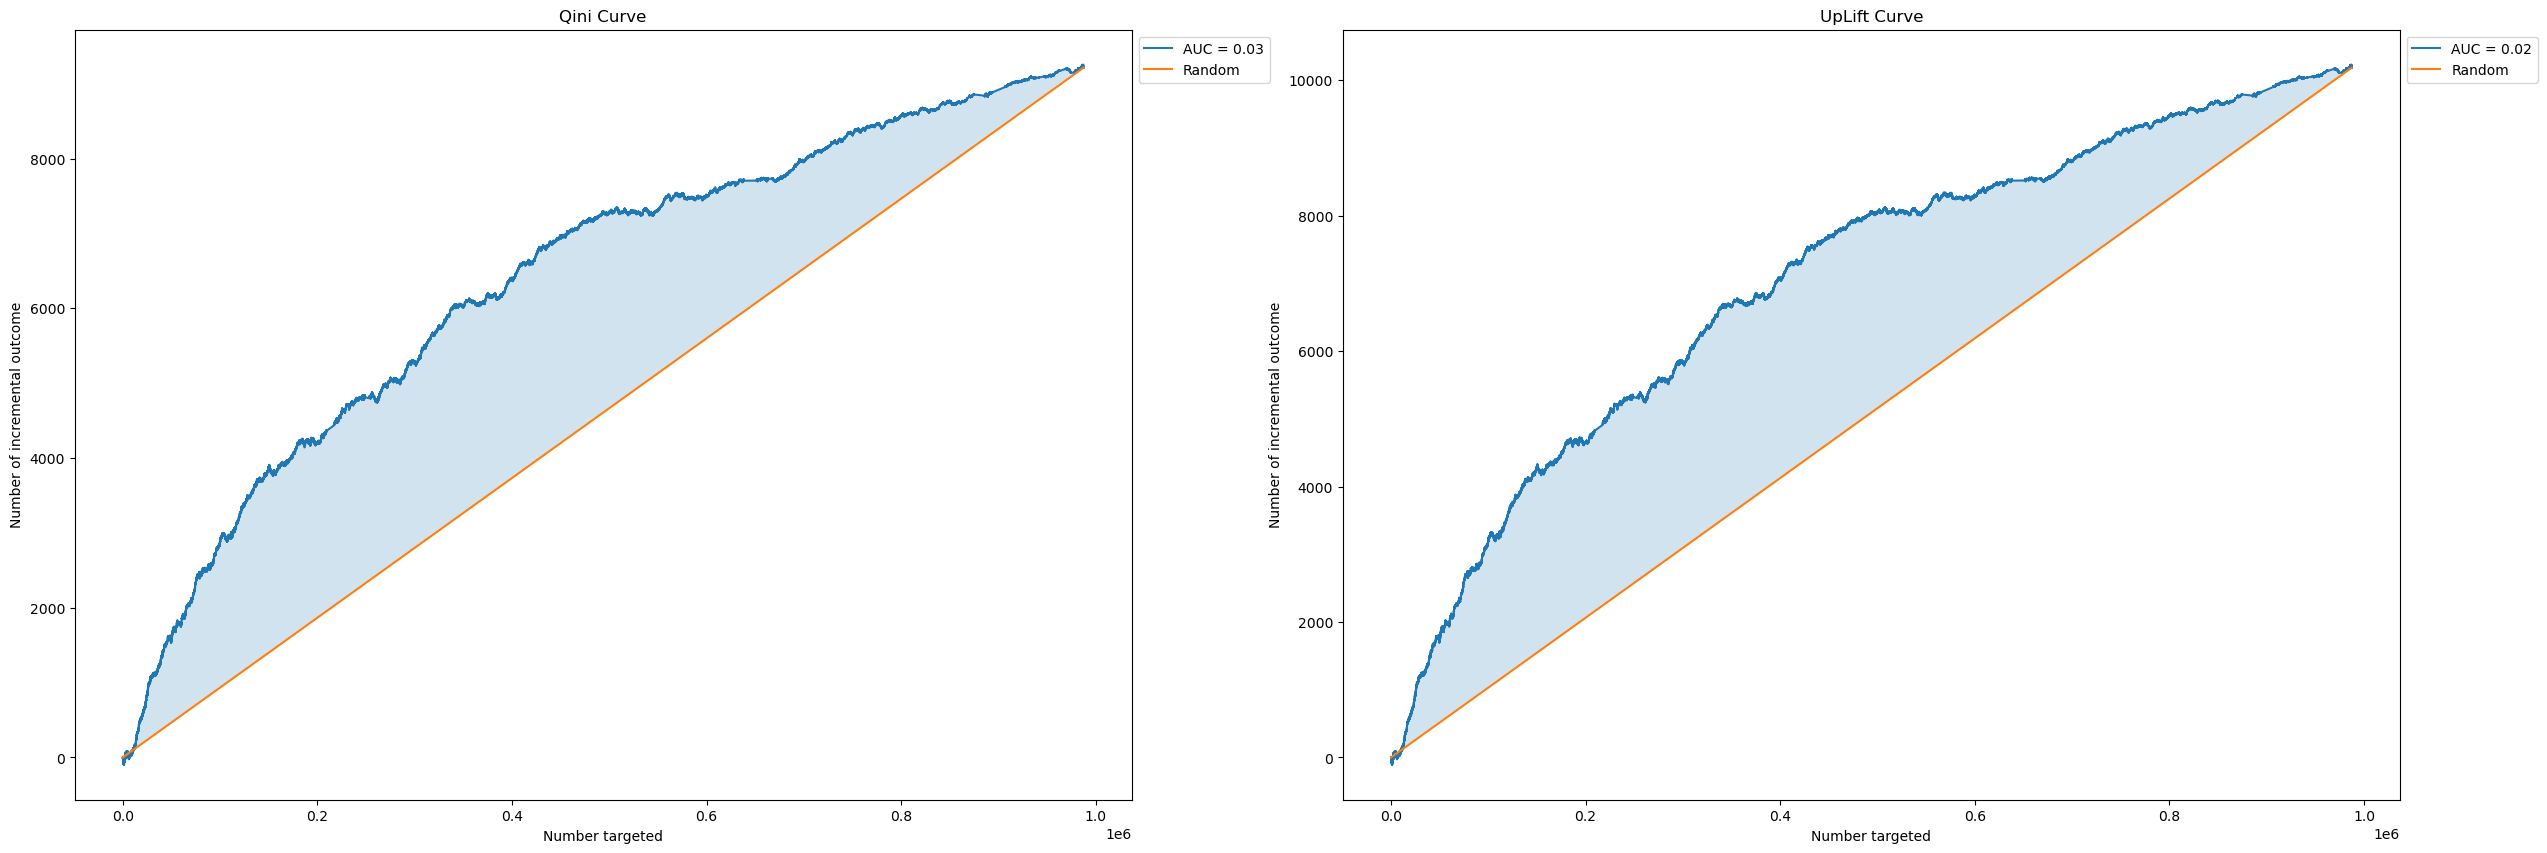

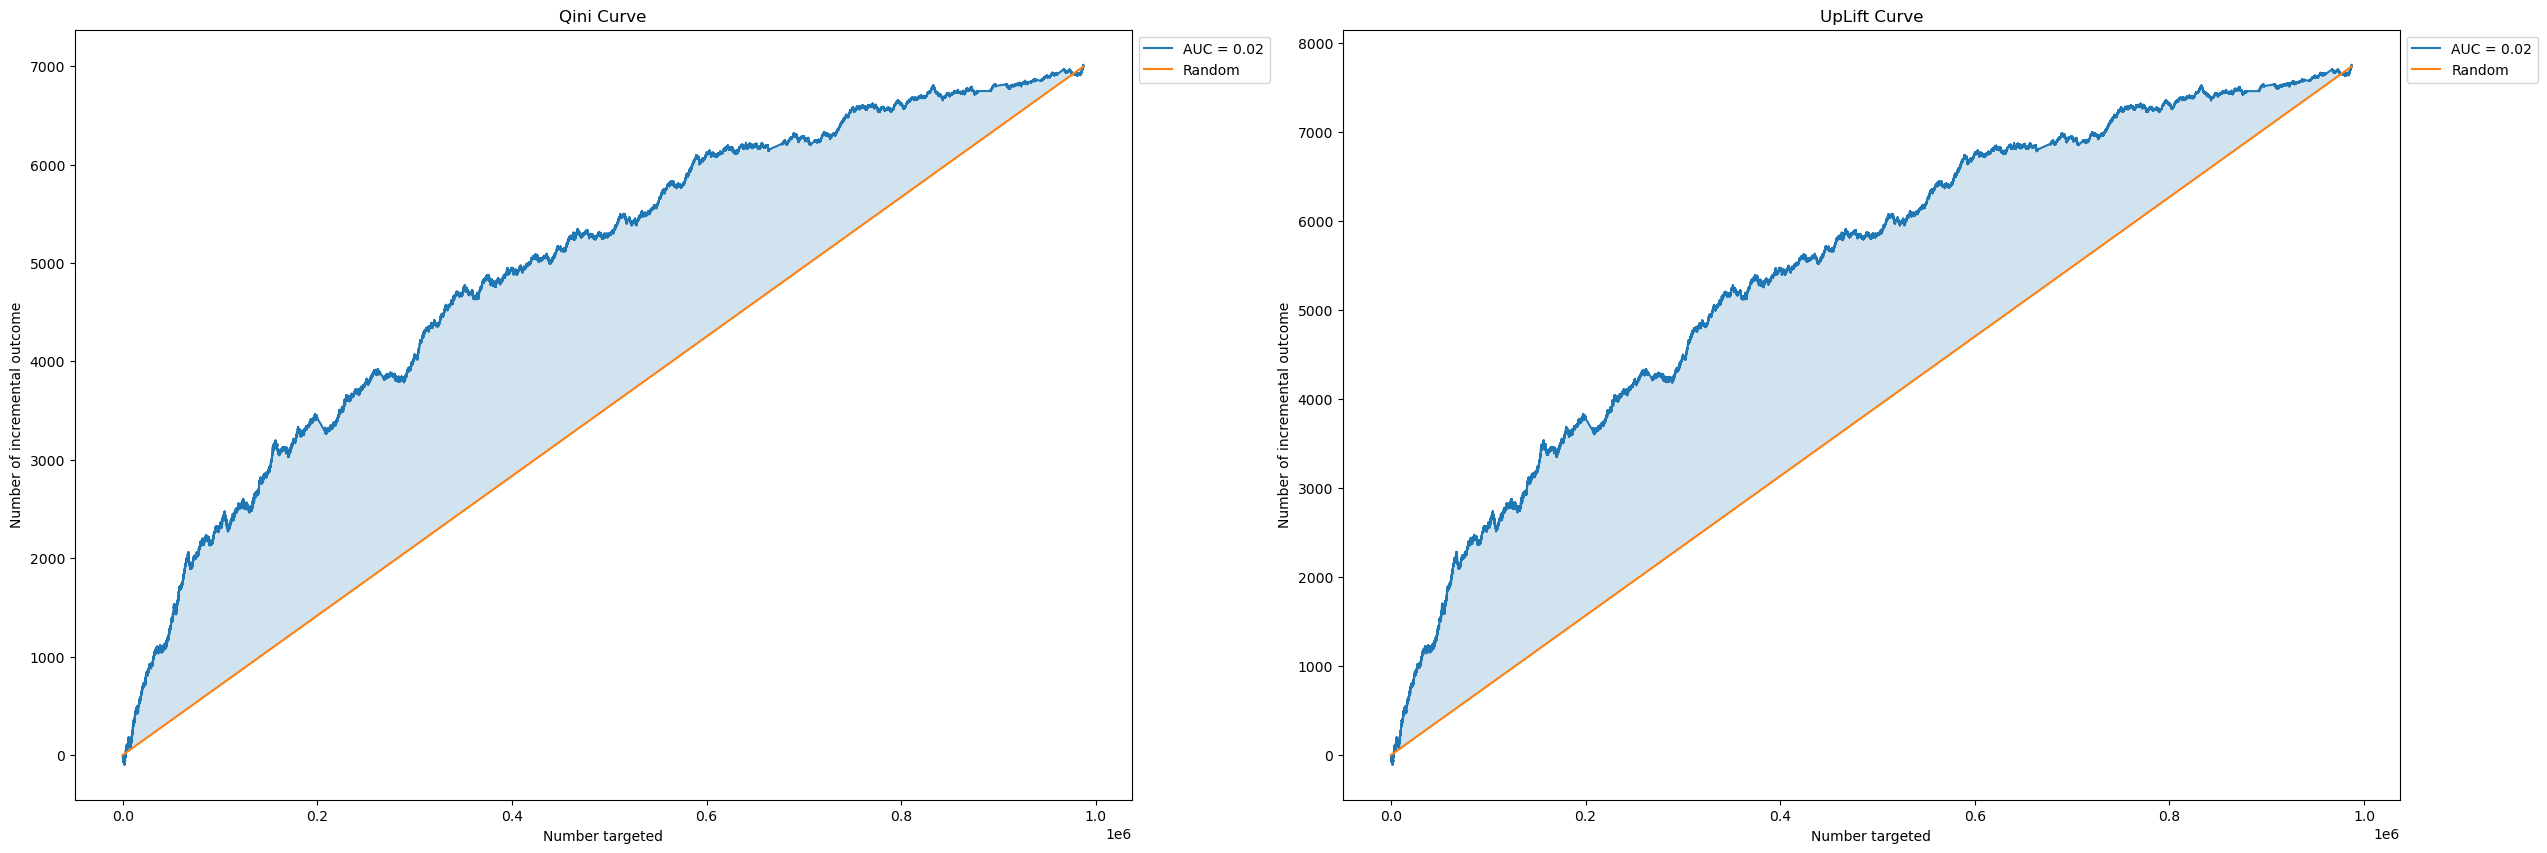

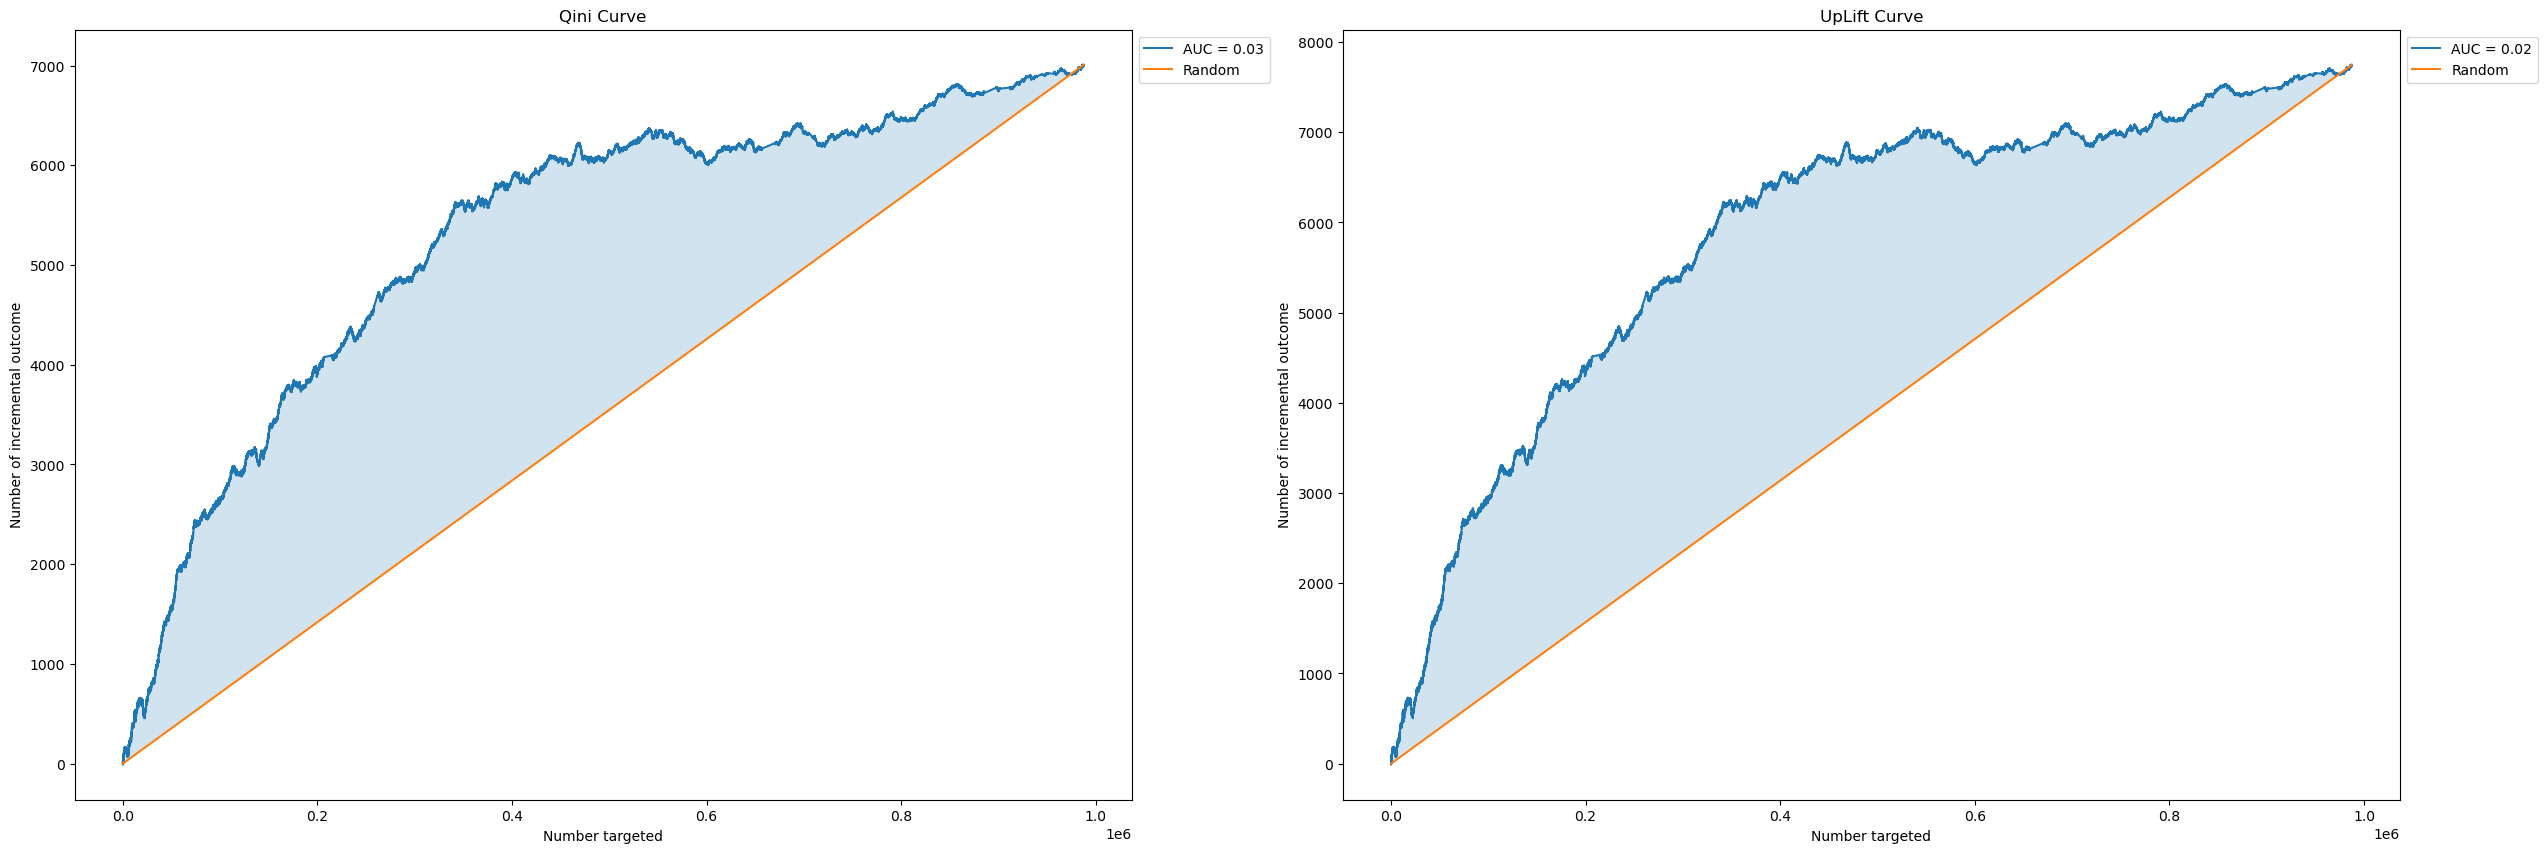

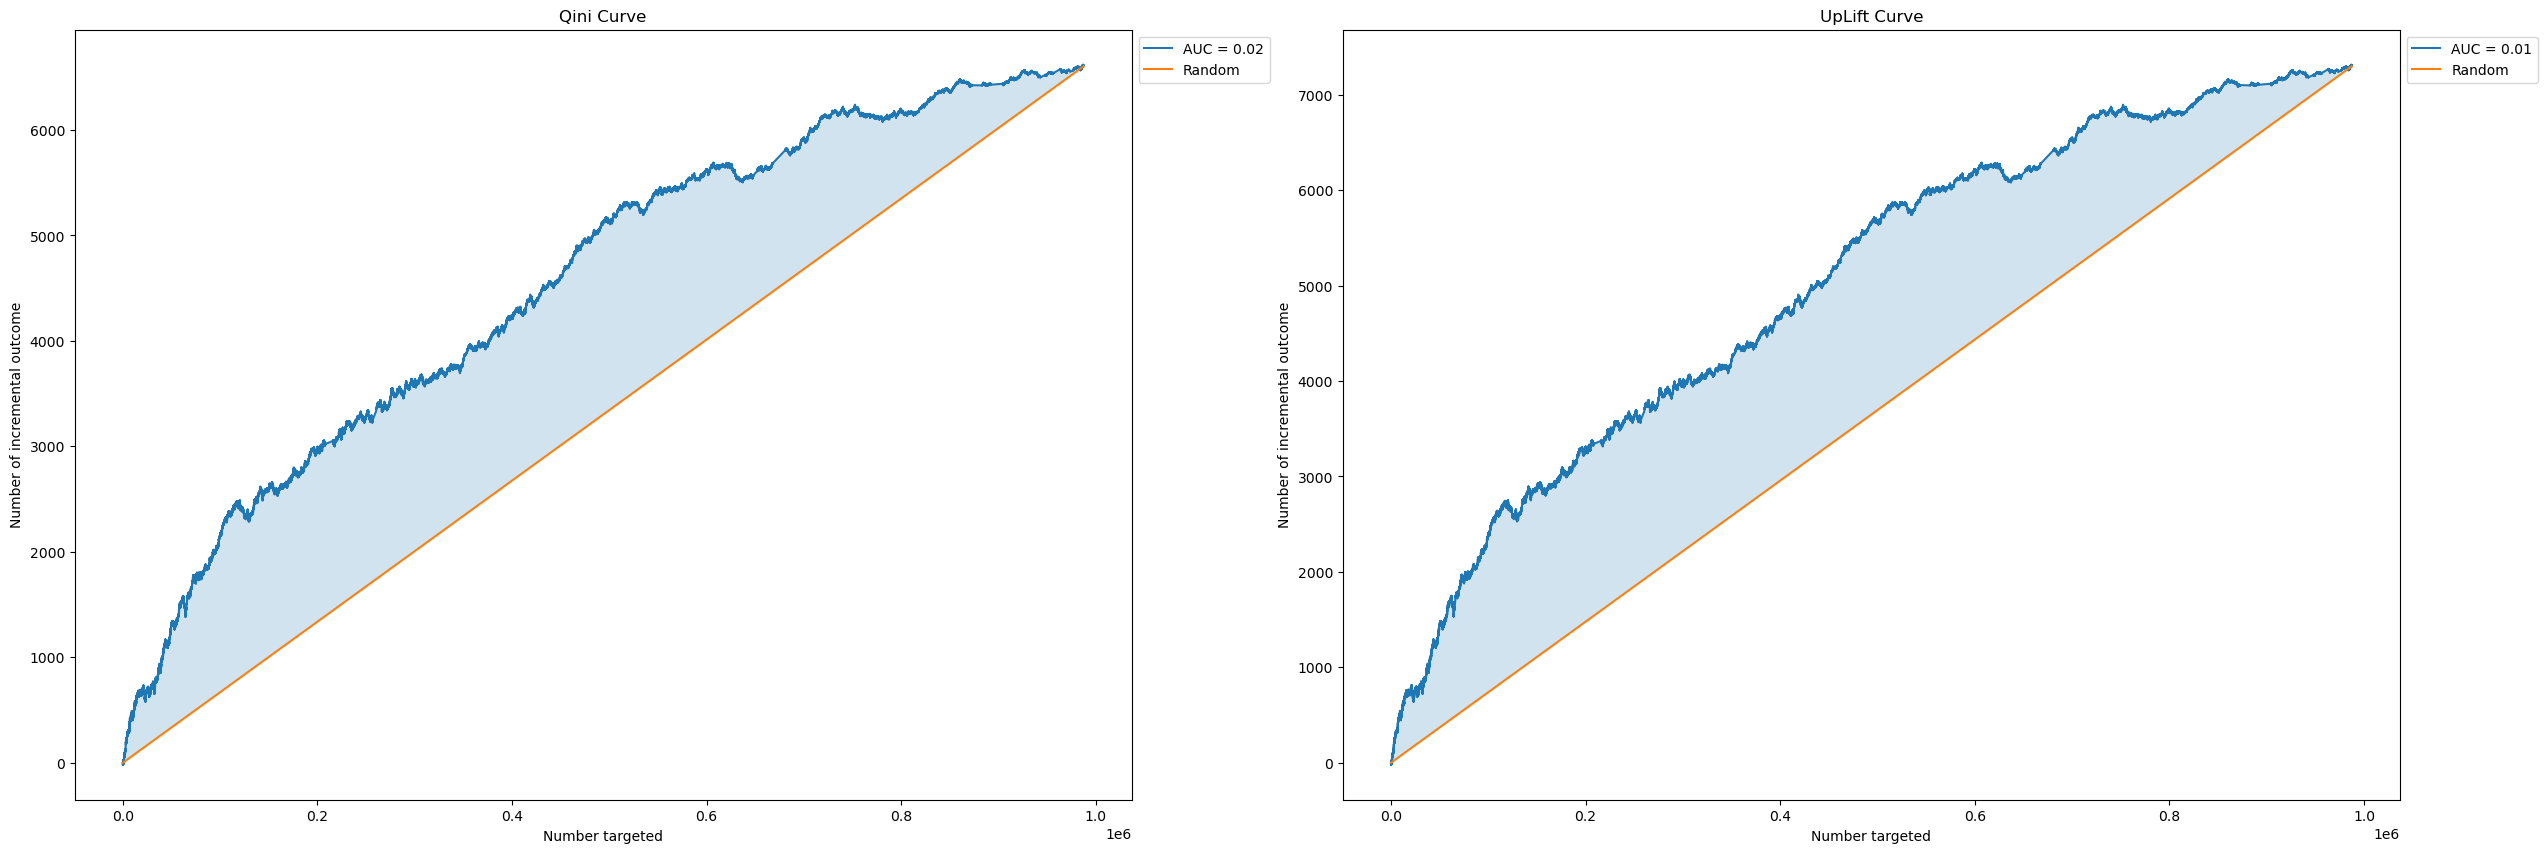

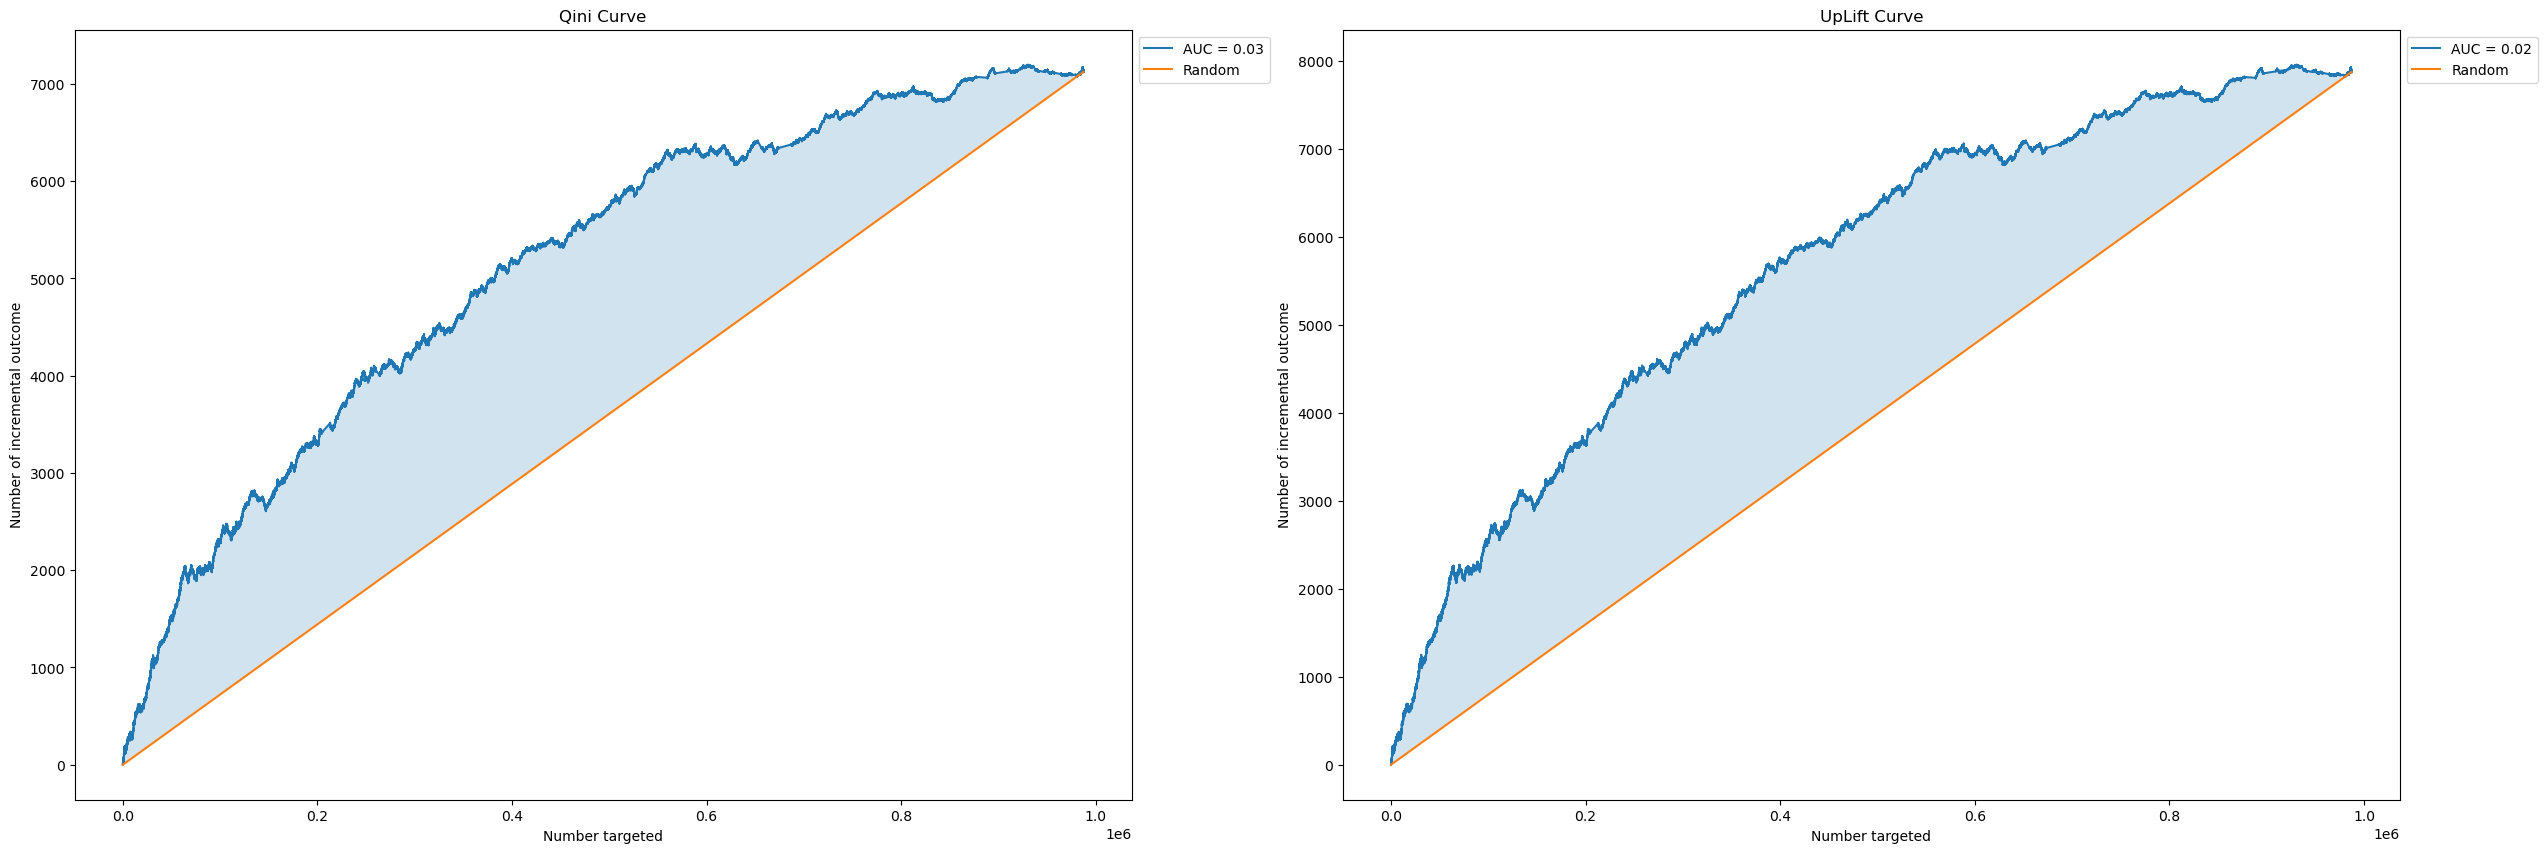

In [29]:
#Default data
skf = StratifiedKFold(n_splits=5, random_state= 42, shuffle=True)
skf.get_n_splits(X, y)
metrics = {'uplift_k_group':[],  'uplift_k_overall':[], 'qini_score':[], 'uplift_score':[]}
i = 0


for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      catboost_clf = CatBoostClassifier(verbose = 0)
      clf = ClassTransformation(estimator=catboost_clf)
      clf.fit(X_train_, y_train_, treatment = treat[train_index])
      y_pred = clf.predict(X_test_)
      del clf
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      uplift_overall, uplift_group, qini_score, uplift_score = get_report(y_test_, treat[test_index], y_pred, f"Plots/Trasnform Class model Split {i}.png")
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      metrics[ 'qini_score'].append(qini_score)
      metrics['uplift_score'].append(uplift_score)
      i += 1


uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

In [30]:
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

UpLift at 30%: overall - 0.0163, grouped - 0.0163.
Qini AUC Score: 0.0269; UpLift AUC Score: 0.017


In [31]:
del X_data
del Y_data
del X
del treat
del df
del y
gc.collect()

38707

# Метод трансформации класса (Регрессия)

In [32]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte']  + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
treat = Y_data.treat.values
X = X_data.values
y = Y_data.target.values
p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt
print(p)






C:\Users\Kirill\AppData\Local\Temp\ipykernel_5664\591216625.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv(r'uplift_dataset.zip'


var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7725915336    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725915337    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725915364    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7725915373    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7725915376    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7725915336    0.0     0.0     1.0     1.0     0.0     1.0     0.0     0.0   
7725915337    0.0     0.0     1.0     1.0     0.0     1.0     0.0     0.0   
7725915364    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   
7725915373    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   
7725915376    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7725915336     1.0    0.36 -1.142168 -0.584185 -0.948573 -0.691940 -0.584185   
7725915337     1.0    0.36 -1.142168 -0.584185 -0.948573 -0.691940 -0.584185   
7725915364     0.0    0.36 -0.203041  0.486727 -0.238421  1.219848  0.486727   
7725915373     0.0    0.36 -0.869518  0.631150  1.892033 -0.149537  0.631150   
7725915376     0.0    0.34  0.887558  0.132387  0.471730 -0.052330  0.132387   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7725915336 -0.948573  0.937219 -0.568816 -0.492042 -0.358016 -0.105294   
7725915337 -0.948573  0.937219 -0.568816 -0.492042 -0.358016 -0.105294   
7725915364 -0.238421  0.334366 -0.568816 -0.492042  2.139214 -0.105294   
7725915373  1.892033  0.575507  1.334204  0.881612  0.264101  0.390701   
7725915376  0.471730  1.049378  1.180284  1.776377 -0.007528 -0.105294   

              var_30    var_31    var_32    var_33    var_34    var_35  \
7725915336  1.121290 -0.594659 -0.071611 -0.595567 -0.071611 -0.595567   
7725915337  1.121290 -0.594659 -0.071611 -0.595567 -0.071611 -0.595567   
7725915364 -0.373339 -0.594659  3.453093  0.462552  3.453093  0.462552   
7725915373  0.523438  1.345352 -0.071611  0.722441 -0.071611  0.722441   
7725915376  1.121290  1.345352 -0.071611  0.146973 -0.071611  0.146973   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7725915336 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915337 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915364 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915373  2.010156  0.004130  0.711746  0.812655  0.459654  2.000484   
7725915376  1.795316  0.245265  0.711746 -0.147910 -0.174913 -0.287372   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7725915336 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915337 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915364 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915373  1.738082  0.071780  0.977076 -2.627860  0.266733 -1.271727   
7725915376  1.738082  0.363994  0.977076  0.273855  0.130364  0.210894   

              var_48    var_49    var_50  
7725915336  0.000000  0.000000  0.000000  
7725915337  0.000000  0.000000  0.000000  
7725915364  0.000000  0.000000  0.000000  
7725915373  0.344958  0.040854  0.326157  
7725915376  0.228310  0.000000  0.228310

target  treat
7725915336       0      1
7725915337       0      0
7725915364       0      1
7725915373       0      1
7725915376       0      1

0.9045956538094344


UpLift at 30%: overall - 0.015828, grouped - 0.016381.
Qini AUC Score: 0.010878; UpLift AUC Score: 0.006779
UpLift at 30%: overall - 0.012509, grouped - 0.013292.
Qini AUC Score: 0.010797; UpLift AUC Score: 0.006779
UpLift at 30%: overall - 0.014423, grouped - 0.015184.
Qini AUC Score: 0.01555; UpLift AUC Score: 0.009789
UpLift at 30%: overall - 0.011377, grouped - 0.012492.
Qini AUC Score: 0.009667; UpLift AUC Score: 0.006068
UpLift at 30%: overall - 0.01307, grouped - 0.013525.
Qini AUC Score: 0.01674; UpLift AUC Score: 0.010551
UpLift at 30%: overall - 0.0134, grouped - 0.0142.
Qini AUC Score: 0.0127; UpLift AUC Score: 0.008


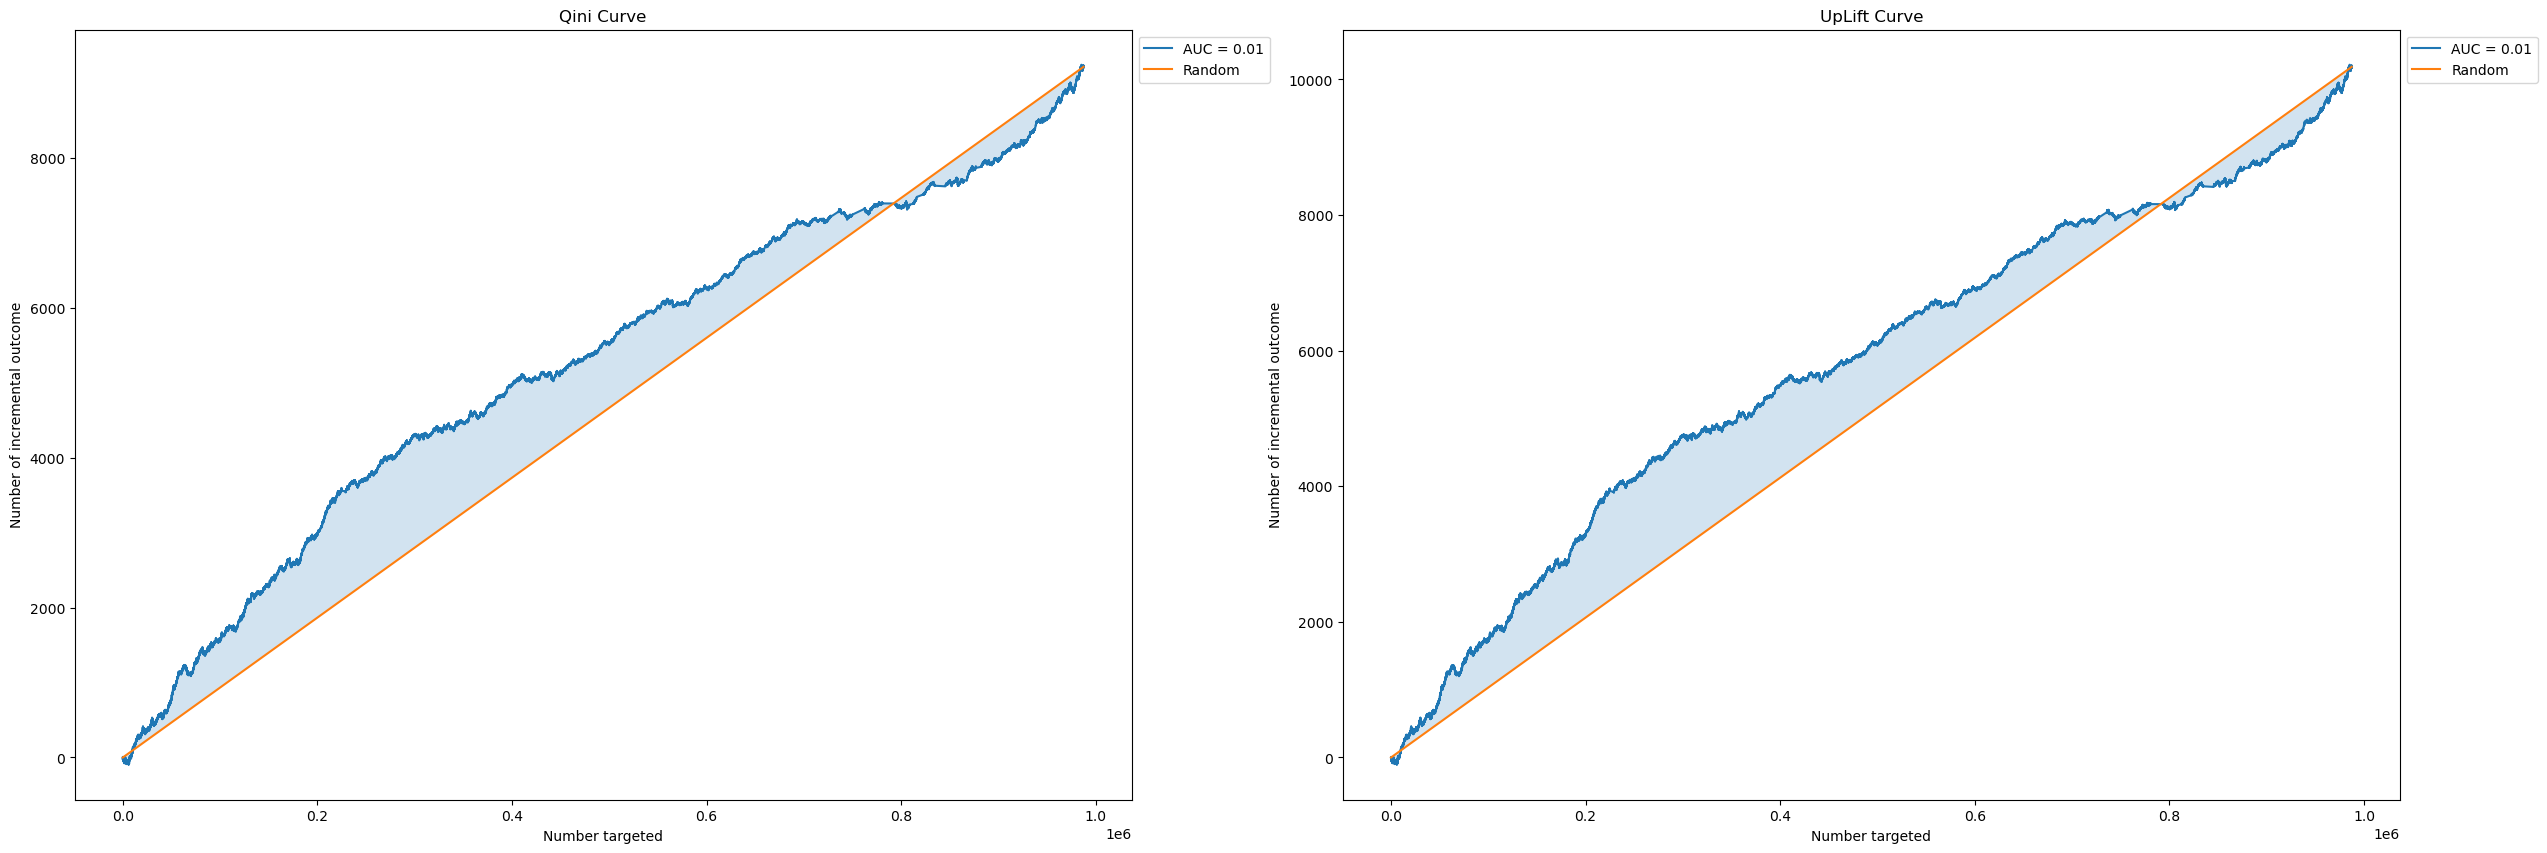

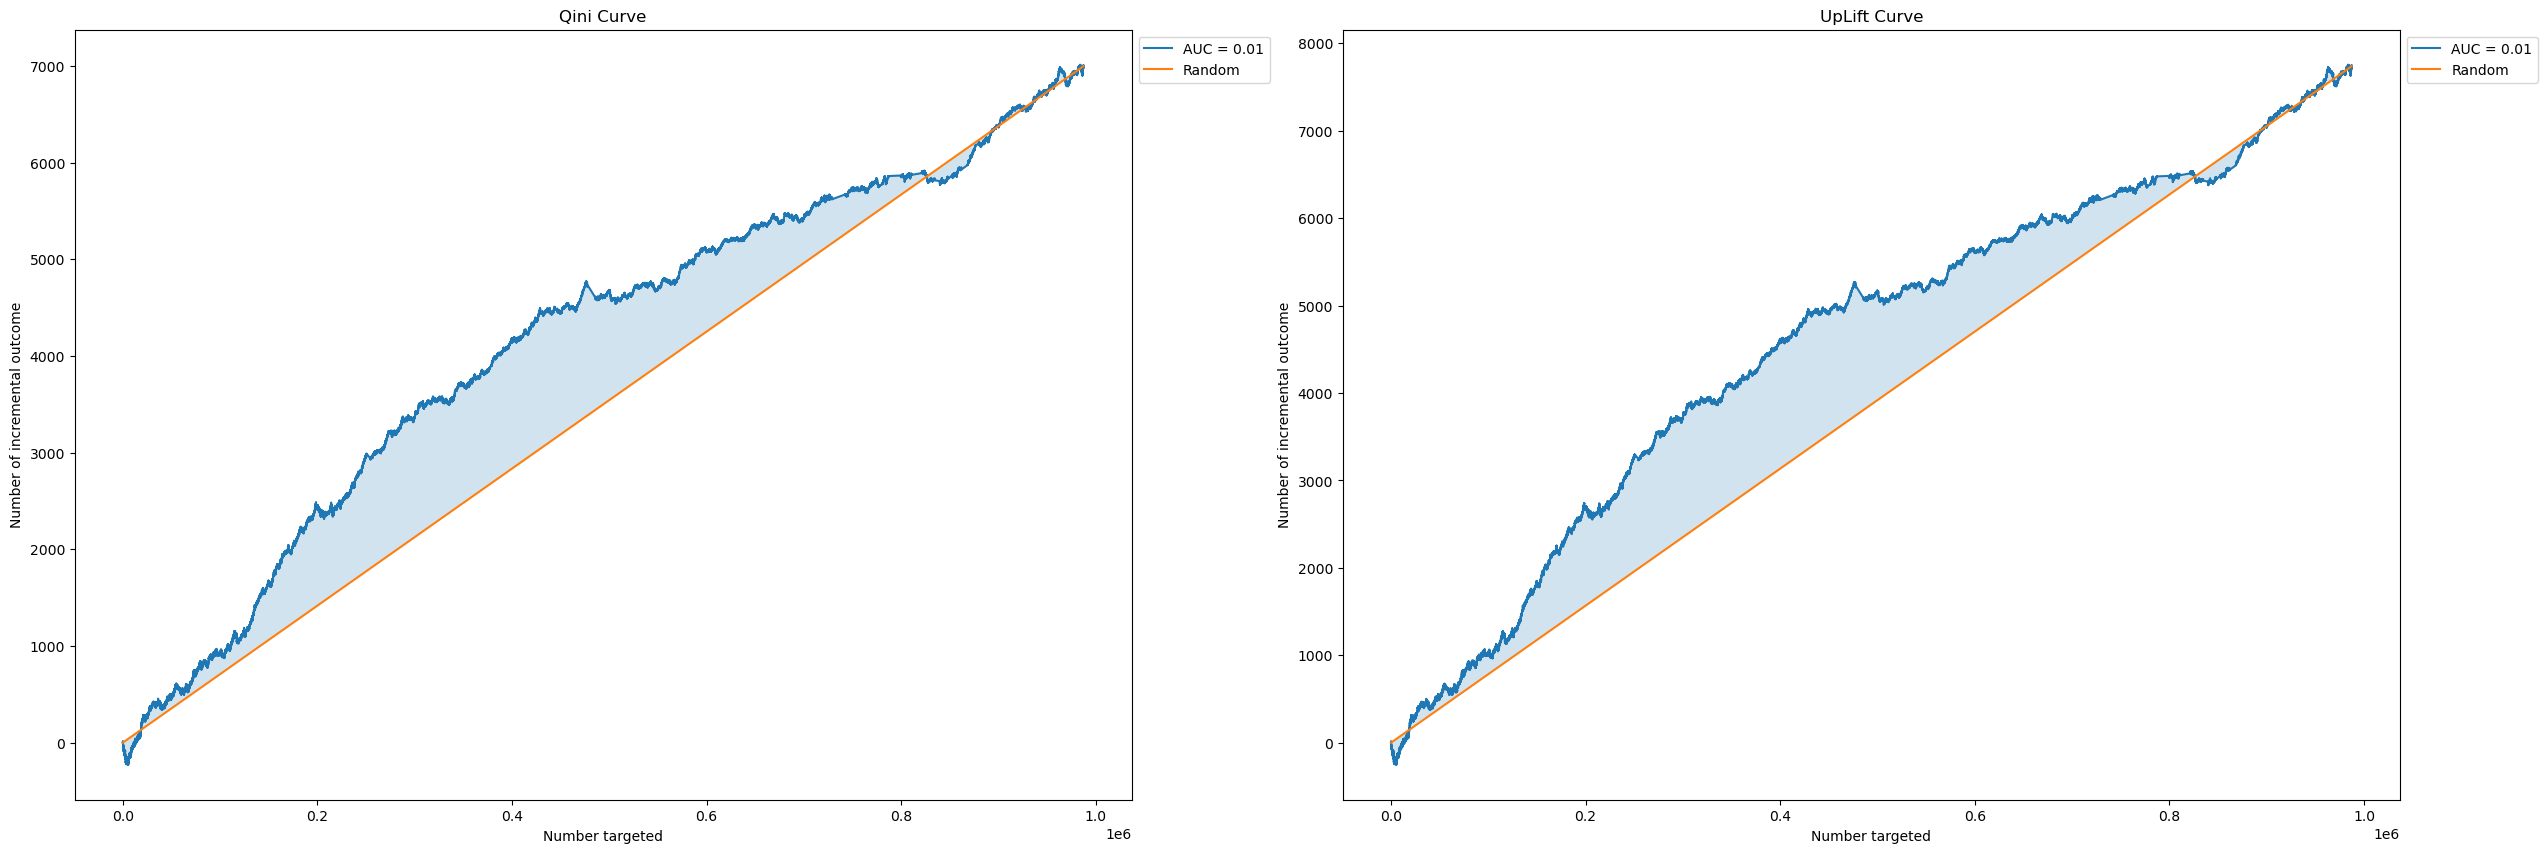

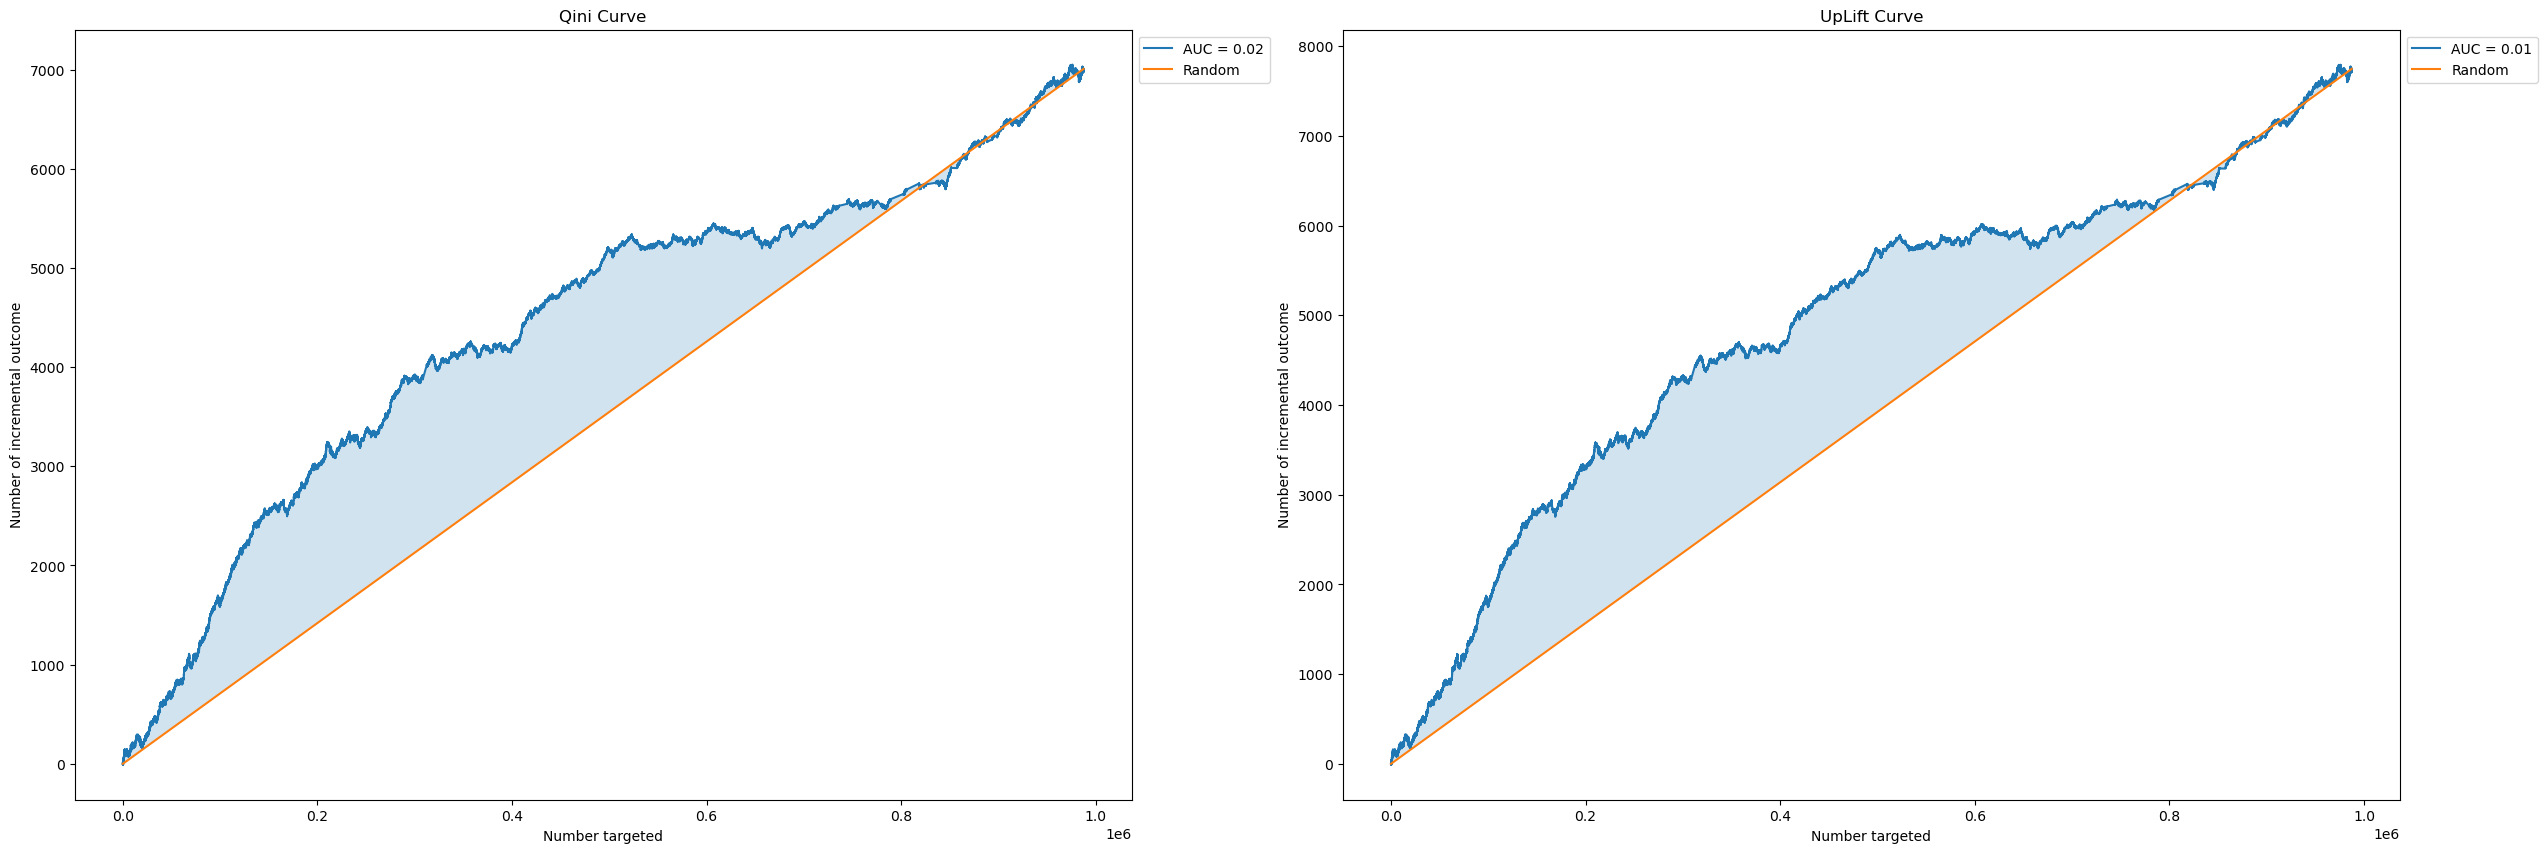

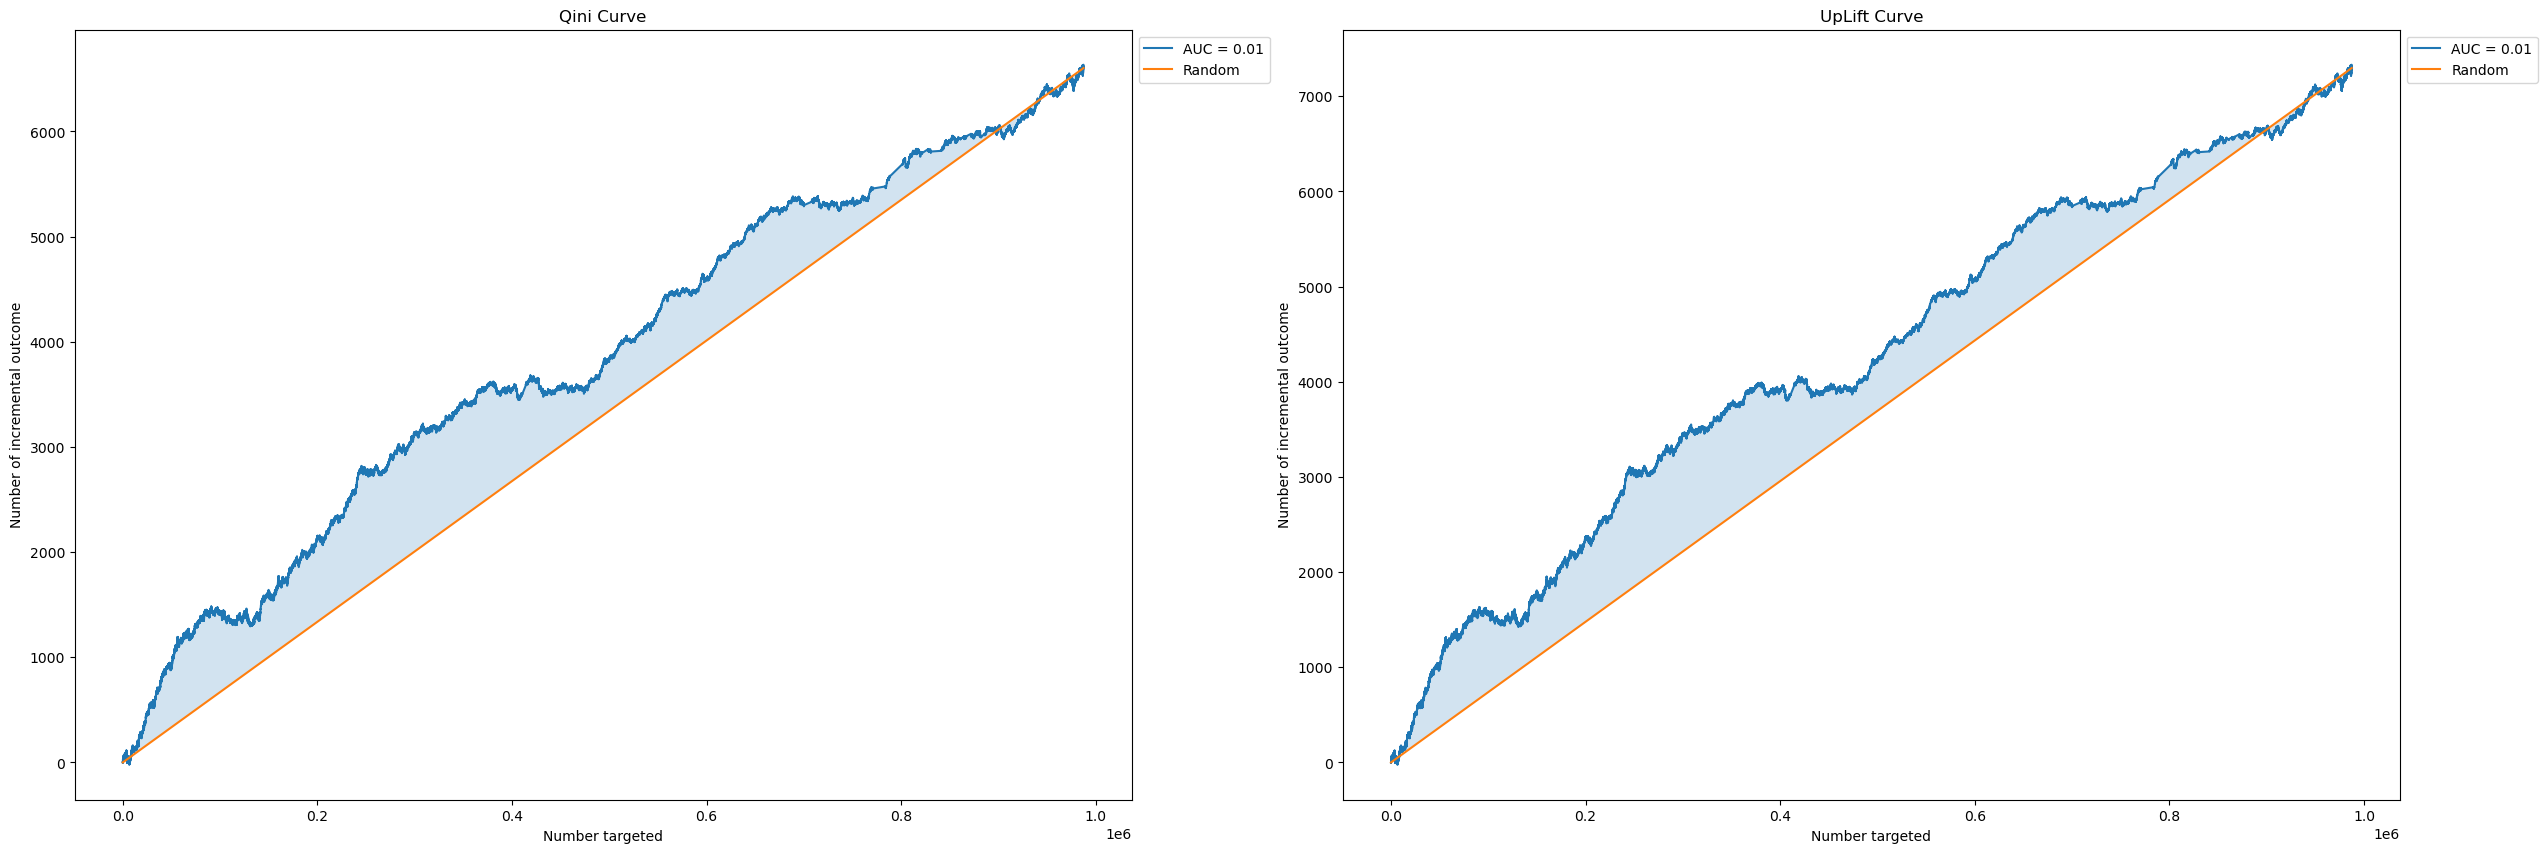

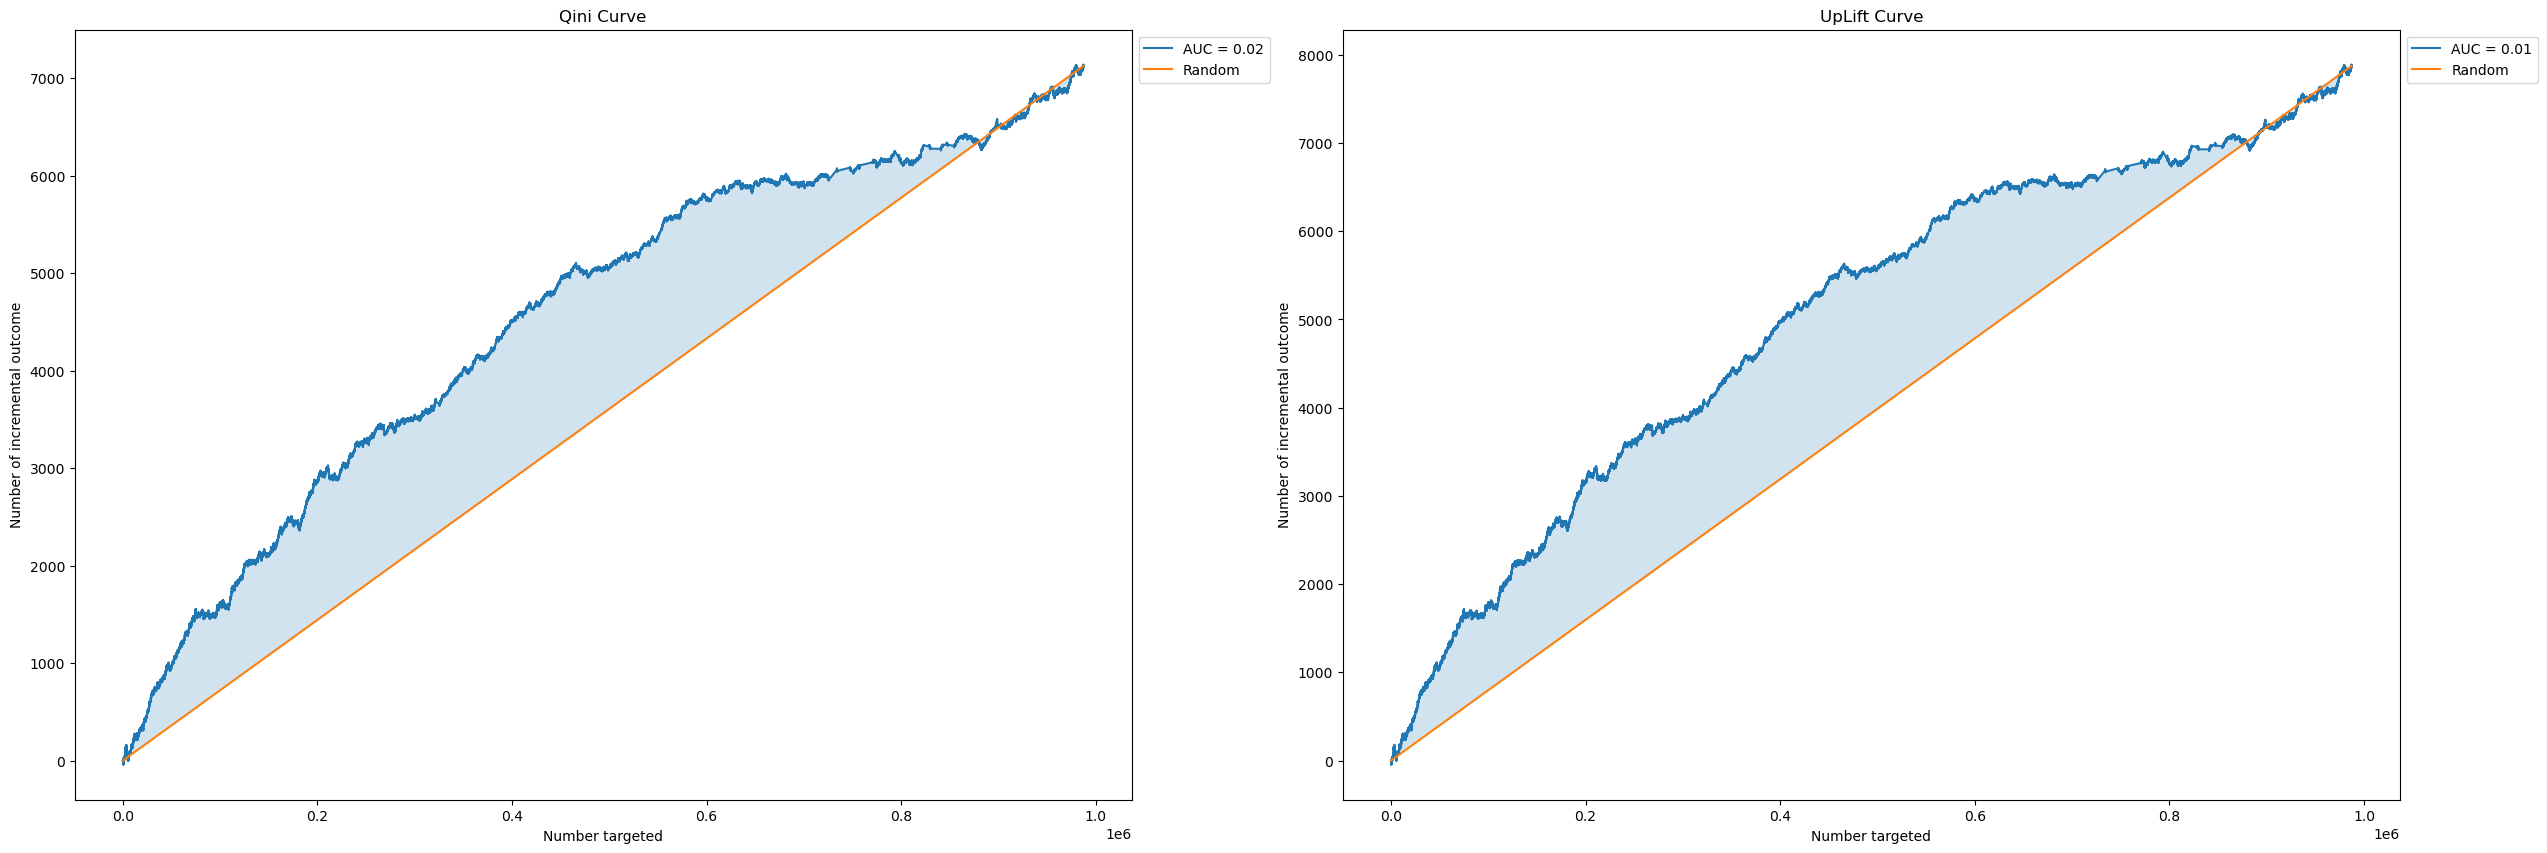

In [33]:
#Default data
skf = StratifiedKFold(n_splits=5, random_state= 42, shuffle=True)
skf.get_n_splits(X, y)
metrics = {'uplift_k_group':[],  'uplift_k_overall':[], 'qini_score':[], 'uplift_score':[]}
i = 0


for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      catboost_reg = CatBoostRegressor(verbose = 0)
      clf = ClassTransformationReg(estimator=catboost_reg, propensity_val=p)
      clf.fit(X_train_, y_train_, treatment = treat[train_index])
      y_pred = clf.predict(X_test_)
      del clf
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      uplift_overall, uplift_group, qini_score, uplift_score = get_report(y_test_, treat[test_index], y_pred, f"Plots/Trasnform Regression model Split {i}.png")
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      metrics[ 'qini_score'].append(qini_score)
      metrics['uplift_score'].append(uplift_score)
      i += 1
      gc.collect()


uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

In [34]:
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

UpLift at 30%: overall - 0.0134, grouped - 0.0142.
Qini AUC Score: 0.0127; UpLift AUC Score: 0.008


In [35]:
del X_data
del Y_data
del X
del treat
del df
del y
gc.collect()

38696

# AutoML Class

## Search PipeLine

In [36]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte']  + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
proc_data = PrepocessingDataSetLetu()
proc_data.remove_colls(colls_to_drop)
X_data, Y_data = proc_data.preprocessing_data_solomodel(df)
treat = Y_data.treat.values
X = X_data.values
y = Y_data.target.values
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt
print(X.shape)
print(y.shape)






C:\Users\Kirill\AppData\Local\Temp\ipykernel_5664\206654753.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv(r'uplift_dataset.zip'


var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7725915336    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725915337    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725915364    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7725915373    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7725915376    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7725915336    0.0     0.0     1.0     1.0     0.0     1.0     0.0     0.0   
7725915337    0.0     0.0     1.0     1.0     0.0     1.0     0.0     0.0   
7725915364    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   
7725915373    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   
7725915376    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7725915336     1.0    0.36 -1.142168 -0.584185 -0.948573 -0.691940 -0.584185   
7725915337     1.0    0.36 -1.142168 -0.584185 -0.948573 -0.691940 -0.584185   
7725915364     0.0    0.36 -0.203041  0.486727 -0.238421  1.219848  0.486727   
7725915373     0.0    0.36 -0.869518  0.631150  1.892033 -0.149537  0.631150   
7725915376     0.0    0.34  0.887558  0.132387  0.471730 -0.052330  0.132387   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7725915336 -0.948573  0.937219 -0.568816 -0.492042 -0.358016 -0.105294   
7725915337 -0.948573  0.937219 -0.568816 -0.492042 -0.358016 -0.105294   
7725915364 -0.238421  0.334366 -0.568816 -0.492042  2.139214 -0.105294   
7725915373  1.892033  0.575507  1.334204  0.881612  0.264101  0.390701   
7725915376  0.471730  1.049378  1.180284  1.776377 -0.007528 -0.105294   

              var_30    var_31    var_32    var_33    var_34    var_35  \
7725915336  1.121290 -0.594659 -0.071611 -0.595567 -0.071611 -0.595567   
7725915337  1.121290 -0.594659 -0.071611 -0.595567 -0.071611 -0.595567   
7725915364 -0.373339 -0.594659  3.453093  0.462552  3.453093  0.462552   
7725915373  0.523438  1.345352 -0.071611  0.722441 -0.071611  0.722441   
7725915376  1.121290  1.345352 -0.071611  0.146973 -0.071611  0.146973   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7725915336 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915337 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915364 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915373  2.010156  0.004130  0.711746  0.812655  0.459654  2.000484   
7725915376  1.795316  0.245265  0.711746 -0.147910 -0.174913 -0.287372   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7725915336 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915337 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915364 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915373  1.738082  0.071780  0.977076 -2.627860  0.266733 -1.271727   
7725915376  1.738082  0.363994  0.977076  0.273855  0.130364  0.210894   

              var_48    var_49    var_50  var_51  var_52  
7725915336  0.000000  0.000000  0.000000     0.0     1.0  
7725915337  0.000000  0.000000  0.000000     1.0     0.0  
7725915364  0.000000  0.000000  0.000000     0.0     1.0  
7725915373  0.344958  0.040854  0.326157     0.0     1.0  
7725915376  0.228310  0.000000  0.228310     0.0     1.0

target  treat
7725915336       0      1
7725915337       0      0
7725915364       0      1
7725915373       0      1
7725915376       0      1

(4936599, 53)
(4936599,)


In [37]:
import evalml
from evalml import AutoMLSearch

In [38]:
from evalml.objectives import get_optimization_objectives
from evalml.problem_types import ProblemTypes

for objective in get_optimization_objectives(ProblemTypes.BINARY):
    print(objective.name)

MCC Binary
Log Loss Binary
Gini
AUC
Precision
F1
Balanced Accuracy Binary
Accuracy Binary


In [39]:
X_train,X_test,y_train,y_test = evalml.preprocessing.utils.split_data(X, y, problem_type="binary", test_size = 1e-6)

In [40]:
X_train.shape, X_test.shape

((4936594, 53), (5, 53))

In [41]:
automl=AutoMLSearch(X_train = X_train
                    , y_train = y_train
                    , n_jobs = -1
                    , problem_type='binary'
                    , patience= 20
                    , verbose = True
                    , tolerance= 1e-12
                    , allow_long_running_models = True
                    , max_batches = 50
                    , objective = 'Gini'
                    , optimize_thresholds=True
                    , train_best_pipeline= True
                    , ensembling=True
                    , max_iterations = 50
                    , holdout_set_size= 0
                    #, allowed_model_families = evalml.pipelines.components.utils.allowed_model_families('binary')
                    )


automl.search()

AutoMLSearch will use mean CV score to rank pipelines.

*****************************
* Beginning pipeline search *
*****************************

Optimizing for Gini. 
Greater score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 50 batches for a total of 50 pipelines. 
Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mode Baseline Binary Classification Pipeline
Mode Baseline Binary Classification Pipeline:
	Starting cross validation
	Finished cross validation - mean Gini: 0.000

*****************************
* Evaluating Batch Number 1 *
*****************************

Logistic Regression Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Gini: 0.390
Random Forest Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler:
	Starting cross validation
	Finished cross validation - mean Gini: 0.412

*****************************
* Evaluating Batch Number 2 *
*****************************

Logistic Regression Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Standard Scaler + RF Classifier Select From Model:
	Starting cross validation
	Finished cross validation - mean Gini: 0.378
Random

{1: {'Logistic Regression Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Standard Scaler': '01:57',
  'Random Forest Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler': '01:12',
  'Total time of batch': '03:12'},
 2: {'Logistic Regression Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Standard Scaler + RF Classifier Select From Model': '01:38',
  'Random Forest Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + RF Classifier Select From Model': '01:15',
  'Total time of batch': '02:55'},
 3: {'Decision Tree Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Select Columns Transformer': '00:49',
  'LightGBM Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Select Columns Transformer': '00:55',
  'Extra Trees Classifier w/ Label Encoder +

In [42]:
automl.save('automl_big_searching_class.cloudpickle')

In [43]:
del X_data
del Y_data
del X
del treat
del df
del y
gc.collect()

135

## Train Best Pipeline

In [5]:
import evalml
from evalml import AutoMLSearch
automl = AutoMLSearch.load('automl_big_searching_class.cloudpickle')


In [6]:
ranks = automl.rankings
ranks = ranks.drop(['id', 'search_order'	,'mean_cv_score'	,'standard_deviation_cv_score', 'high_variance_cv'], axis = 1)

In [7]:
ranks.to_csv('evalml_class_res.csv', index = False)

In [20]:
ranks.head(10)

pipeline_name  ranking_score  \
0   LightGBM Classifier w/ Label Encoder + Replace...       0.466715   
2   XGBoost Classifier w/ Label Encoder + Replace ...       0.462997   
3            Stacked Ensemble Classification Pipeline       0.462072   
4   Random Forest Classifier w/ Label Encoder + Re...       0.451079   
35  Random Forest Classifier w/ Label Encoder + Re...       0.415101   
36  Random Forest Classifier w/ Label Encoder + Re...       0.412236   
42  CatBoost Classifier w/ Label Encoder + Replace...       0.391476   
43  Logistic Regression Classifier w/ Label Encode...       0.389931   
44  Logistic Regression Classifier w/ Label Encode...       0.378178   
45  Elastic Net Classifier w/ Label Encoder + Repl...       0.377873   

    percent_better_than_baseline  \
0                            inf   
2                            inf   
3                            inf   
4                            inf   
35                           inf   
36                           inf   
42                           inf   
43                           inf   
44                           inf   
45                           inf   

                                           parameters  
0   {'Label Encoder': {'positive_label': None}, 'I...  
2   {'Label Encoder': {'positive_label': None}, 'I...  
3   {'Label Encoder': {'positive_label': None}, 'L...  
4   {'Label Encoder': {'positive_label': None}, 'I...  
35  {'Label Encoder': {'positive_label': None}, 'I...  
36  {'Label Encoder': {'positive_label': None}, 'I...  
42  {'Label Encoder': {'positive_label': None}, 'I...  
43  {'Label Encoder': {'positive_label': None}, 'I...  
44  {'Label Encoder': {'positive_label': None}, 'I...  
45  {'Label Encoder': {'positive_label': None}, 'I...

In [9]:
ranks.shape

(13, 4)

In [10]:

ranks.head(10).to_excel('class_res.xlsx')

In [11]:
ranks.iloc[0, :].parameters

{'Label Encoder': {'positive_label': None},
 'Imputer': {'categorical_impute_strategy': 'most_frequent',
  'numeric_impute_strategy': 'knn',
  'boolean_impute_strategy': 'knn',
  'categorical_fill_value': None,
  'numeric_fill_value': None,
  'boolean_fill_value': None},
 'Undersampler': {'sampling_ratio': 0.25,
  'min_samples': 100,
  'min_percentage': 0.1,
  'sampling_ratio_dict': None},
 'Select Columns Transformer': {'columns': [3,
   12,
   15,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   30,
   33,
   35,
   36,
   37,
   40,
   43,
   45,
   46,
   47,
   48,
   49,
   50]},
 'LightGBM Classifier': {'boosting_type': 'dart',
  'learning_rate': 0.32830397998590266,
  'n_estimators': 90,
  'max_depth': 0,
  'num_leaves': 89,
  'min_child_samples': 80,
  'n_jobs': -1,
  'bagging_freq': 1,
  'bagging_fraction': 0.9223480594486513}}

In [12]:
best_clf = automl.best_pipeline
type(best_clf)

evalml.pipelines.binary_classification_pipeline.BinaryClassificationPipeline

In [13]:
best_clf = automl.get_pipeline(2)
type(best_clf)

evalml.pipelines.binary_classification_pipeline.BinaryClassificationPipeline

In [14]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte']  + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
proc_data = PrepocessingDataSetLetu()
proc_data.remove_colls(colls_to_drop)
X_data, Y_data = proc_data.preprocessing_data_solomodel(df)
treat = Y_data.treat.values
X = X_data.values
y = Y_data.target.values
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt
print(X.shape)
print(y.shape)






C:\Users\Kirill\AppData\Local\Temp\ipykernel_20128\206654753.py:1: DtypeWarning:

Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.



var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7725915336    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725915337    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725915364    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7725915373    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7725915376    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7725915336    0.0     0.0     1.0     1.0     0.0     1.0     0.0     0.0   
7725915337    0.0     0.0     1.0     1.0     0.0     1.0     0.0     0.0   
7725915364    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   
7725915373    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   
7725915376    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7725915336     1.0    0.36 -1.142168 -0.584185 -0.948573 -0.691940 -0.584185   
7725915337     1.0    0.36 -1.142168 -0.584185 -0.948573 -0.691940 -0.584185   
7725915364     0.0    0.36 -0.203041  0.486727 -0.238421  1.219848  0.486727   
7725915373     0.0    0.36 -0.869518  0.631150  1.892033 -0.149537  0.631150   
7725915376     0.0    0.34  0.887558  0.132387  0.471730 -0.052330  0.132387   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7725915336 -0.948573  0.937219 -0.568816 -0.492042 -0.358016 -0.105294   
7725915337 -0.948573  0.937219 -0.568816 -0.492042 -0.358016 -0.105294   
7725915364 -0.238421  0.334366 -0.568816 -0.492042  2.139214 -0.105294   
7725915373  1.892033  0.575507  1.334204  0.881612  0.264101  0.390701   
7725915376  0.471730  1.049378  1.180284  1.776377 -0.007528 -0.105294   

              var_30    var_31    var_32    var_33    var_34    var_35  \
7725915336  1.121290 -0.594659 -0.071611 -0.595567 -0.071611 -0.595567   
7725915337  1.121290 -0.594659 -0.071611 -0.595567 -0.071611 -0.595567   
7725915364 -0.373339 -0.594659  3.453093  0.462552  3.453093  0.462552   
7725915373  0.523438  1.345352 -0.071611  0.722441 -0.071611  0.722441   
7725915376  1.121290  1.345352 -0.071611  0.146973 -0.071611  0.146973   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7725915336 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915337 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915364 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915373  2.010156  0.004130  0.711746  0.812655  0.459654  2.000484   
7725915376  1.795316  0.245265  0.711746 -0.147910 -0.174913 -0.287372   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7725915336 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915337 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915364 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915373  1.738082  0.071780  0.977076 -2.627860  0.266733 -1.271727   
7725915376  1.738082  0.363994  0.977076  0.273855  0.130364  0.210894   

              var_48    var_49    var_50  var_51  var_52  
7725915336  0.000000  0.000000  0.000000     0.0     1.0  
7725915337  0.000000  0.000000  0.000000     1.0     0.0  
7725915364  0.000000  0.000000  0.000000     0.0     1.0  
7725915373  0.344958  0.040854  0.326157     0.0     1.0  
7725915376  0.228310  0.000000  0.228310     0.0     1.0

target  treat
7725915336       0      1
7725915337       0      0
7725915364       0      1
7725915373       0      1
7725915376       0      1

(4936599, 53)
(4936599,)


UpLift at 30%: overall - 0.010406, grouped - 0.010374.
Qini AUC Score: 0.0; UpLift AUC Score: 0.0
UpLift at 30%: overall - 0.006105, grouped - 0.006094.
Qini AUC Score: 0.0; UpLift AUC Score: 0.0
UpLift at 30%: overall - 0.008459, grouped - 0.008354.
Qini AUC Score: 0.0; UpLift AUC Score: 0.0
UpLift at 30%: overall - 0.00899, grouped - 0.008942.
Qini AUC Score: 0.0; UpLift AUC Score: 0.0
UpLift at 30%: overall - 0.008869, grouped - 0.008859.
Qini AUC Score: 0.0; UpLift AUC Score: 0.0
UpLift at 30%: overall - 0.0086, grouped - 0.0085.
Qini AUC Score: 0.0; UpLift AUC Score: 0.0


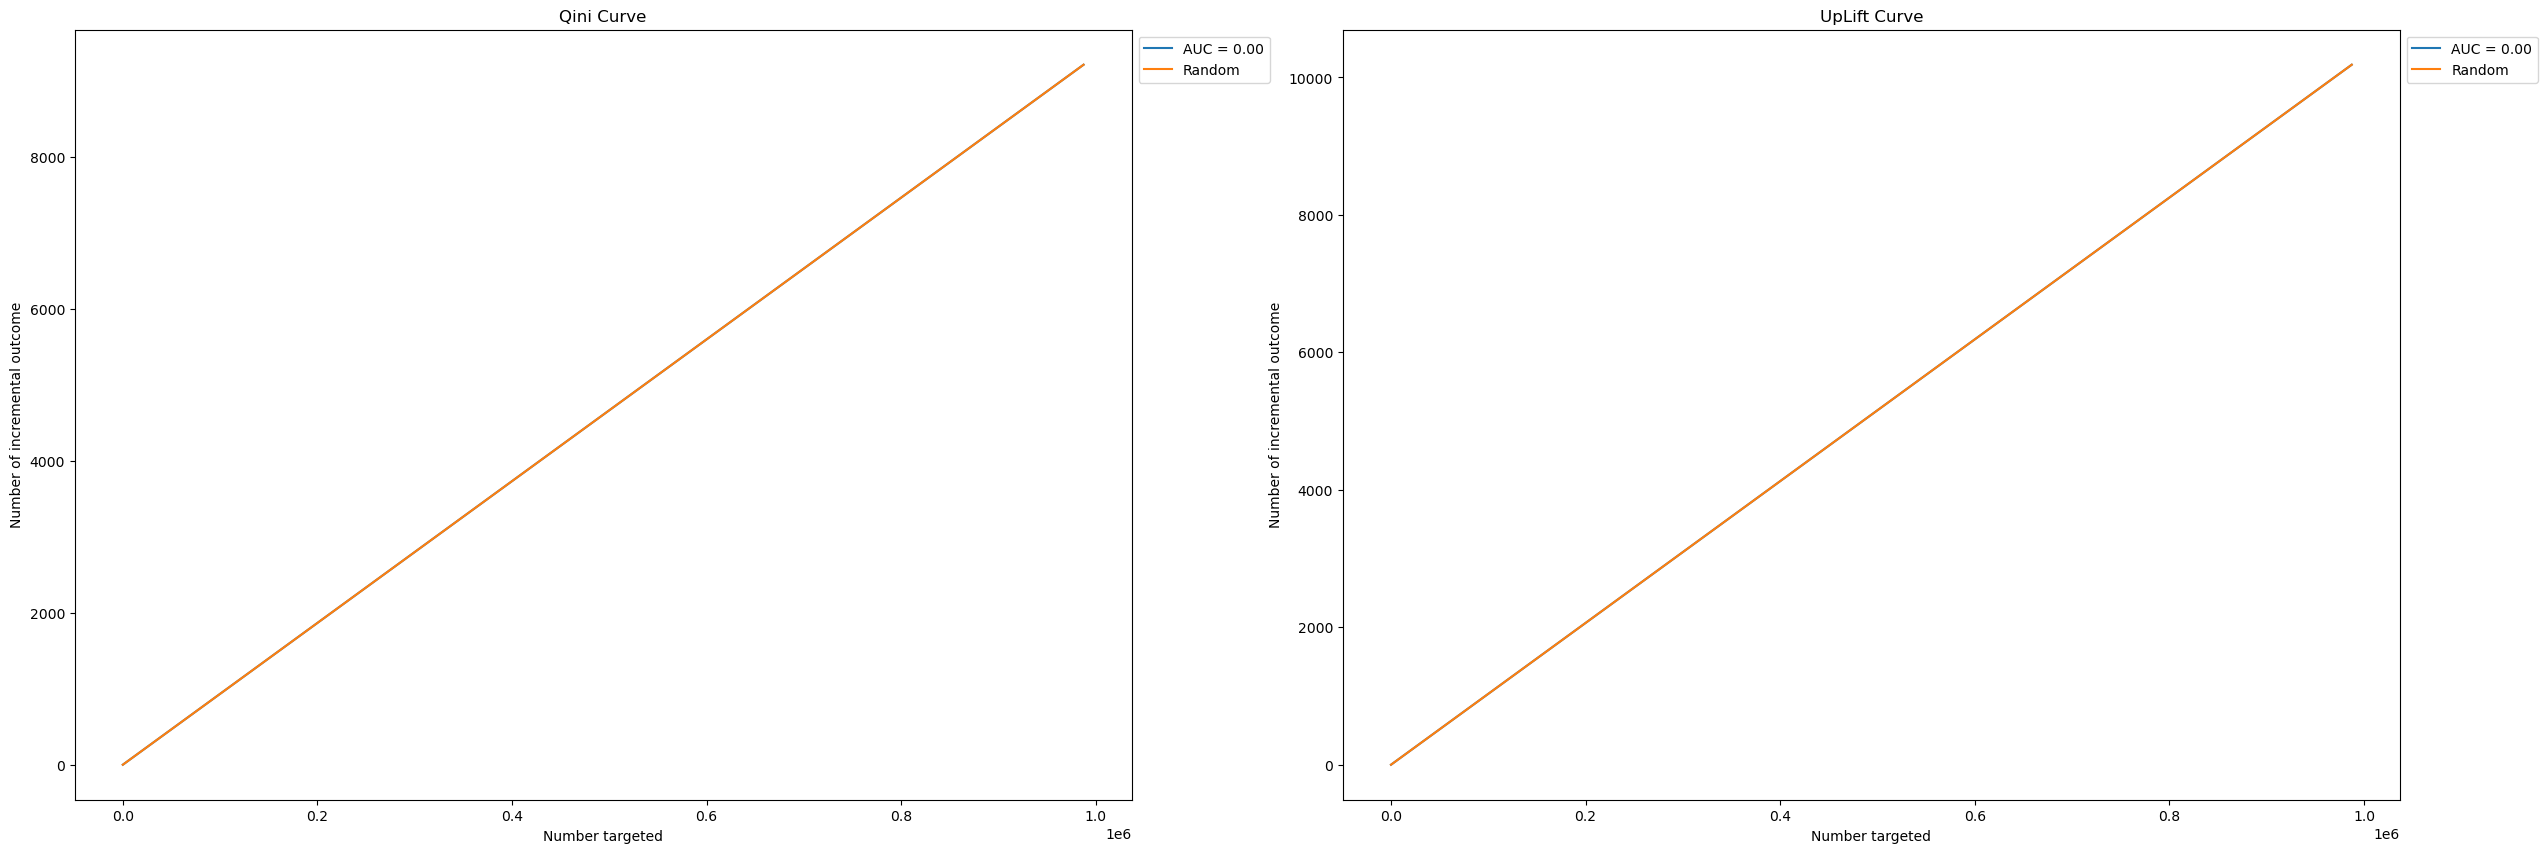

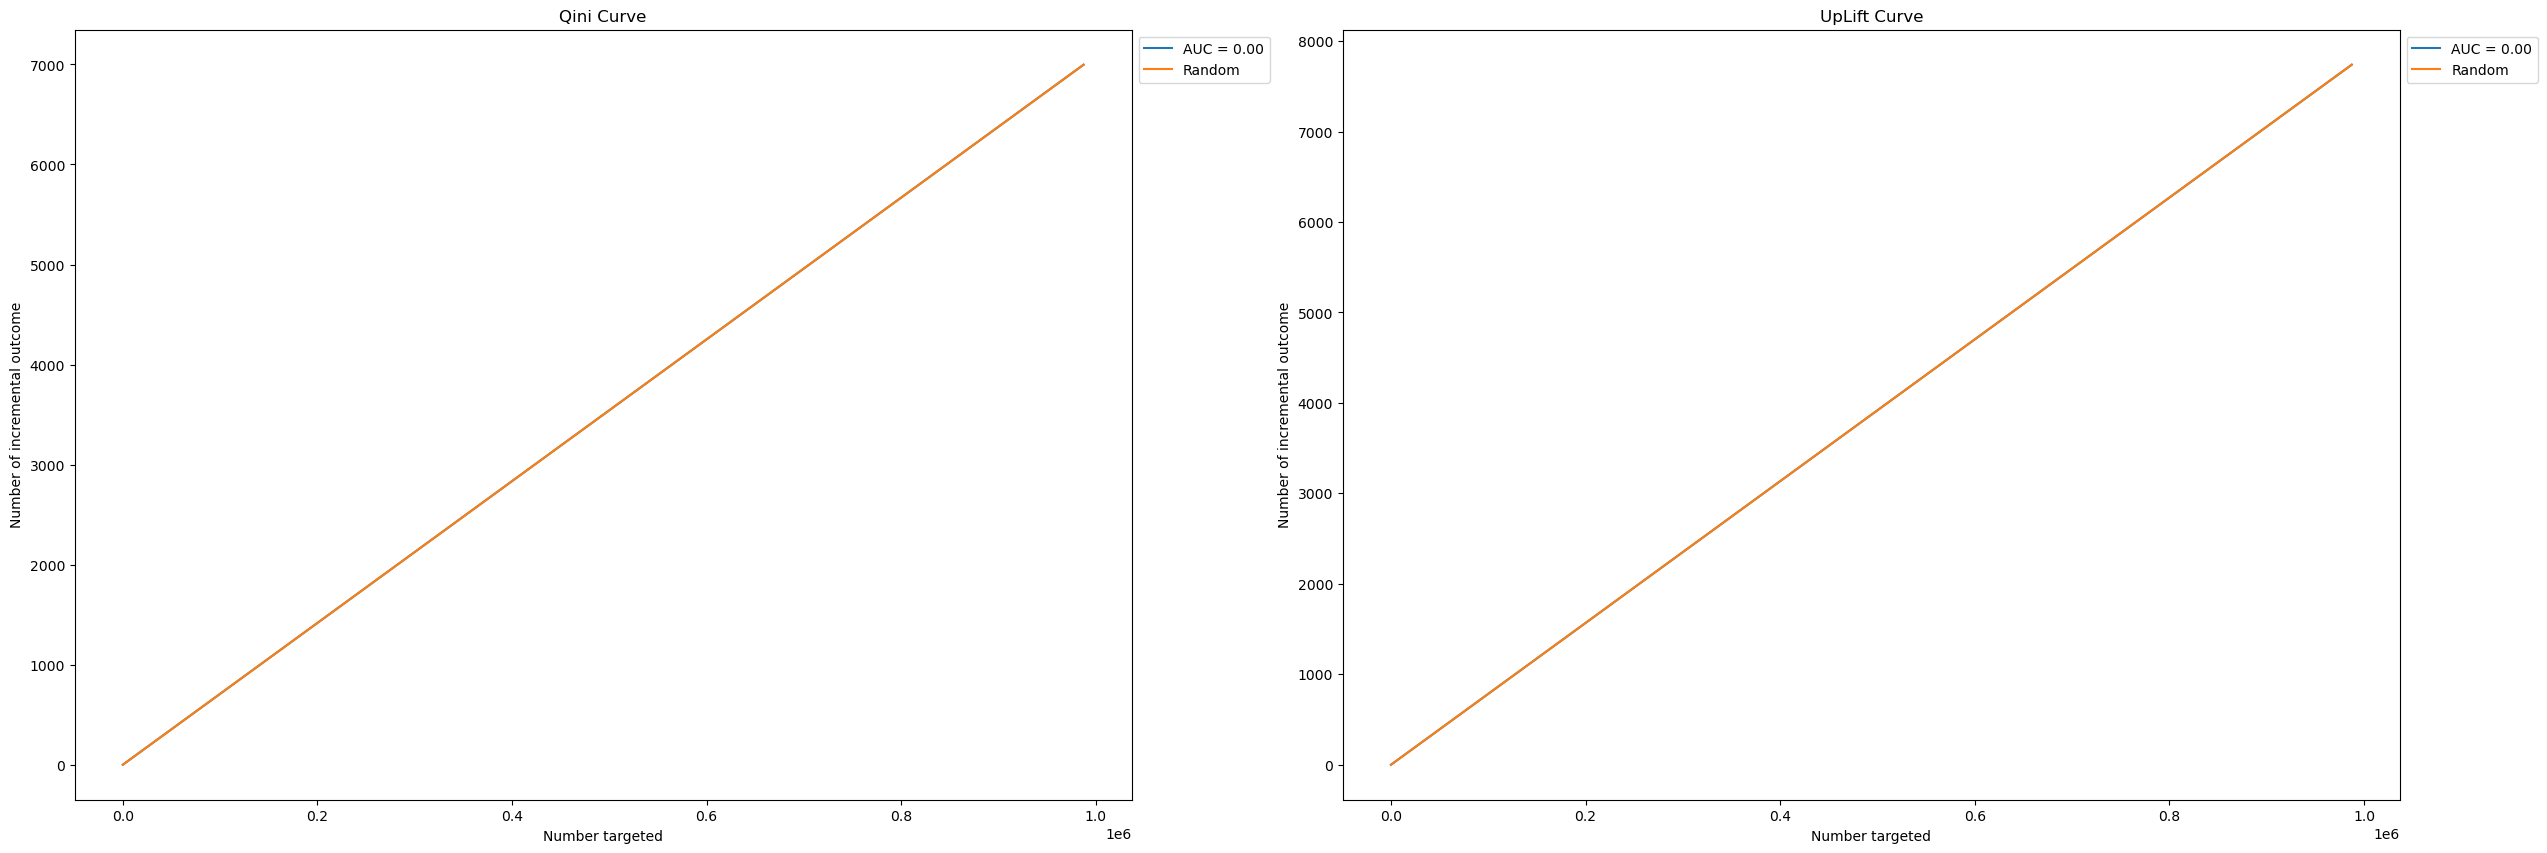

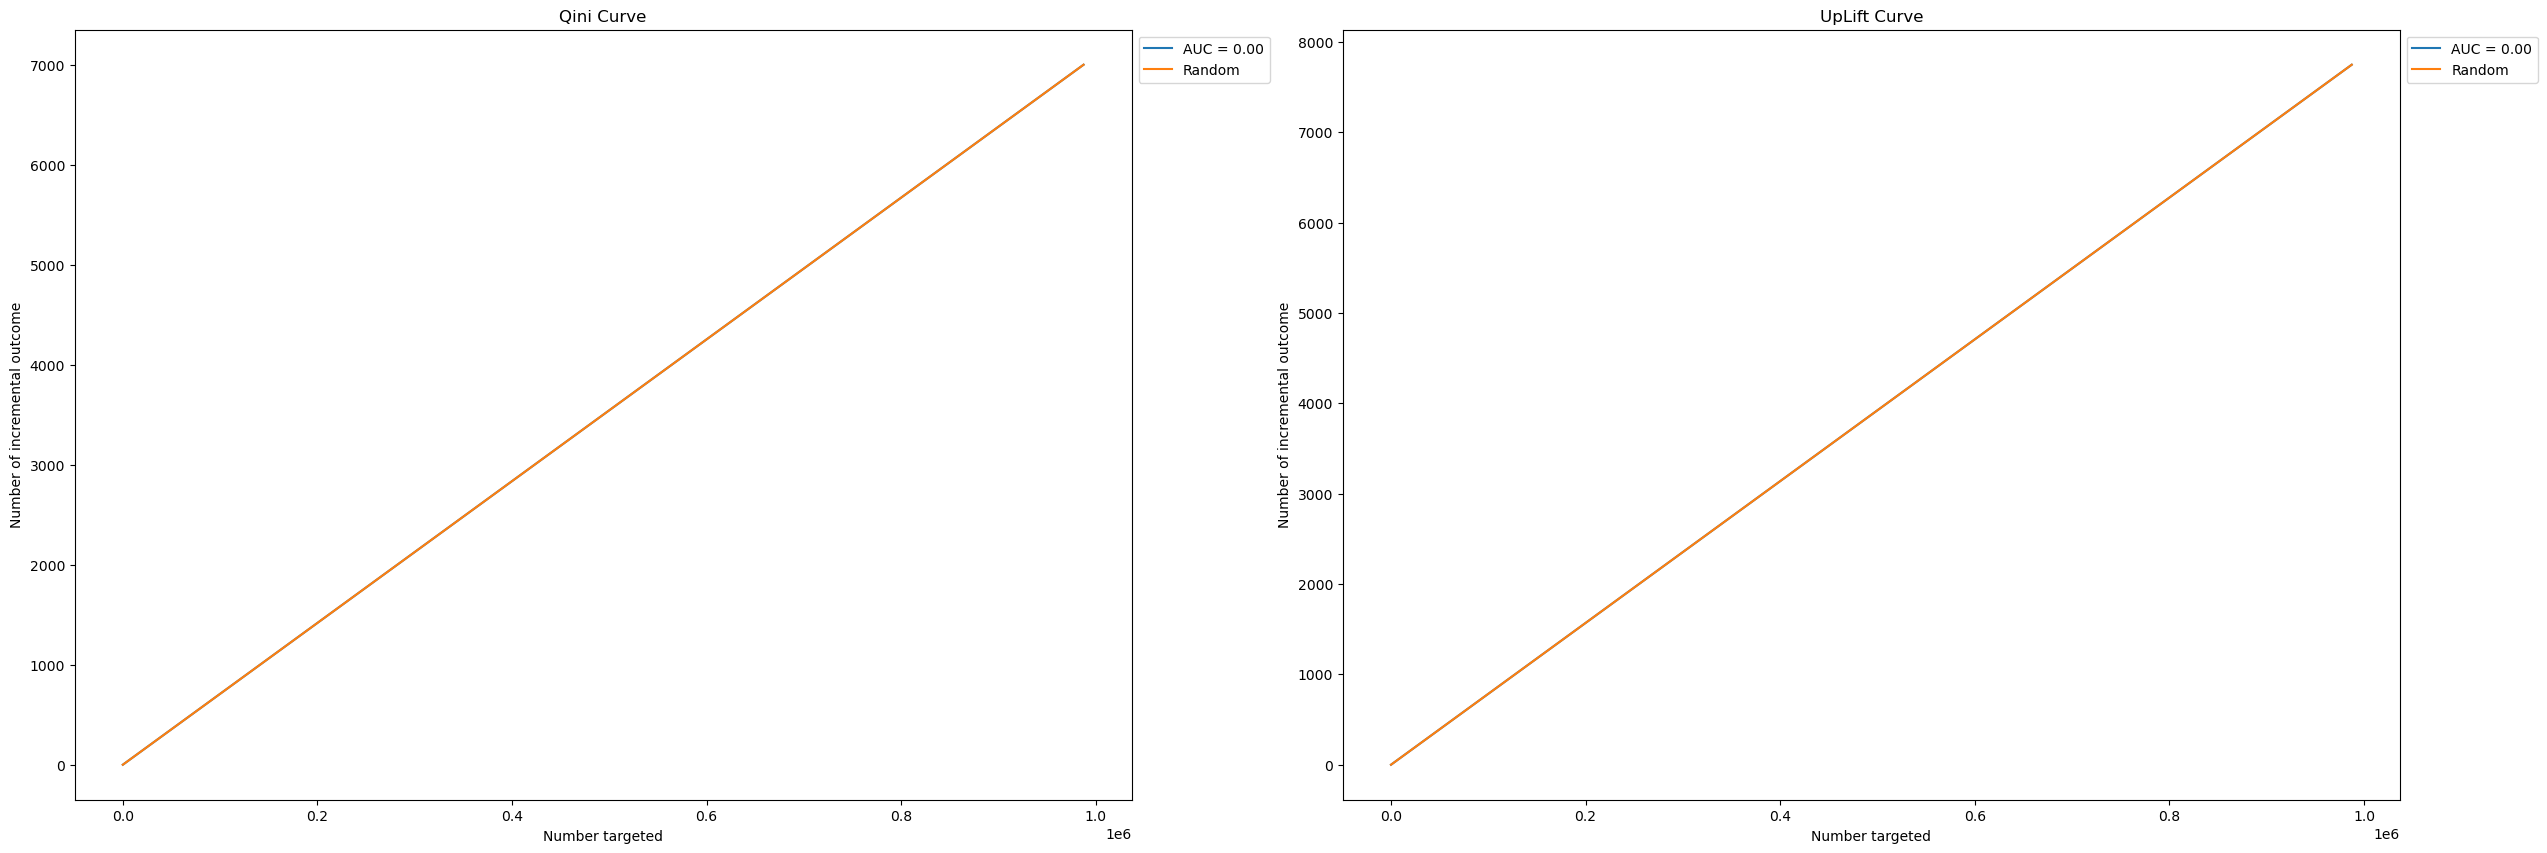

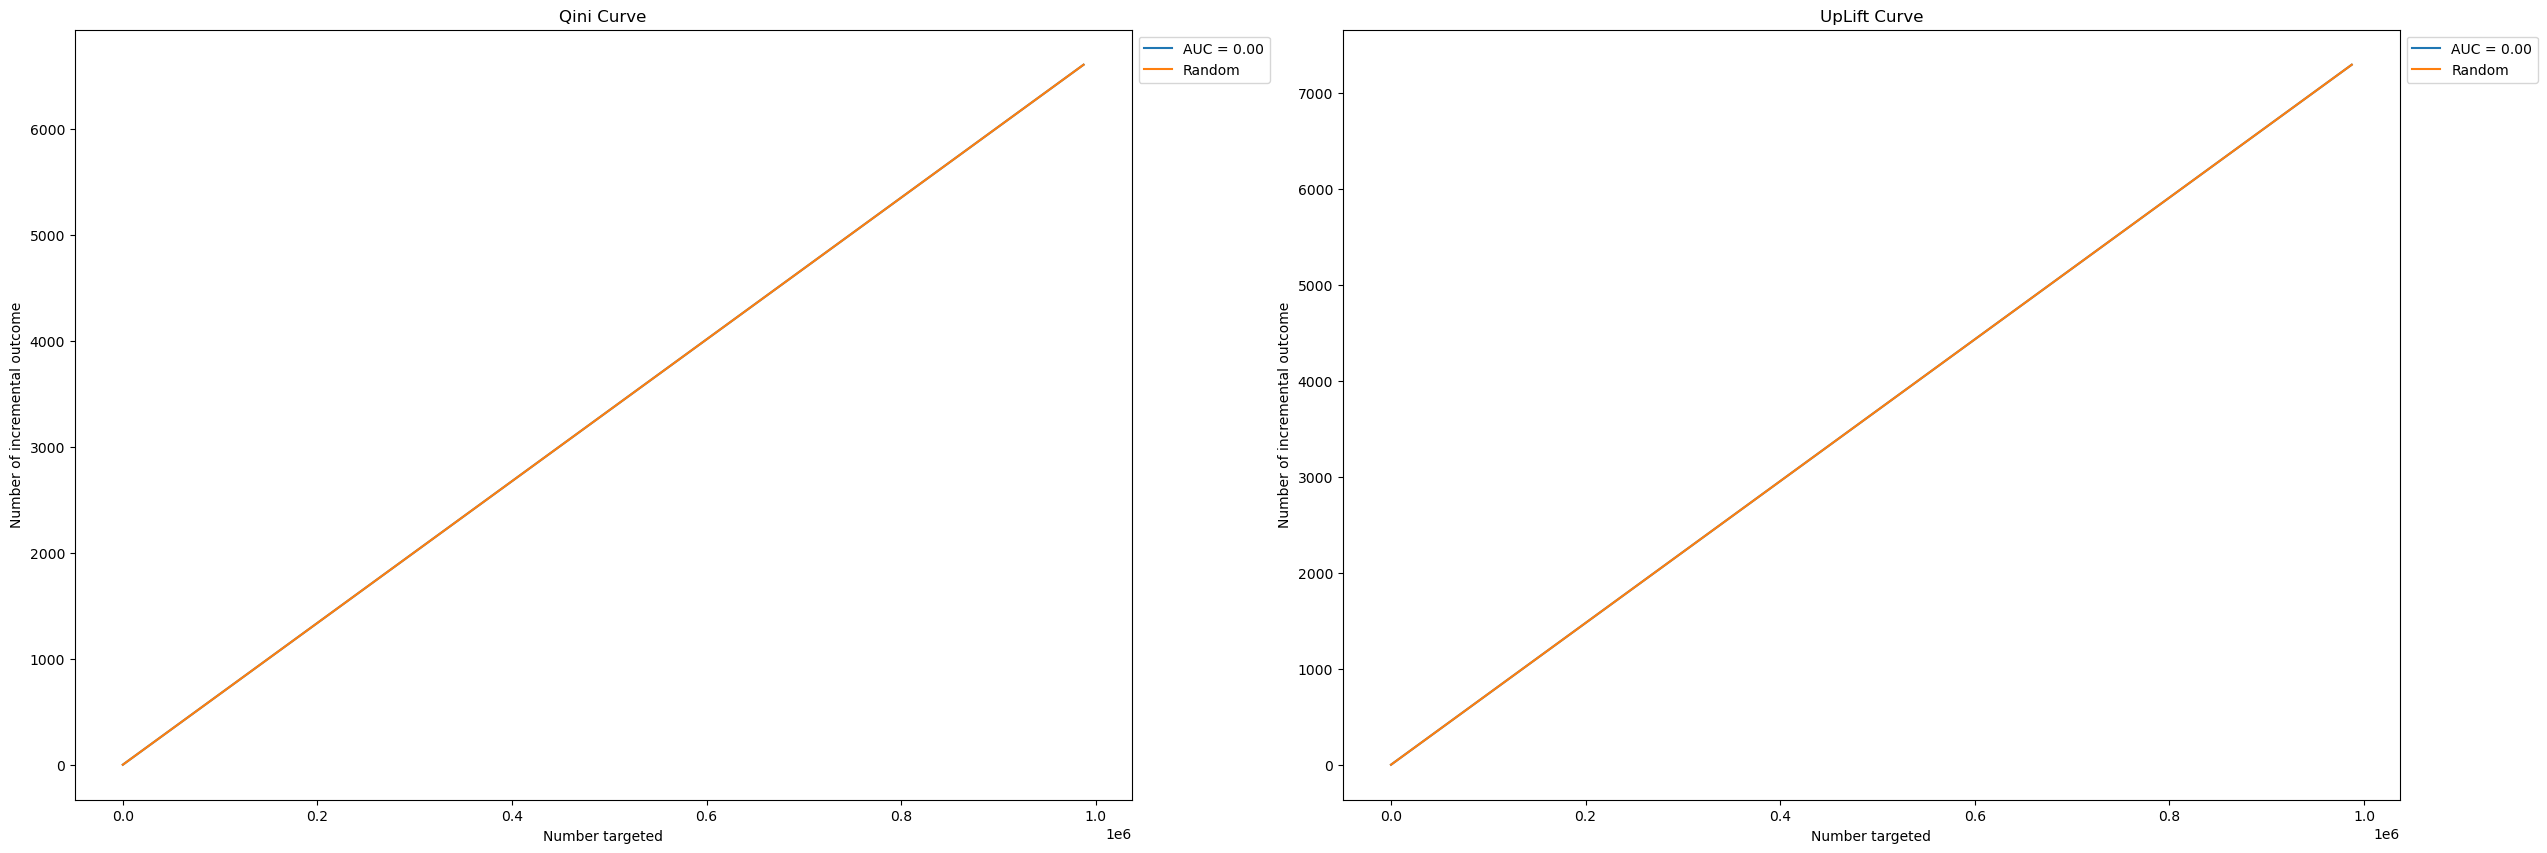

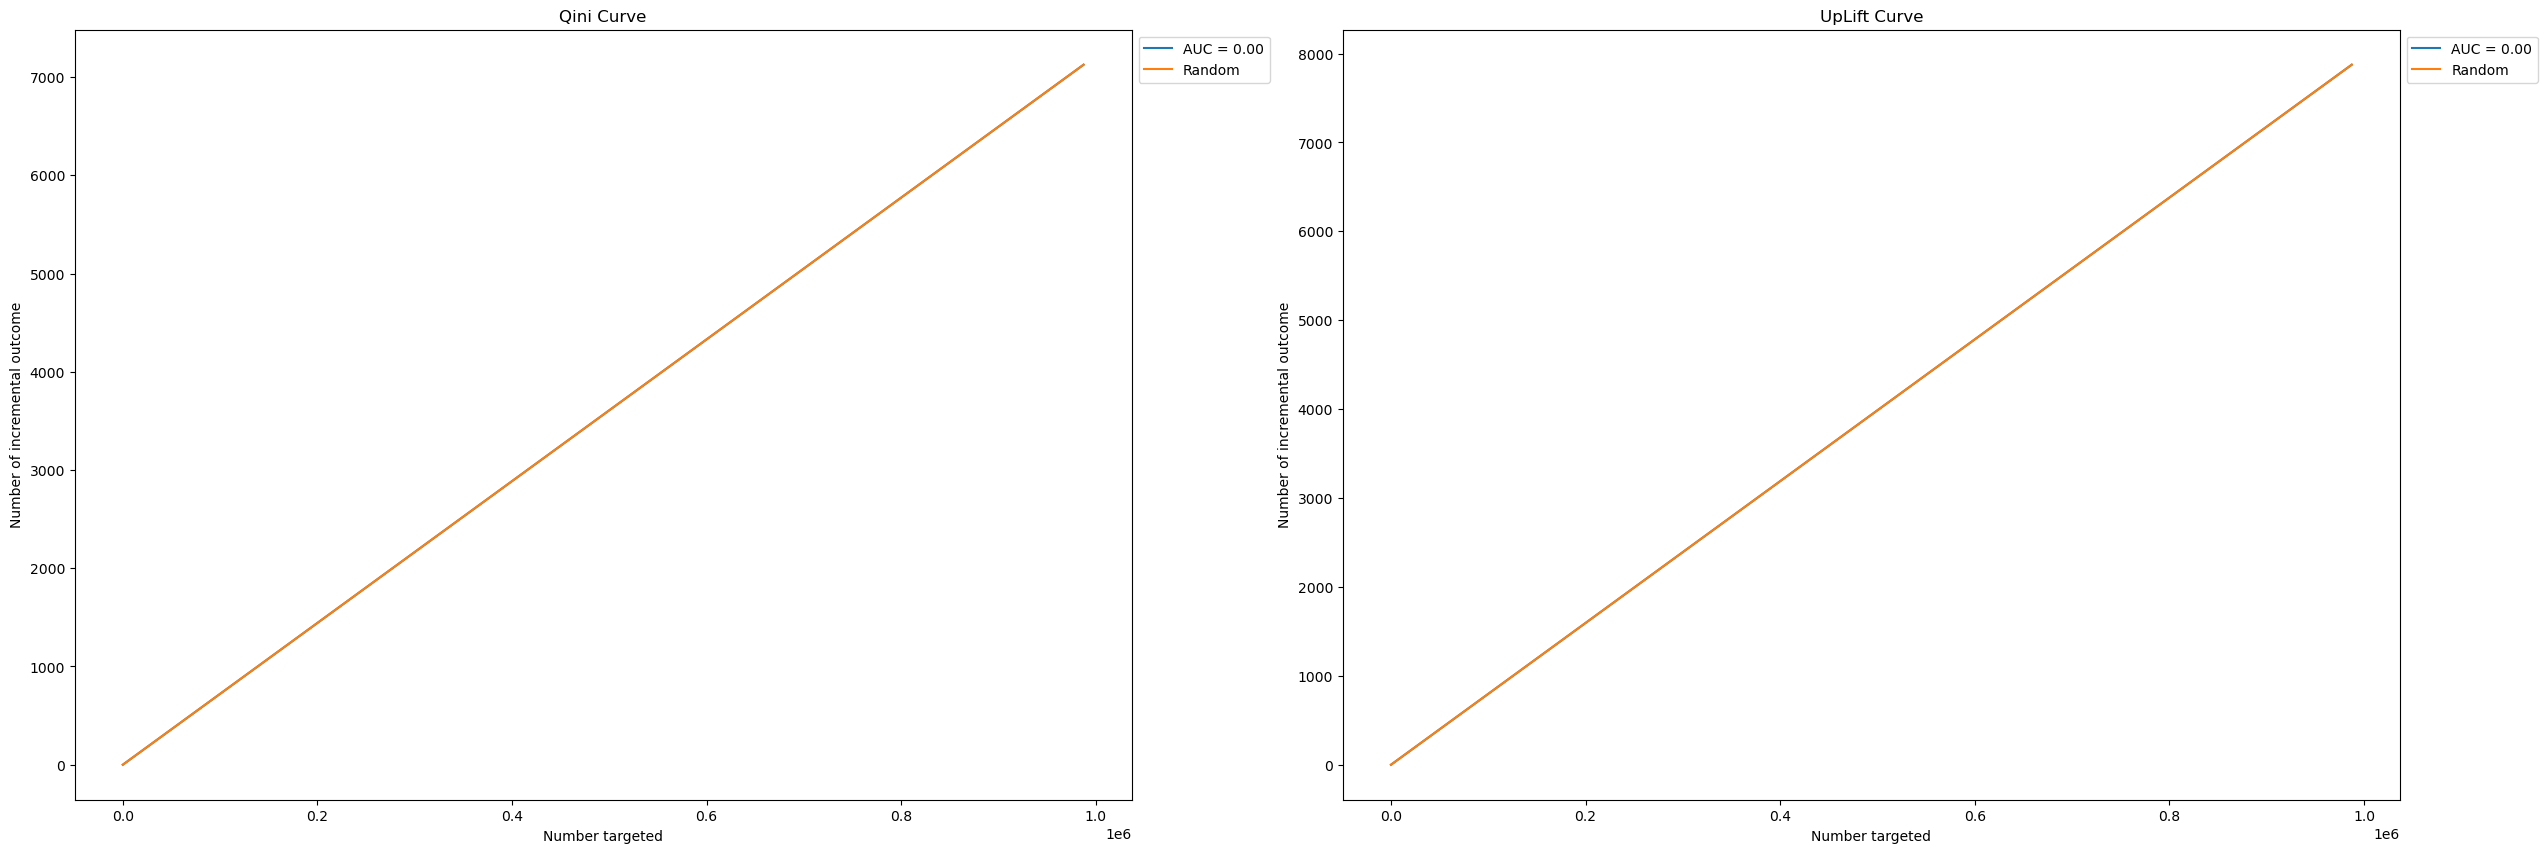

In [21]:
import copy
skf = StratifiedKFold(n_splits=5, random_state= 42, shuffle=True)
skf.get_n_splits(X, y)
metrics = {'uplift_k_group':[],  'uplift_k_overall':[], 'qini_score':[], 'uplift_score':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      #best_clf  = copy.deepcopy(automl.best_pipeline)
      best_clf  = copy.deepcopy(automl.get_pipeline(42))
      best_clf.fit(X_train_, y_train_)
      X_test_[:, -2:] = proc_data.ohe_solomodel.transform(np.zeros(shape = treat[test_index].shape).reshape(-1, 1)).toarray()
      y_pred0 = best_clf.predict_proba(X_test_)[[1]]
      X_test_[:, -2:] = proc_data.ohe_solomodel.transform(np.ones(shape = treat[test_index].shape).reshape(-1, 1)).toarray()
      y_pred1 = best_clf.predict_proba(X_test_)[[1]]
      y_pred = np.squeeze(y_pred1 - y_pred0).tolist()
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      uplift_overall, uplift_group, qini_score, uplift_score = get_report(y_test_, treat[test_index], y_pred, f"Plots/CLassification EvalML model Procentile Split Overall {i}.png")
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      metrics[ 'qini_score'].append(qini_score)
      metrics['uplift_score'].append(uplift_score)
      i += 1
      gc.collect()


uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

In [22]:
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

UpLift at 30%: overall - 0.0086, grouped - 0.0085.
Qini AUC Score: 0.0; UpLift AUC Score: 0.0


In [16]:
del X_data
del Y_data
del X
del treat
del df
del y
gc.collect()

38608

# AutoML Reg

## Search PipeLine

In [56]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte']  + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt

treat = Y_data.treat.values
targ = Y_data.target.values

p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target * (Y_data.treat - p) / (1- p) / p
y = y.values.astype(float)
features = X_data.columns.tolist()
gc.collect()
print(p)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


C:\Users\Kirill\AppData\Local\Temp\ipykernel_5664\2367870135.py:1: DtypeWarning:

Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.



var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7725915336    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725915337    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725915364    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7725915373    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7725915376    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7725915336    0.0     0.0     1.0     1.0     0.0     1.0     0.0     0.0   
7725915337    0.0     0.0     1.0     1.0     0.0     1.0     0.0     0.0   
7725915364    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   
7725915373    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   
7725915376    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7725915336     1.0    0.36 -1.142168 -0.584185 -0.948573 -0.691940 -0.584185   
7725915337     1.0    0.36 -1.142168 -0.584185 -0.948573 -0.691940 -0.584185   
7725915364     0.0    0.36 -0.203041  0.486727 -0.238421  1.219848  0.486727   
7725915373     0.0    0.36 -0.869518  0.631150  1.892033 -0.149537  0.631150   
7725915376     0.0    0.34  0.887558  0.132387  0.471730 -0.052330  0.132387   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7725915336 -0.948573  0.937219 -0.568816 -0.492042 -0.358016 -0.105294   
7725915337 -0.948573  0.937219 -0.568816 -0.492042 -0.358016 -0.105294   
7725915364 -0.238421  0.334366 -0.568816 -0.492042  2.139214 -0.105294   
7725915373  1.892033  0.575507  1.334204  0.881612  0.264101  0.390701   
7725915376  0.471730  1.049378  1.180284  1.776377 -0.007528 -0.105294   

              var_30    var_31    var_32    var_33    var_34    var_35  \
7725915336  1.121290 -0.594659 -0.071611 -0.595567 -0.071611 -0.595567   
7725915337  1.121290 -0.594659 -0.071611 -0.595567 -0.071611 -0.595567   
7725915364 -0.373339 -0.594659  3.453093  0.462552  3.453093  0.462552   
7725915373  0.523438  1.345352 -0.071611  0.722441 -0.071611  0.722441   
7725915376  1.121290  1.345352 -0.071611  0.146973 -0.071611  0.146973   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7725915336 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915337 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915364 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915373  2.010156  0.004130  0.711746  0.812655  0.459654  2.000484   
7725915376  1.795316  0.245265  0.711746 -0.147910 -0.174913 -0.287372   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7725915336 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915337 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915364 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915373  1.738082  0.071780  0.977076 -2.627860  0.266733 -1.271727   
7725915376  1.738082  0.363994  0.977076  0.273855  0.130364  0.210894   

              var_48    var_49    var_50  
7725915336  0.000000  0.000000  0.000000  
7725915337  0.000000  0.000000  0.000000  
7725915364  0.000000  0.000000  0.000000  
7725915373  0.344958  0.040854  0.326157  
7725915376  0.228310  0.000000  0.228310

target  treat
7725915336       0      1
7725915337       0      0
7725915364       0      1
7725915373       0      1
7725915376       0      1

0.9045956538094344


In [57]:
import evalml
from evalml import AutoMLSearch

In [58]:
# from evalml.objectives import get_optimization_objectives
# from evalml.problem_types import ProblemTypes

# for objective in get_optimization_objectives(ProblemTypes.REGRESSION):
#     print(objective.name)

In [59]:
X_train,X_test,y_train,y_test= evalml.preprocessing.utils.split_data(X, y, problem_type="regression", test_size = 1e-6)

In [60]:
automl=AutoMLSearch(X_train = X_train
                    , y_train = y_train
                    , n_jobs = -1
                    , problem_type='regression'
                    , patience= 20
                    , verbose = True
                    , allow_long_running_models = True
                    , max_batches = 20
                    , objective = 'MSE'
                    , optimize_thresholds=True
                    , train_best_pipeline= True
                    , ensembling=True
                    , max_iterations = 20
                    , holdout_set_size= 0
                    #, allowed_model_families = evalml.pipelines.components.utils.allowed_model_families('binary')
                    )


automl.search()

AutoMLSearch will use mean CV score to rank pipelines.

*****************************
* Beginning pipeline search *
*****************************

Optimizing for MSE. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 20 batches for a total of 20 pipelines. 
Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mean Baseline Regression Pipeline
Mean Baseline Regression Pipeline:
	Starting cross validation
	Finished cross validation - mean MSE: 0.741

*****************************
* Evaluating Batch Number 1 *
*****************************

Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean MSE: 0.741
Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer:
	Starting cross validation
	Finished cross validation - mean MSE: 0.741

*****************************
* Evaluating Batch Number 2 *
*****************************

Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler + RF Regressor Select From Model:
	Starting cross validation
	Finished cross validation - mean MSE: 0.741
Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer + RF Regressor Select From Model:
	Starting cross validation
	Finished cr

{1: {'Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler': '04:49',
  'Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer': '05:29',
  'Total time of batch': '10:21'},
 2: {'Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler + RF Regressor Select From Model': '06:23',
  'Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer + RF Regressor Select From Model': '07:17',
  'Total time of batch': '13:42'},
 3: {'Decision Tree Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:39',
  'Extra Trees Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '02:27',
  'XGBoost Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '01:58',
  'CatBoost Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:33',
  'LightGBM Regressor w/ Replace

In [61]:
automl.save('automl_big_searching.cloudpickle')

In [62]:
del X_data
del Y_data
del X_train
del y_train
del X_test
del y_test
del X
del treat
del df
del y
gc.collect()

30

## Train Best Pipeline

In [63]:
import evalml
from evalml import AutoMLSearch
automl = AutoMLSearch.load('automl_big_searching.cloudpickle')


In [64]:
ranks = automl.rankings
ranks = ranks.drop(['id', 'search_order'	,'mean_cv_score'	,'standard_deviation_cv_score', 'high_variance_cv'], axis = 1)

In [65]:
ranks.to_csv('evalml_res.csv', index = False)

In [66]:
ranks.head()

pipeline_name  ranking_score  \
0  CatBoost Regressor w/ Replace Nullable Types T...       0.741275   
1  Elastic Net Regressor w/ Replace Nullable Type...       0.741277   
2  Elastic Net Regressor w/ Replace Nullable Type...       0.741281   
3  Extra Trees Regressor w/ Replace Nullable Type...       0.741282   
4  Elastic Net Regressor w/ Replace Nullable Type...       0.741283   

   percent_better_than_baseline  \
0                      0.001094   
1                      0.000784   
2                      0.000193   
3                      0.000108   
4                      0.000000   

                                          parameters  
0  {'Imputer': {'categorical_impute_strategy': 'm...  
1  {'Imputer': {'categorical_impute_strategy': 'm...  
2  {'Imputer': {'categorical_impute_strategy': 'm...  
3  {'Imputer': {'categorical_impute_strategy': 'm...  
4  {'Imputer': {'categorical_impute_strategy': 'm...

In [67]:
ranks.shape

(12, 4)

In [68]:

ranks.head(10).to_excel('res.xlsx')

In [69]:
ranks.iloc[0, :].parameters

{'Imputer': {'categorical_impute_strategy': 'most_frequent',
  'numeric_impute_strategy': 'mean',
  'boolean_impute_strategy': 'most_frequent',
  'categorical_fill_value': None,
  'numeric_fill_value': None,
  'boolean_fill_value': None},
 'Select Columns Transformer': {'columns': [3,
   11,
   14,
   18,
   19,
   20,
   22,
   23,
   25,
   26,
   27,
   28,
   30,
   33,
   35,
   36,
   37,
   39,
   40,
   43,
   45,
   46,
   47,
   48,
   49,
   50]},
 'CatBoost Regressor': {'n_estimators': 10,
  'eta': 0.03,
  'max_depth': 6,
  'bootstrap_type': None,
  'silent': False,
  'allow_writing_files': False,
  'n_jobs': -1}}

In [70]:
ctbst  = automl.best_pipeline
type(ctbst)

evalml.pipelines.regression_pipeline.RegressionPipeline

In [71]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'] + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt

treat = Y_data.treat.values
targ = Y_data.target.values

p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target * (Y_data.treat - p) / (1- p) / p
y = y.values
features = X_data.columns.tolist()
gc.collect()
print(p)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


C:\Users\Kirill\AppData\Local\Temp\ipykernel_5664\2157392424.py:1: DtypeWarning:

Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.



var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7725915336    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725915337    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725915364    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7725915373    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7725915376    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7725915336    0.0     0.0     1.0     1.0     0.0     1.0     0.0     0.0   
7725915337    0.0     0.0     1.0     1.0     0.0     1.0     0.0     0.0   
7725915364    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   
7725915373    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   
7725915376    0.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7725915336     1.0    0.36 -1.142168 -0.584185 -0.948573 -0.691940 -0.584185   
7725915337     1.0    0.36 -1.142168 -0.584185 -0.948573 -0.691940 -0.584185   
7725915364     0.0    0.36 -0.203041  0.486727 -0.238421  1.219848  0.486727   
7725915373     0.0    0.36 -0.869518  0.631150  1.892033 -0.149537  0.631150   
7725915376     0.0    0.34  0.887558  0.132387  0.471730 -0.052330  0.132387   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7725915336 -0.948573  0.937219 -0.568816 -0.492042 -0.358016 -0.105294   
7725915337 -0.948573  0.937219 -0.568816 -0.492042 -0.358016 -0.105294   
7725915364 -0.238421  0.334366 -0.568816 -0.492042  2.139214 -0.105294   
7725915373  1.892033  0.575507  1.334204  0.881612  0.264101  0.390701   
7725915376  0.471730  1.049378  1.180284  1.776377 -0.007528 -0.105294   

              var_30    var_31    var_32    var_33    var_34    var_35  \
7725915336  1.121290 -0.594659 -0.071611 -0.595567 -0.071611 -0.595567   
7725915337  1.121290 -0.594659 -0.071611 -0.595567 -0.071611 -0.595567   
7725915364 -0.373339 -0.594659  3.453093  0.462552  3.453093  0.462552   
7725915373  0.523438  1.345352 -0.071611  0.722441 -0.071611  0.722441   
7725915376  1.121290  1.345352 -0.071611  0.146973 -0.071611  0.146973   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7725915336 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915337 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915364 -0.646042 -0.375007 -0.605534 -0.147910 -0.174913 -0.287372   
7725915373  2.010156  0.004130  0.711746  0.812655  0.459654  2.000484   
7725915376  1.795316  0.245265  0.711746 -0.147910 -0.174913 -0.287372   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7725915336 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915337 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915364 -0.651082 -0.387668 -0.632165  0.435062  0.334918  0.404280   
7725915373  1.738082  0.071780  0.977076 -2.627860  0.266733 -1.271727   
7725915376  1.738082  0.363994  0.977076  0.273855  0.130364  0.210894   

              var_48    var_49    var_50  
7725915336  0.000000  0.000000  0.000000  
7725915337  0.000000  0.000000  0.000000  
7725915364  0.000000  0.000000  0.000000  
7725915373  0.344958  0.040854  0.326157  
7725915376  0.228310  0.000000  0.228310

target  treat
7725915336       0      1
7725915337       0      0
7725915364       0      1
7725915373       0      1
7725915376       0      1

0.9045956538094344


UpLift at 30%: overall - 0.014872, grouped - 0.015997.
Qini AUC Score: 0.021733; UpLift AUC Score: 0.013658
UpLift at 30%: overall - 0.01422, grouped - 0.015457.
Qini AUC Score: 0.022132; UpLift AUC Score: 0.01394
UpLift at 30%: overall - 0.014893, grouped - 0.016215.
Qini AUC Score: 0.020224; UpLift AUC Score: 0.012718
UpLift at 30%: overall - 0.017247, grouped - 0.01832.
Qini AUC Score: 0.025657; UpLift AUC Score: 0.016046
UpLift at 30%: overall - 0.010213, grouped - 0.011335.
Qini AUC Score: 0.016557; UpLift AUC Score: 0.010386
UpLift at 30%: overall - 0.0143, grouped - 0.0155.
Qini AUC Score: 0.0213; UpLift AUC Score: 0.0133


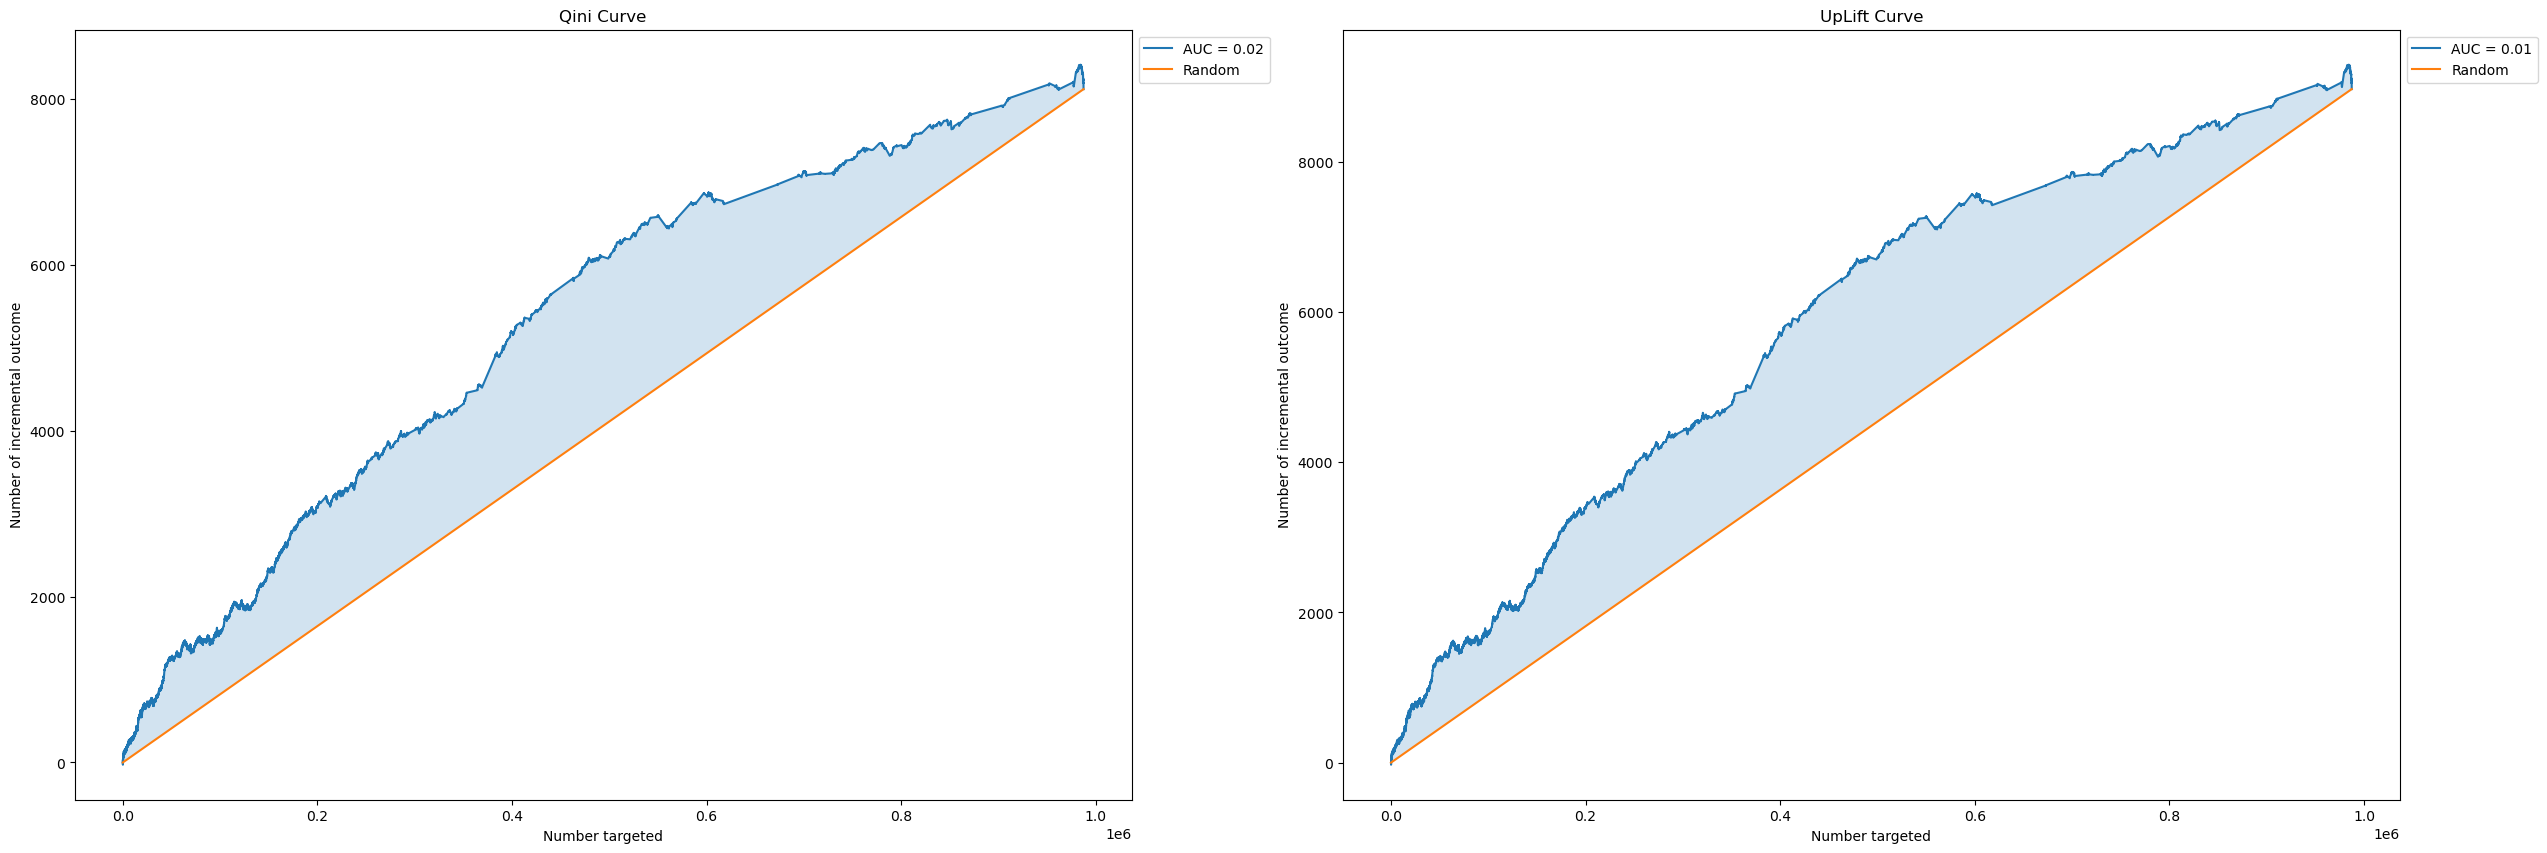

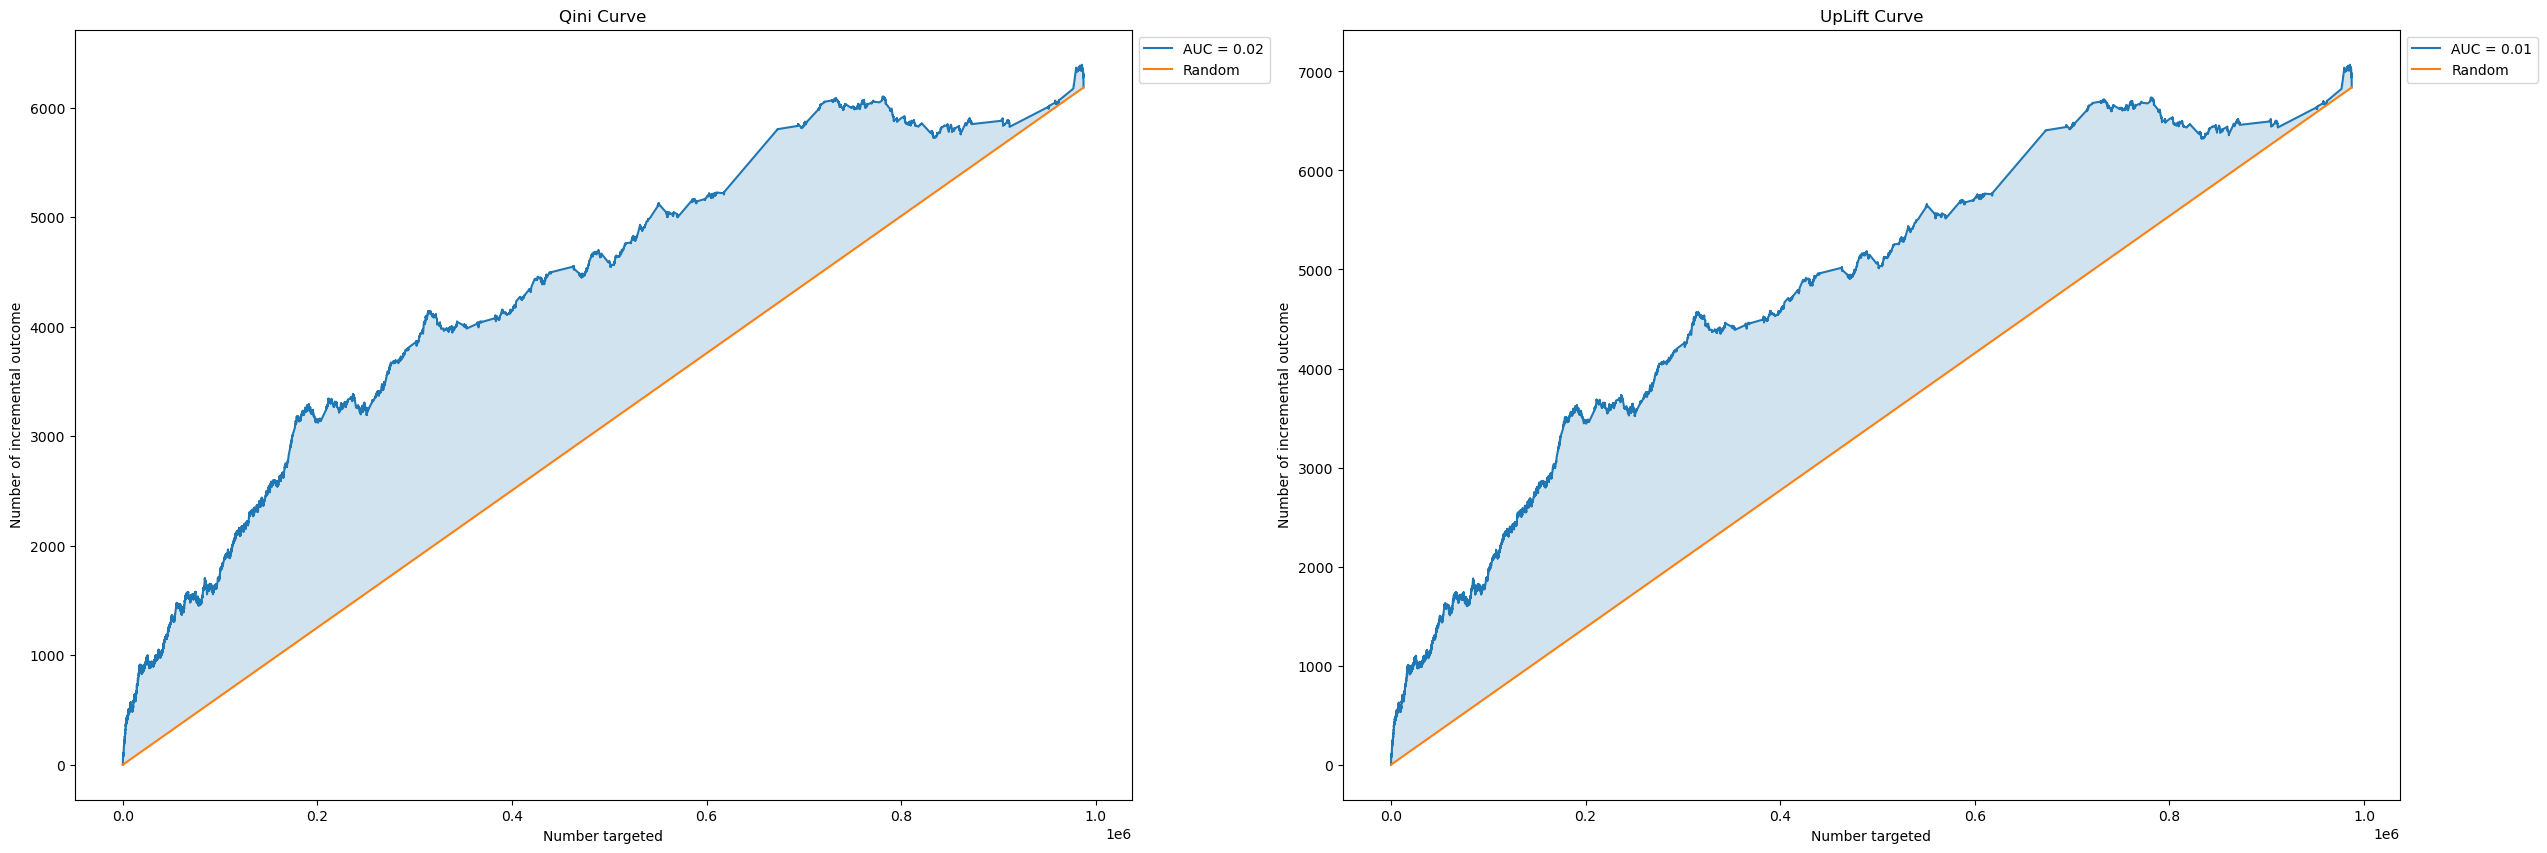

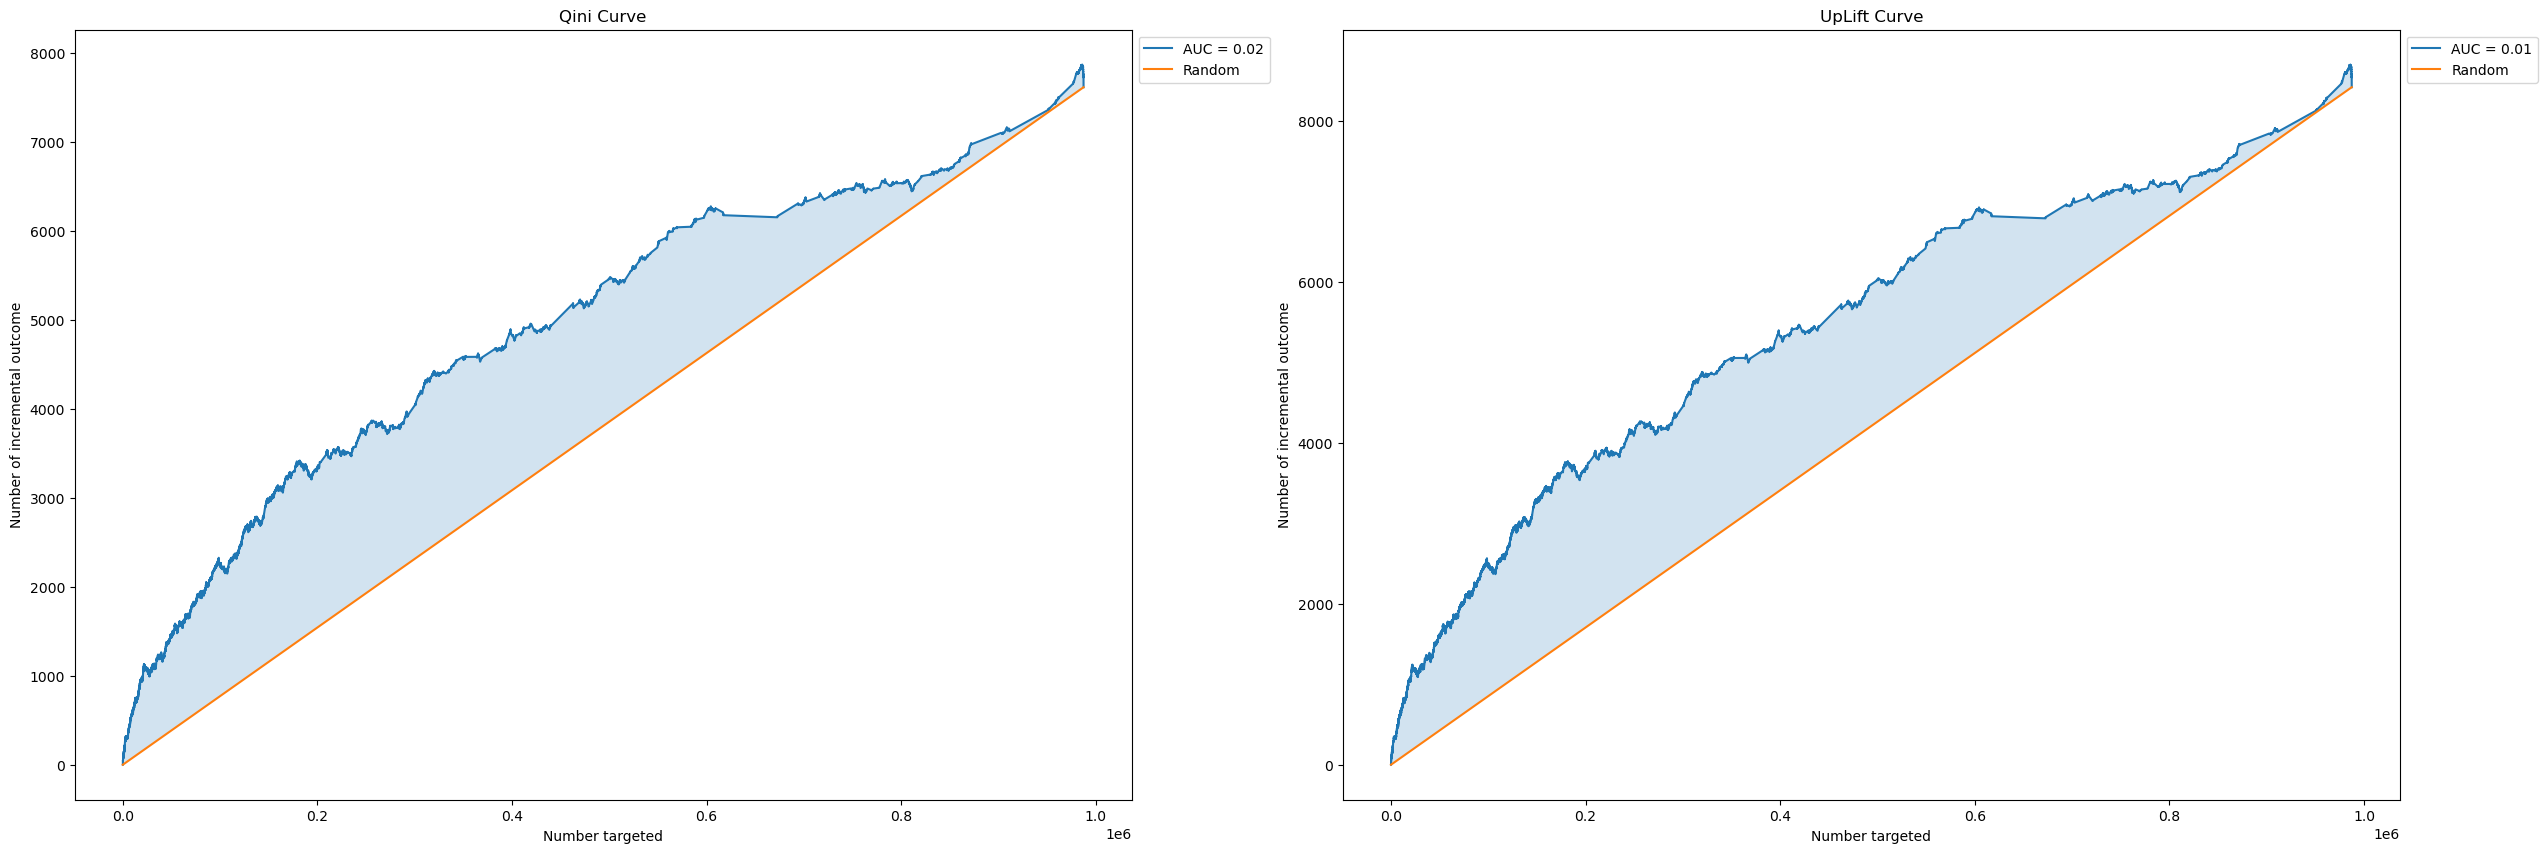

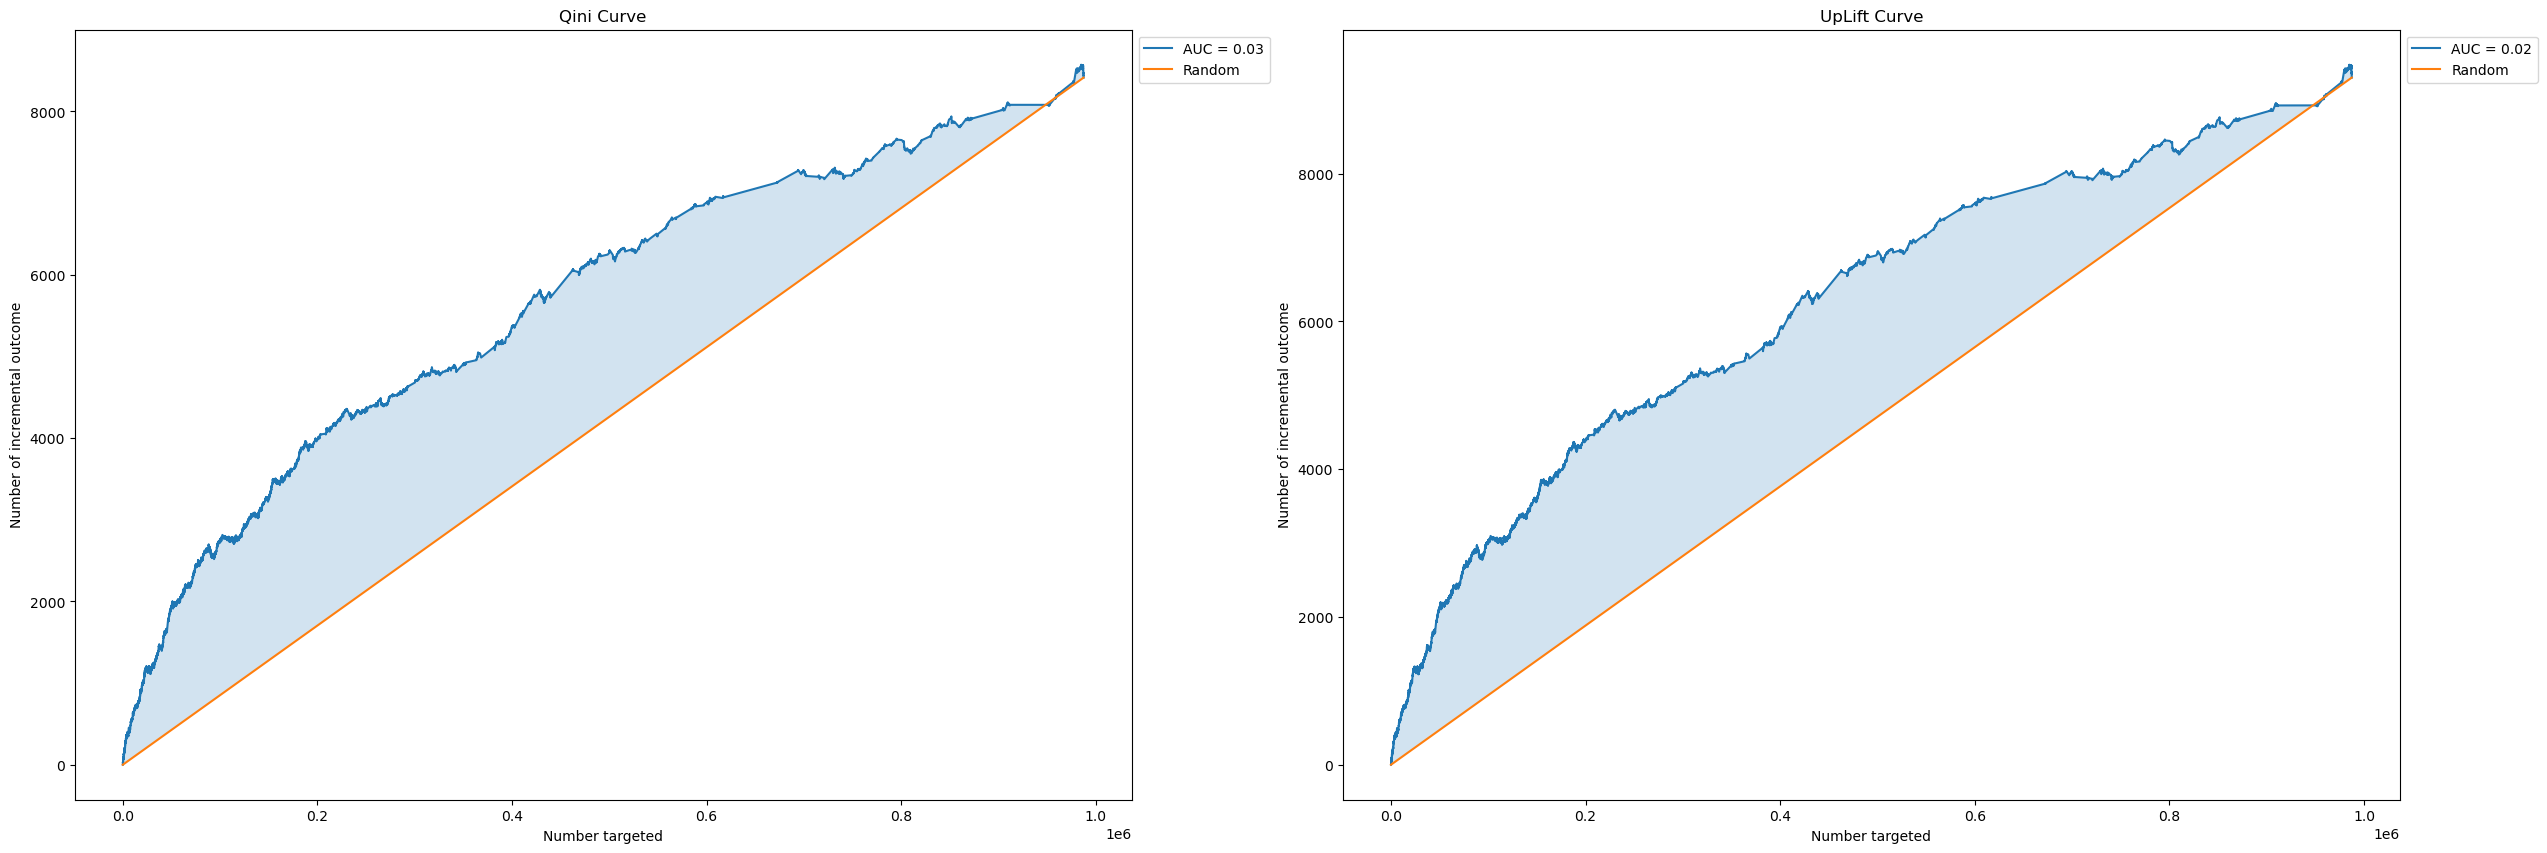

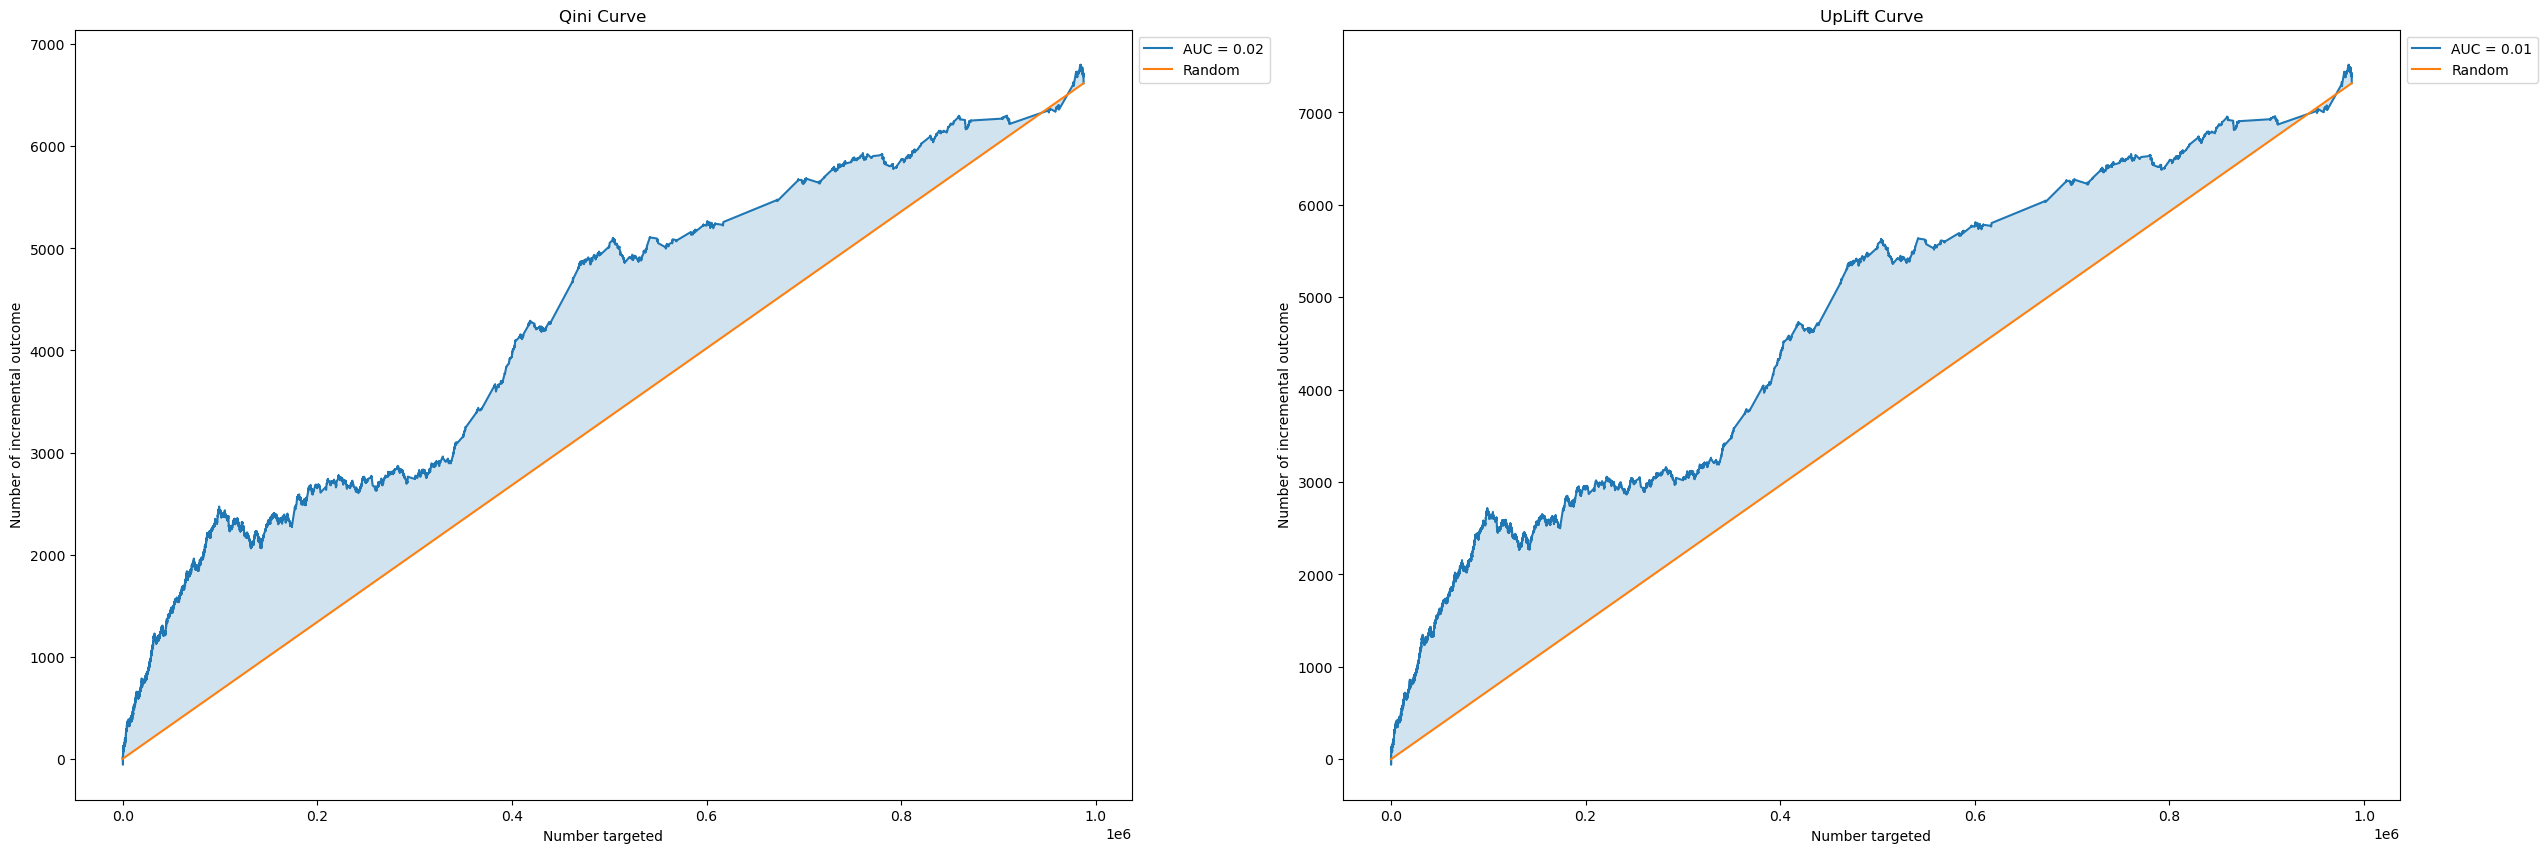

In [72]:
import copy
skf = KFold(n_splits=5, random_state= 42, shuffle=True)
skf.get_n_splits(X, y)
metrics = {'uplift_k_group':[],  'uplift_k_overall':[], 'qini_score':[], 'uplift_score':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      ctbst  = copy.deepcopy(automl.best_pipeline)
      ctbst.fit(X_train_, y_train_)
      y_pred = ctbst.predict(X_test_)
      del X_train_
      del y_train_ 
      del X_test_
      gc.collect()
      uplift_overall, uplift_group, qini_score, uplift_score = get_report(targ[test_index], treat[test_index], y_pred, f"Plots/Trasnform Regression EvalML model Split {i}.png")
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      metrics['qini_score'].append(qini_score)
      metrics['uplift_score'].append(uplift_score)
      i += 1
      gc.collect()


uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

In [73]:
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

UpLift at 30%: overall - 0.0143, grouped - 0.0155.
Qini AUC Score: 0.0213; UpLift AUC Score: 0.0133


In [74]:
del X_data
del Y_data
del X
del treat
del df
del y
gc.collect()

37457